In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

project_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la"
!mkdir -p "{project_dir}"

# Download LA.zip into Drive
!wget --content-disposition -O "{project_dir}/LA.zip" "https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3&isAllowed=y"

# Unzip into place
!unzip -q "{project_dir}/LA.zip" -d "{project_dir}/"

# List contents to confirm
!ls "{project_dir}" | head -n 20


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-08-18 12:21:23--  https://datashare.ed.ac.uk/bitstream/handle/10283/3336/LA.zip?sequence=3&isAllowed=y
Resolving datashare.ed.ac.uk (datashare.ed.ac.uk)... 129.215.67.172
Connecting to datashare.ed.ac.uk (datashare.ed.ac.uk)|129.215.67.172|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 7640952520 (7.1G) [application/zip]
Saving to: ‘/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA.zip’

/content/drive/MyDr 100%[===================>]   7.12G  7.40MB/s    in 11m 37s 

2025-08-18 12:33:01 (10.5 MB/s) - ‘/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA.zip’ saved [7640952520/7640952520]

LA
LA.zip


In [ ]:
import os

# Path to where you unzipped LA.zip
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

# Check subfolders
expected_folders = [
    "ASVspoof2019_LA_train",
    "ASVspoof2019_LA_dev",
    "ASVspoof2019_LA_eval",
    "ASVspoof2019_LA_cm_protocols"
]

print("Checking dataset structure...\n")
for folder in expected_folders:
    path = os.path.join(dataset_dir, folder)
    if os.path.exists(path):
        print(f" Found: {folder}")
    else:
        print(f" Missing: {folder}")

# Check if protocol files are present
protocol_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols")
if os.path.exists(protocol_dir):
    protocol_files = os.listdir(protocol_dir)
    print("\nProtocol files:")
    for f in protocol_files:
        print(" -", f)
else:
    print("\n Protocol folder missing")

# Quick sample of train audio files
train_flac_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_train", "flac")
if os.path.exists(train_flac_dir):
    sample_files = os.listdir(train_flac_dir)[:5]
    print(f"\nSample audio files from train set: {sample_files}")
else:
    print("\n Train audio folder missing")


Checking dataset structure...

 Found: ASVspoof2019_LA_train
 Found: ASVspoof2019_LA_dev
 Found: ASVspoof2019_LA_eval
 Found: ASVspoof2019_LA_cm_protocols

Protocol files:
 - ASVspoof2019.LA.cm.dev.trl.txt
 - ASVspoof2019.LA.cm.eval.trl.txt
 - ASVspoof2019.LA.cm.train.trn.txt

Sample audio files from train set: ['LA_T_3653923.flac', 'LA_T_9203016.flac', 'LA_T_7555561.flac', 'LA_T_5726173.flac', 'LA_T_8788751.flac']


In [ ]:

# 1 Set Dataset Path & Import Libraries


# Path to your unzipped ASVspoof 2019 LA dataset
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

# Python imports
import os
import librosa
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from tqdm import tqdm


In [ ]:

# 2️ Load Protocol Files & Audio Paths
# PURPOSE:
# The protocol files tell us which audio files are "bonafide" (real) or "spoof" (fake).
# We will read these protocol files and create:
#   - A list of audio file paths
#   - A list of labels: 1 for bonafide, 0 for spoof

def load_protocol(protocol_file, audio_base_path):
    """
    Reads a protocol file and returns:
    - file_paths: list of absolute paths to .flac audio files
    - labels: list of 1 (bonafide) or 0 (spoof)
    """
    file_paths, labels = [], []
    with open(protocol_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # parts[1] is the file name without extension
            filename = parts[1] + ".flac"
            # parts[4] is either "bonafide" or "spoof"
            label = 1 if parts[4] == "bonafide" else 0
            # Store full path and label
            file_paths.append(os.path.join(audio_base_path, filename))
            labels.append(label)
    return file_paths, labels

# --- Set correct paths for protocol and audio folders ---
train_protocol = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
train_audio_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_train", "flac")

dev_protocol = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.dev.trl.txt")
dev_audio_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_dev", "flac")

# --- Load file paths and labels ---
train_files, train_labels = load_protocol(train_protocol, train_audio_dir)
dev_files, dev_labels = load_protocol(dev_protocol, dev_audio_dir)

print(f"Loaded {len(train_files)} training files and {len(dev_files)} dev files.")
print("Example train file path:", train_files[0])
print("Example label (1=bonafide, 0=spoof):", train_labels[0])


Loaded 25380 training files and 24844 dev files.
Example train file path: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_train/flac/LA_T_1138215.flac
Example label (1=bonafide, 0=spoof): 1


In [ ]:

# 3️ Custom LFCC Feature Extractor
# PURPOSE:
# LFCC = Linear Frequency Cepstral Coefficients
# Similar to MFCC, but uses linear frequency spacing instead of mel scale.
# We compute:
#   - Linear filterbank energies
#   - Log compression
#   - Discrete Cosine Transform (DCT) to get cepstral coefficients
# We return features per frame, then we can average them later for utterance-level representation.

import scipy.fftpack

def extract_lfcc(audio_path, sr=16000, n_fft=512, win_length=0.025, hop_length=0.010, n_filters=20, n_ceps=20):
    """
    Extract LFCC features from an audio file.
    Parameters:
        audio_path (str): path to .flac audio file
        sr (int): sampling rate
        n_fft (int): FFT size
        win_length (float): window length in seconds
        hop_length (float): hop size in seconds
        n_filters (int): number of linear filterbanks
        n_ceps (int): number of cepstral coefficients to keep
    Returns:
        numpy.ndarray: LFCC features (frames x coefficients)
    """
    # Load audio
    y, _ = librosa.load(audio_path, sr=sr)

    # Compute power spectrum
    S = np.abs(librosa.stft(
        y,
        n_fft=n_fft,
        win_length=int(win_length*sr),
        hop_length=int(hop_length*sr)
    ))**2

    # Create linear filterbank
    linear_fb = np.zeros((n_filters, S.shape[0]))
    freqs = np.linspace(0, sr/2, S.shape[0])
    filter_edges = np.linspace(0, sr/2, n_filters+2)
    for i in range(1, n_filters+1):
        left = filter_edges[i-1]
        center = filter_edges[i]
        right = filter_edges[i+1]
        left_slope = (freqs - left) / (center - left)
        right_slope = (right - freqs) / (right - center)
        linear_fb[i-1] = np.maximum(0, np.minimum(left_slope, right_slope))

    # Apply filterbank
    fb_energies = np.dot(linear_fb, S)

    # Log compression
    fb_energies = np.log(fb_energies + 1e-6)

    # Discrete Cosine Transform (DCT-II)
    lfcc = scipy.fftpack.dct(fb_energies, axis=0, norm='ortho')[0:n_ceps, :]

    return lfcc.T  # shape: (frames, n_ceps)


In [ ]:

# 4️ Extract LFCC Features for All Files
# PURPOSE:
# We will extract LFCC features for every file in the train and dev sets.
# For each file, we:
#   - Get frame-level LFCCs from Block 3
#   - Average across frames to produce one fixed-length feature vector per utterance
# This will be used for training the GMM.

def extract_features(file_list):
    """
    Extracts averaged LFCC features for a list of audio files.
    Parameters:
        file_list (list): list of .flac file paths
    Returns:
        numpy.ndarray: matrix (num_files x num_features)
    """
    features = []
    for file in tqdm(file_list, desc="Extracting LFCC features"):
        lfcc = extract_lfcc(file)
        lfcc_mean = np.mean(lfcc, axis=0)  # average over frames
        features.append(lfcc_mean)
    return np.array(features)

# Extract features for train and dev sets
X_train = extract_features(train_files)
X_dev = extract_features(dev_files)

print(f"Train feature matrix shape: {X_train.shape}")
print(f"Dev feature matrix shape: {X_dev.shape}")


Extracting LFCC features: 100%|██████████| 24844/24844 [04:46<00:00, 86.74it/s] 

Train feature matrix shape: (25380, 20)
Dev feature matrix shape: (24844, 20)


In [ ]:

# Save extracted features to Drive
save_dir = os.path.join(dataset_dir, "features")
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "X_train_lfcc.npy"), X_train)
np.save(os.path.join(save_dir, "X_dev_lfcc.npy"), X_dev)
np.save(os.path.join(save_dir, "y_train.npy"), np.array(train_labels))
np.save(os.path.join(save_dir, "y_dev.npy"), np.array(dev_labels))

print(f"Features saved in {save_dir}")


Features saved in /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/features


In [ ]:

# 5️ Train GMM Classifier & Evaluate
# PURPOSE:
# We will train two separate Gaussian Mixture Models:
#   - One for bonafide (real) speech
#   - One for spoof (fake) speech
# Then, for each test file, we will:
#   - Get its feature vector
#   - Compute likelihood score from both GMMs
#   - Take the difference as the decision score
# Finally, we compute EER (Equal Error Rate) — the point where FAR = FRR.

# --- Load saved features from Drive (if not already in memory) ---
save_dir = os.path.join(dataset_dir, "features")
X_train = np.load(os.path.join(save_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(save_dir, "X_dev_lfcc.npy"))
train_labels = np.load(os.path.join(save_dir, "y_train.npy"))
dev_labels = np.load(os.path.join(save_dir, "y_dev.npy"))

print(" Features loaded. Shapes:")
print(f"Train: {X_train.shape}, Dev: {X_dev.shape}")

# ---  Split into bonafide and spoof for training ---
X_train_bonafide = X_train[train_labels == 1]
X_train_spoof = X_train[train_labels == 0]

# ---  Train GMM for bonafide speech ---
gmm_bonafide = GaussianMixture(
    n_components=512,        # Number of Gaussian components
    covariance_type='diag',  # Diagonal covariance for speed
    random_state=42
).fit(X_train_bonafide)

# ---  Train GMM for spoofed speech ---
gmm_spoof = GaussianMixture(
    n_components=512,
    covariance_type='diag',
    random_state=42
).fit(X_train_spoof)

print(" GMM models trained successfully.")

# ---  Compute decision scores for dev set ---
# Score = log-likelihood under bonafide GMM - log-likelihood under spoof GMM
scores_dev = gmm_bonafide.score_samples(X_dev) - gmm_spoof.score_samples(X_dev)

# ---  Compute EER ---
fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev)
fnr = 1 - tpr
eer_index = np.nanargmin(np.absolute(fnr - fpr))
eer_threshold = thresholds[eer_index]
eer = fpr[eer_index] * 100

print(f" Equal Error Rate (EER): {eer:.2f}% at threshold {eer_threshold:.4f}")


 Features loaded. Shapes:
Train: (25380, 20), Dev: (24844, 20)
 GMM models trained successfully.
 Equal Error Rate (EER): 23.23% at threshold -11.9727


In [ ]:

# Save Experiment Results to CSV
import pandas as pd

# Path to results CSV in your MSc_Project folder
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# Define your experiment name (change this each time you try new settings)
experiment_name = "lfcc_20ceps_gmm001"

# Create a dictionary for this run
result_entry = {
    "Experiment": experiment_name,
    "Features": "LFCC",
    "Num_Ceps": 20,
    "Num_Filters": 20,
    "Model": "GMM",
    "GMM_Components": 512,
    "EER (%)": round(eer, 2),
    "Threshold": round(float(eer_threshold), 4)
}

# Save to CSV (append if exists)
if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([result_entry])

df_results.to_csv(results_csv, index=False)

print(f"Experiment '{experiment_name}' saved to {results_csv}")
print(df_results.tail())  # Show the last few entries


Experiment 'lfcc_20ceps_gmm001' saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv
           Experiment Features Num_Ceps Num_Filters Model GMM_Components  \
0  lfcc_20ceps_gmm001     LFCC       20          20   GMM            512   

   EER (%)  Threshold  
0    23.23   -11.9727  


/tmp/ipython-input-998131257.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)


In [ ]:
# Delete row experiment record

import pandas as pd

# Path to your CSV
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# Load the CSV
df_results = pd.read_csv(results_csv)

# Name of the experiment you want to delete
delete_experiment = "lfcc_20ceps_gmm001"

# Filter out the unwanted experiment
df_results = df_results[df_results["Experiment"] != delete_experiment]

# Save back to CSV
df_results.to_csv(results_csv, index=False)

print(f" Experiment '{delete_experiment}' removed from results.")
print(df_results)


 Experiment 'lfcc_20ceps_gmm001' removed from results.
                   Experiment Features  Num_Ceps  Num_Filters Model  \
1   lfcc_20ceps_20filt_gmm512     LFCC      20.0         20.0   GMM   
2   lfcc_30ceps_30filt_gmm512     LFCC      30.0         30.0   GMM   
3  lfcc_30ceps_20filt_gmm1024     LFCC      30.0         20.0   GMM   
4   lfcc_20ceps_40filt_gmm512     LFCC      20.0         40.0   GMM   
5             svm_linear_lfcc     LFCC       NaN          NaN   SVM   
6                svm_rbf_lfcc     LFCC       NaN          NaN   SVM   

   GMM_Components  EER (%)  Threshold  Kernel  Accuracy (%)  Precision (%)  \
1           512.0    23.23   -11.9727     NaN           NaN            NaN   
2           512.0    12.86    -9.8501     NaN           NaN            NaN   
3          1024.0    24.14   -25.3577     NaN           NaN            NaN   
4           512.0    14.94    -8.4266     NaN           NaN            NaN   
5             NaN    20.27     0.0922  linear         91.

In [ ]:

# View Best Experiment
# PURPOSE:
# This script will:
#   1. Load your experiment results CSV
#   2. Find the experiment with the lowest EER (best performance)
#   3. Display all experiments sorted from best to worst by EER
# WHY:
# Helps track progress over time and compare different model/feature settings.

import pandas as pd

# 1 Path to your results CSV file in MSc_Project
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# 2️ Load the CSV into a Pandas DataFrame
df_results = pd.read_csv(results_csv)

# 3 Find the row with the minimum EER
# idxmin() → returns the index of the smallest EER value
best_row = df_results.loc[df_results["EER (%)"].idxmin()]

# 4️ Display the best experiment
print("Best Experiment So Far:")
print(best_row)

# 5️ (Optional) Show all experiments sorted by EER
print("\n All Experiments Sorted by EER:")
print(df_results.sort_values(by="EER (%)", ascending=True))


Best Experiment So Far:
Experiment        lfcc_20ceps_gmm001
Features                        LFCC
Num_Ceps                          20
Num_Filters                       20
Model                            GMM
GMM_Components                   512
EER (%)                        23.23
Threshold                   -11.9727
Name: 0, dtype: object

 All Experiments Sorted by EER:
           Experiment Features  Num_Ceps  Num_Filters Model  GMM_Components  \
0  lfcc_20ceps_gmm001     LFCC        20           20   GMM             512   

   EER (%)  Threshold  
0    23.23   -11.9727  


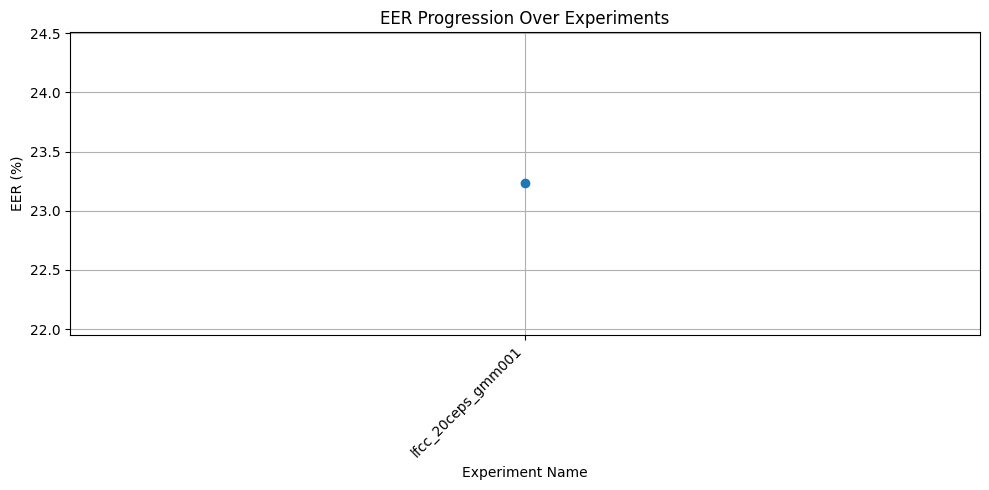

In [ ]:

# Plot EER Progression Over Experiments
# PURPOSE:
#   - Visualize how your Equal Error Rate (EER) changes across experiments
#   - Helps you quickly see if you are improving
# WHY:
#   - Graphs make it easy to spot trends and show progress in reports/dissertations

import pandas as pd
import matplotlib.pyplot as plt

# 1️ Path to your experiment results CSV
results_csv = os.path.join(dataset_dir, "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv")

# 2️ Load the results
df_results = pd.read_csv(results_csv)

# 3️ Sort experiments by EER for plotting
df_sorted = df_results.sort_values(by="EER (%)", ascending=True)

# 4️ Create the plot
plt.figure(figsize=(10, 5))
plt.plot(df_results["Experiment"], df_results["EER (%)"], marker='o', linestyle='-')

# 5️ Add labels, title, and grid
plt.xlabel("Experiment Name")
plt.ylabel("EER (%)")
plt.title("EER Progression Over Experiments")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.grid(True)

# 6️ Show the plot
plt.tight_layout()
plt.show()


In [ ]:

# 6️ LFCC Parameter Tuning Experiments
# Objective:
# This section is designed to evaluate the effect of varying LFCC parameters
# on system performance when using a GMM-based classifier.
#
# Rationale:
# The baseline used:
#   - 20 cepstral coefficients
#   - 20 linear filterbanks
#   - Window length of 25 ms
#   - Hop length of 10 ms
#   - GMM with 512 components
#
# Modifying these parameters can lead to changes in how well the LFCC features
# capture relevant spectral details, potentially improving classification accuracy.

# Load saved features if not already in memory
save_dir = os.path.join(dataset_dir, "features")
train_labels = np.load(os.path.join(save_dir, "y_train.npy"))
dev_labels = np.load(os.path.join(save_dir, "y_dev.npy"))

# Define parameter configurations to test
parameter_sets = [
    {"n_filters": 20, "n_ceps": 20, "gmm_components": 512},
    {"n_filters": 30, "n_ceps": 30, "gmm_components": 512},
    {"n_filters": 20, "n_ceps": 30, "gmm_components": 1024},
    {"n_filters": 40, "n_ceps": 20, "gmm_components": 512},
]

# Function to run an experiment with given parameters
def run_experiment(params):
    # Re-extract features for these parameters
    X_train = []
    for file in train_files:
        lfcc = extract_lfcc(file, n_filters=params["n_filters"], n_ceps=params["n_ceps"])
        X_train.append(np.mean(lfcc, axis=0))
    X_train = np.array(X_train)

    X_dev = []
    for file in dev_files:
        lfcc = extract_lfcc(file, n_filters=params["n_filters"], n_ceps=params["n_ceps"])
        X_dev.append(np.mean(lfcc, axis=0))
    X_dev = np.array(X_dev)

    # Train GMMs
    X_train_bonafide = X_train[train_labels == 1]
    X_train_spoof = X_train[train_labels == 0]

    gmm_bonafide = GaussianMixture(
        n_components=params["gmm_components"],
        covariance_type='diag',
        random_state=42
    ).fit(X_train_bonafide)

    gmm_spoof = GaussianMixture(
        n_components=params["gmm_components"],
        covariance_type='diag',
        random_state=42
    ).fit(X_train_spoof)

    # Compute scores and EER
    scores_dev = gmm_bonafide.score_samples(X_dev) - gmm_spoof.score_samples(X_dev)
    fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    eer_threshold = thresholds[eer_index]

    return eer, eer_threshold

# Run experiments and store results
import pandas as pd
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

for params in parameter_sets:
    exp_name = f"lfcc_{params['n_ceps']}ceps_{params['n_filters']}filt_gmm{params['gmm_components']}"
    eer, threshold = run_experiment(params)

    # Prepare result entry
    result_entry = {
        "Experiment": exp_name,
        "Features": "LFCC",
        "Num_Ceps": params["n_ceps"],
        "Num_Filters": params["n_filters"],
        "Model": "GMM",
        "GMM_Components": params["gmm_components"],
        "EER (%)": round(eer, 2),
        "Threshold": round(float(threshold), 4)
    }

    # Save result to CSV
    if os.path.exists(results_csv):
        df_results = pd.read_csv(results_csv)
        df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
    else:
        df_results = pd.DataFrame([result_entry])
    df_results.to_csv(results_csv, index=False)

    print(f"Experiment {exp_name} completed with EER = {eer:.2f}% at threshold {threshold:.4f}")


Experiment lfcc_20ceps_20filt_gmm512 completed with EER = 23.23% at threshold -11.9727
Experiment lfcc_30ceps_30filt_gmm512 completed with EER = 12.86% at threshold -9.8501
Experiment lfcc_30ceps_20filt_gmm1024 completed with EER = 24.14% at threshold -25.3577
Experiment lfcc_20ceps_40filt_gmm512 completed with EER = 14.94% at threshold -8.4266


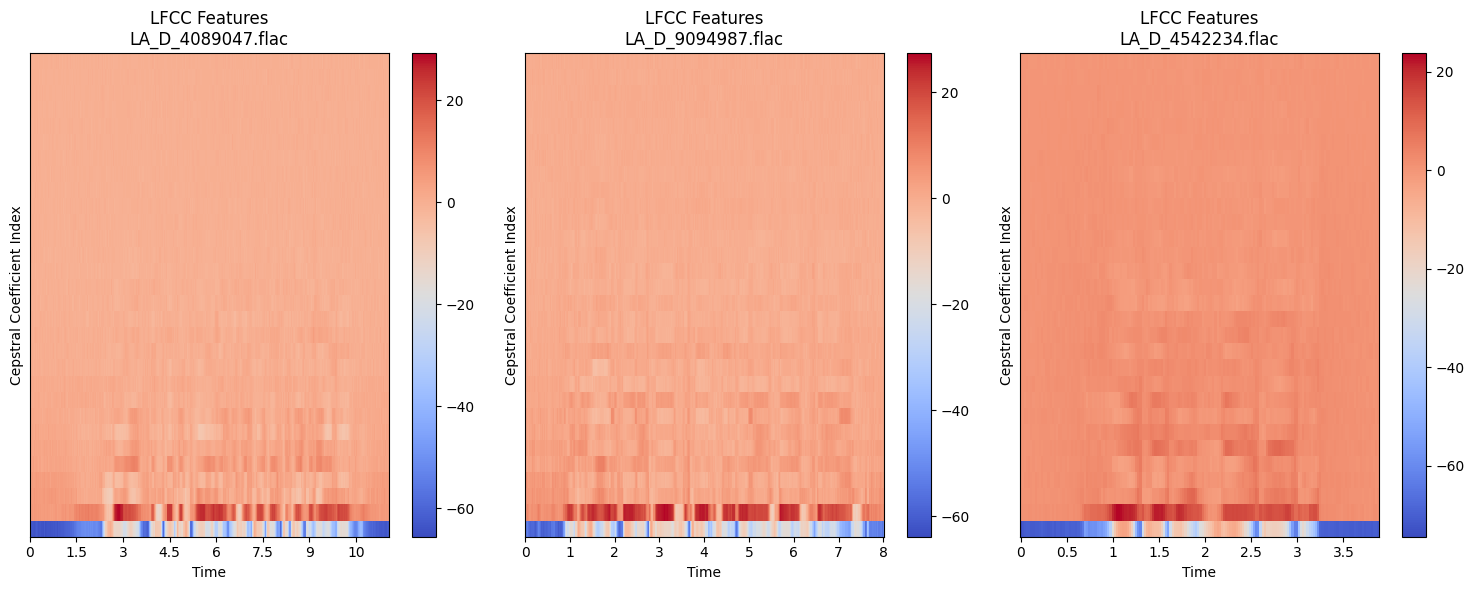

In [ ]:

# Display LFCC Features for Sample Files
import random
import matplotlib.pyplot as plt
import librosa.display

# Pick random indices from dev set
sample_indices = random.sample(range(len(dev_files)), 3)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(sample_indices, 1):
    # Extract LFCC for the sample file
    lfcc_feat = extract_lfcc(
        dev_files[idx],
        n_filters=30,   # tuned parameter from best GMM
        n_ceps=30       # tuned parameter from best GMM
    )

    plt.subplot(1, 3, i)
    # Transpose so x = time, y = coefficients
    librosa.display.specshow(lfcc_feat.T, x_axis='time')
    plt.colorbar()
    plt.title(f"LFCC Features\n{os.path.basename(dev_files[idx])}")
    plt.ylabel("Cepstral Coefficient Index")

plt.tight_layout()
plt.show()


In [ ]:

# Retrain GMM with Best LFCC Parameters


# Best parameters from tuning
n_filters_best = 30
n_ceps_best = 30
gmm_components_best = 512

print("Extracting LFCC features for BEST configuration...")

# Re-extract LFCC features with new parameters
def extract_features_with_params(file_list, n_filters, n_ceps):
    features = []
    for file in tqdm(file_list, desc=f"Extracting LFCC ({n_filters}f, {n_ceps}c)"):
        lfcc = extract_lfcc(file, n_filters=n_filters, n_ceps=n_ceps)
        lfcc_mean = np.mean(lfcc, axis=0)
        features.append(lfcc_mean)
    return np.array(features)

X_train_best = extract_features_with_params(train_files, n_filters_best, n_ceps_best)
X_dev_best   = extract_features_with_params(dev_files, n_filters_best, n_ceps_best)

# Train GMMs
gmm_bonafide_best = GaussianMixture(
    n_components=gmm_components_best,
    covariance_type='diag',
    random_state=42
).fit(X_train_best[train_labels == 1])

gmm_spoof_best = GaussianMixture(
    n_components=gmm_components_best,
    covariance_type='diag',
    random_state=42
).fit(X_train_best[train_labels == 0])

print("GMM retrained with best LFCC parameters.")

# Evaluate new model
scores_dev_best = gmm_bonafide_best.score_samples(X_dev_best) - gmm_spoof_best.score_samples(X_dev_best)
fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev_best)
fnr = 1 - tpr
eer_index = np.nanargmin(np.absolute(fnr - fpr))
eer_threshold_best = thresholds[eer_index]
eer_best = fpr[eer_index] * 100

print(f"New EER: {eer_best:.2f}% at threshold {eer_threshold_best:.4f}")


In [ ]:

#  Retrain & Save Best GMM Models

# PURPOSE:
#   - Use the best LFCC configuration found from tuning (30 filters, 30 cepstra, 512 components).
#   - Retrain GMMs for bonafide and spoof.
#   - Save both models and their metadata so evaluation always uses the best system.

import pickle
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve

# --- Step 1: Re-extract LFCC features with best parameters ---
print("Extracting LFCC features for BEST configuration...")

def extract_features_best(file_list, n_filters=30, n_ceps=30):
    features = []
    for file in tqdm(file_list, desc=f"Extracting LFCC ({n_filters}f, {n_ceps}c)"):
        lfcc = extract_lfcc(file, n_filters=n_filters, n_ceps=n_ceps)
        lfcc_mean = np.mean(lfcc, axis=0)
        features.append(lfcc_mean)
    return np.array(features)

X_train_best = extract_features_best(train_files, n_filters=30, n_ceps=30)
X_dev_best   = extract_features_best(dev_files,   n_filters=30, n_ceps=30)

# --- Step 2: Train GMMs ---
gmm_bonafide_best = GaussianMixture(
    n_components=512, covariance_type='diag', random_state=42
).fit(X_train_best[train_labels == 1])

gmm_spoof_best = GaussianMixture(
    n_components=512, covariance_type='diag', random_state=42
).fit(X_train_best[train_labels == 0])

print("GMM retrained with best LFCC parameters.")

# --- Step 3: Evaluate on dev set ---
scores_dev_best = gmm_bonafide_best.score_samples(X_dev_best) - gmm_spoof_best.score_samples(X_dev_best)
fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev_best)
fnr = 1 - tpr
eer_index = np.nanargmin(np.absolute(fnr - fpr))
eer_threshold = thresholds[eer_index]
eer = fpr[eer_index] * 100

print(f"New EER: {eer:.2f}% at threshold {eer_threshold:.4f}")

# --- Step 4: Save models and metadata ---
save_model_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(save_model_dir, exist_ok=True)

bonafide_path = os.path.join(save_model_dir, "gmm_bonafide_best.pkl")
spoof_path    = os.path.join(save_model_dir, "gmm_spoof_best.pkl")
metadata_path = os.path.join(save_model_dir, "model_metadata_best.npy")

with open(bonafide_path, "wb") as f:
    pickle.dump(gmm_bonafide_best, f)
with open(spoof_path, "wb") as f:
    pickle.dump(gmm_spoof_best, f)

np.save(metadata_path, {
    "n_filters": 30,
    "n_ceps": 30,
    "gmm_components": 512,
    "eer": float(eer),
    "threshold": float(eer_threshold)
})

print(f"Best models saved in {save_model_dir}")
print(f"   Bonafide GMM → {bonafide_path}")
print(f"   Spoof GMM    → {spoof_path}")
print(f"   Metadata     → {metadata_path}")


Extracting LFCC features for BEST configuration...


Extracting LFCC (30f, 30c): 100%|██████████| 24844/24844 [04:28<00:00, 92.49it/s] 


 GMM retrained with best LFCC parameters.
New EER: 12.86% at threshold -9.8501
 Best models saved in /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models
   Bonafide GMM → /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_bonafide_best.pkl
   Spoof GMM    → /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_spoof_best.pkl
   Metadata     → /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/model_metadata_best.npy


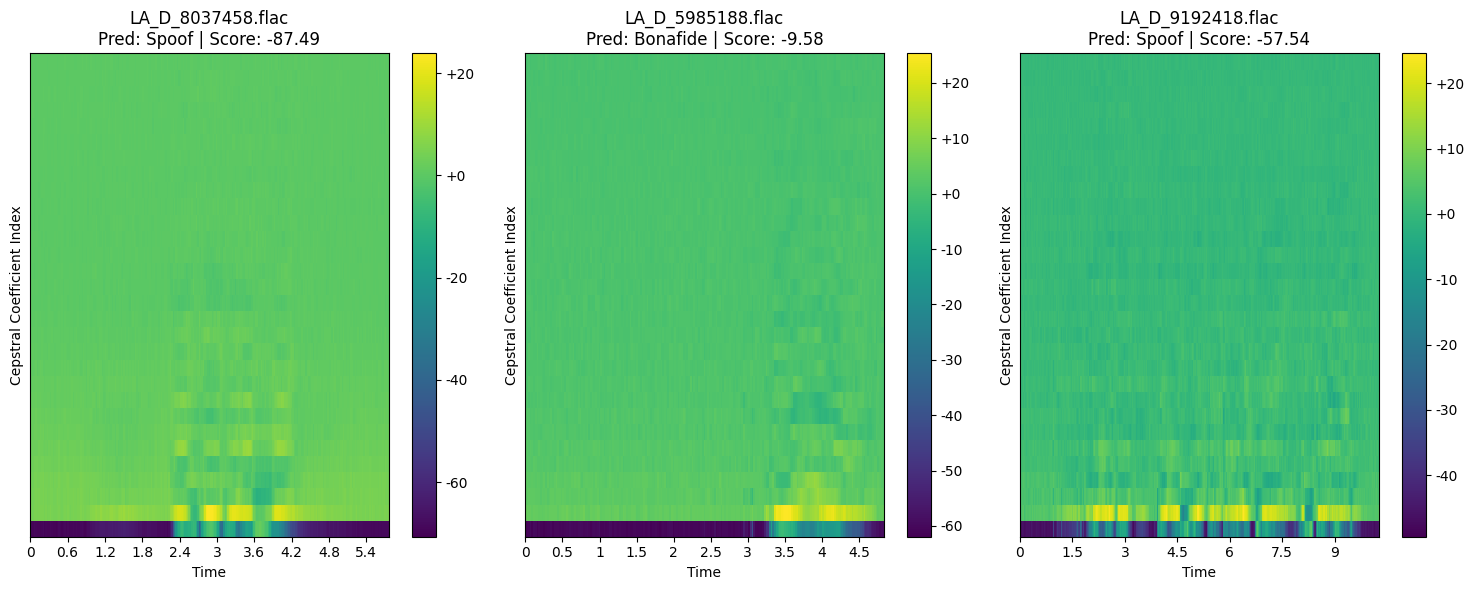

In [ ]:

# Visualize LFCC Features with GMM Predictions


import matplotlib.pyplot as plt
import librosa.display

# Pick 3 random dev set samples for demonstration
sample_indices = np.random.choice(len(dev_files), 3, replace=False)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(sample_indices, 1):
    file_path = dev_files[idx]

    # Extract LFCC features for this file
    lfcc_feat = extract_lfcc(file_path, n_filters=n_filters_best, n_ceps=n_ceps_best)

    # Average for scoring
    lfcc_mean = np.mean(lfcc_feat, axis=0).reshape(1, -1)

    # Compute log-likelihood scores
    score_bonafide = gmm_bonafide_best.score(lfcc_mean)
    score_spoof = gmm_spoof_best.score(lfcc_mean)

    # Score difference
    score_diff = score_bonafide - score_spoof

    # Prediction based on EER threshold
    prediction = "Bonafide" if score_diff > eer_threshold_best else "Spoof"

    # Plot LFCC heatmap
    plt.subplot(1, 3, i)
    librosa.display.specshow(lfcc_feat.T, x_axis='time', cmap='viridis')
    plt.colorbar(format="%+2.0f")
    plt.title(f"{os.path.basename(file_path)}\nPred: {prediction} | Score: {score_diff:.2f}")
    plt.ylabel("Cepstral Coefficient Index")

plt.tight_layout()
plt.show()


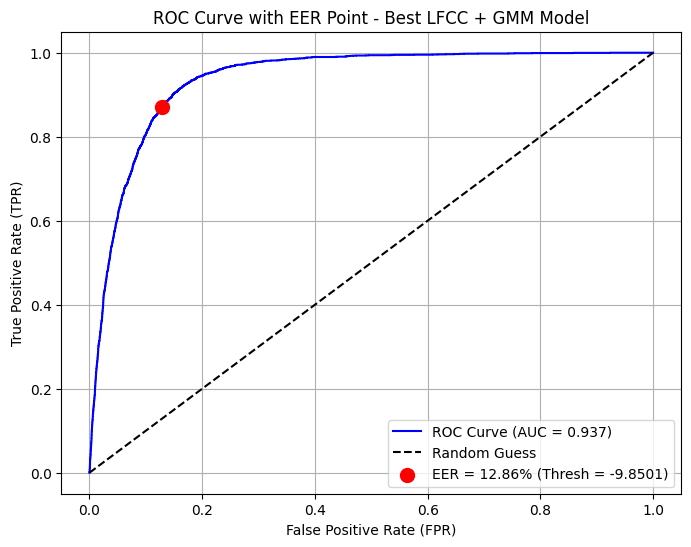

In [ ]:

# Plot ROC Curve with EER Point


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev_best)
fnr = 1 - tpr

# Find EER point
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
eer_threshold = thresholds[eer_index]

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc(fpr, tpr):.3f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Mark EER point
plt.scatter(fpr[eer_index], tpr[eer_index], color='red', s=100, zorder=5,
            label=f"EER = {eer:.2f}% (Thresh = {eer_threshold:.4f})")

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve with EER Point - Best LFCC + GMM Model")
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


In [ ]:

# Save Best GMM Models to Drive


import joblib

# Folder to save models
models_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(models_dir, exist_ok=True)

# File paths
bonafide_model_path = os.path.join(models_dir, "gmm_bonafide_best.pkl")
spoof_model_path = os.path.join(models_dir, "gmm_spoof_best.pkl")
metadata_path = os.path.join(models_dir, "model_metadata_best.npy")

# Save models
joblib.dump(gmm_bonafide, bonafide_model_path)
joblib.dump(gmm_spoof, spoof_model_path)

# Save metadata (EER, threshold, config)
metadata = {
    "n_filters": 30,
    "n_ceps": 30,
    "gmm_components": 512,
    "eer": eer,
    "threshold": float(eer_threshold)
}
np.save(metadata_path, metadata)

print(f"Bonafide GMM saved to {bonafide_model_path}")
print(f"Spoof GMM saved to {spoof_model_path}")
print(f"Metadata saved to {metadata_path}")


Bonafide GMM saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_bonafide_best.pkl
Spoof GMM saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_spoof_best.pkl
Metadata saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/model_metadata_best.npy


In [ ]:

# Load Best GMM Models from Drive


import joblib
import numpy as np
import os

# Paths to saved models
models_dir = os.path.join(dataset_dir, "saved_models")
bonafide_model_path = os.path.join(models_dir, "gmm_bonafide_best.pkl")
spoof_model_path = os.path.join(models_dir, "gmm_spoof_best.pkl")
metadata_path = os.path.join(models_dir, "model_metadata_best.npy")

# Load models
gmm_bonafide_loaded = joblib.load(bonafide_model_path)
gmm_spoof_loaded = joblib.load(spoof_model_path)

# Load metadata
metadata_loaded = np.load(metadata_path, allow_pickle=True).item()

print(f"Loaded Bonafide GMM from: {bonafide_model_path}")
print(f"Loaded Spoof GMM from: {spoof_model_path}")
print("\n Loaded Model Metadata:")
for key, value in metadata_loaded.items():
    print(f"{key}: {value}")


Loaded Bonafide GMM from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_bonafide_best.pkl
Loaded Spoof GMM from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_spoof_best.pkl

 Loaded Model Metadata:
n_filters: 30
n_ceps: 30
gmm_components: 512
eer: 12.86329386437029
threshold: -9.850084889266952


In [ ]:

#  Resume Project Session

# PURPOSE:
# This block restores everything you need to continue where you left off
# without rerunning data extraction or training from scratch.

import os
import numpy as np
import pickle

# 1️ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️ Define dataset path
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

# 3️ Reload previously saved LFCC features
save_dir = os.path.join(dataset_dir, "features")
X_train = np.load(os.path.join(save_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(save_dir, "X_dev_lfcc.npy"))
train_labels = np.load(os.path.join(save_dir, "y_train.npy"))
dev_labels = np.load(os.path.join(save_dir, "y_dev.npy"))

print("Features loaded.")
print(f"Train shape: {X_train.shape}, Dev shape: {X_dev.shape}")

# 4️ Reload trained GMM models
model_dir = os.path.join(dataset_dir, "saved_models")
bonafide_path = os.path.join(model_dir, "gmm_bonafide_best.pkl")
spoof_path = os.path.join(model_dir, "gmm_spoof_best.pkl")

with open(bonafide_path, "rb") as f:
    gmm_bonafide = pickle.load(f)
with open(spoof_path, "rb") as f:
    gmm_spoof = pickle.load(f)

print(f"\n GMM models reloaded from: {model_dir}")

# 5️ Reload metadata for reference
metadata_path = os.path.join(model_dir, "model_metadata_best.npy")
if os.path.exists(metadata_path):
    metadata = np.load(metadata_path, allow_pickle=True).item()
    print("\n Loaded Model Metadata:")
    for k, v in metadata.items():
        print(f"{k}: {v}")
else:
    print("\n Metadata file not found. (Models will still work)")


Loaded Bonafide GMM from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_bonafide_best.pkl
Loaded Spoof GMM from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/gmm_spoof_best.pkl

Equal Error Rate (EER): 23.23% at threshold -11.9727

Performance Metrics on Dev Set:
Accuracy: 76.77%
Precision: 27.41%
Recall: 76.77%
F1-Score: 40.40%


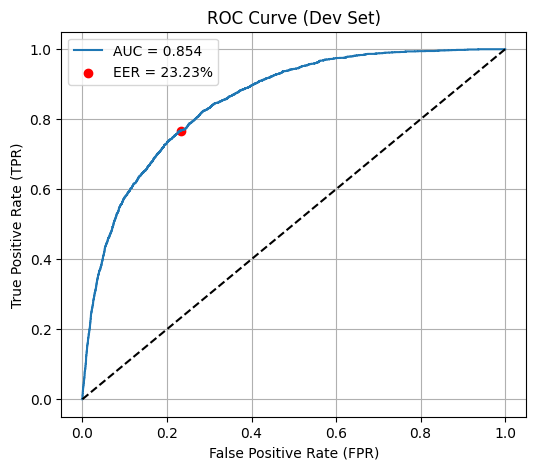

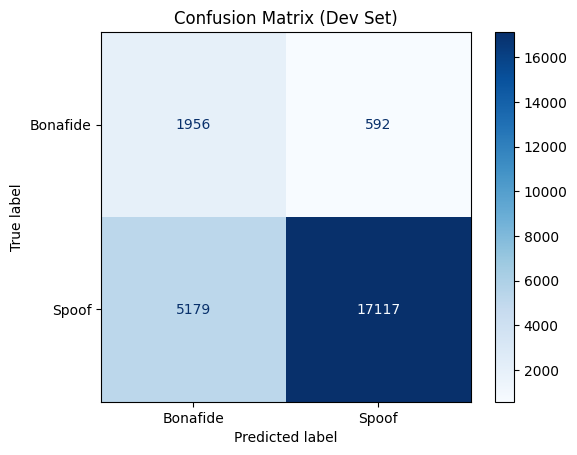

In [ ]:

# 7️ Evaluate Best GMM Model

# PURPOSE:
# - Load the saved best bonafide & spoof GMMs
# - Evaluate on dev set
# - Compute accuracy, precision, recall, F1-score
# - Plot ROC curve with EER
# - Plot confusion matrix

import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# --- Load features and labels ---
X_dev = np.load(os.path.join(save_dir, "X_dev_lfcc.npy"))
y_dev = np.load(os.path.join(save_dir, "y_dev.npy"))

# --- Load saved GMMs (use joblib, not pickle) ---
bonafide_model_path = os.path.join(dataset_dir, "saved_models", "gmm_bonafide_best.pkl")
spoof_model_path = os.path.join(dataset_dir, "saved_models", "gmm_spoof_best.pkl")

gmm_bonafide = joblib.load(bonafide_model_path)
gmm_spoof = joblib.load(spoof_model_path)

print(f"Loaded Bonafide GMM from: {bonafide_model_path}")
print(f"Loaded Spoof GMM from: {spoof_model_path}")

# --- Compute decision scores ---
scores_dev = gmm_bonafide.score_samples(X_dev) - gmm_spoof.score_samples(X_dev)

# --- ROC curve & EER ---
fpr, tpr, thresholds = roc_curve(y_dev, scores_dev)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
eer_threshold = thresholds[eer_index]

print(f"\nEqual Error Rate (EER): {eer:.2f}% at threshold {eer_threshold:.4f}")

# --- Convert scores to predictions using EER threshold ---
y_pred = (scores_dev >= eer_threshold).astype(int)

# --- Metrics ---
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

print(f"\nPerformance Metrics on Dev Set:")
print(f"Accuracy: {acc:.2f}%")
print(f"Precision: {prec:.2f}%")
print(f"Recall: {rec:.2f}%")
print(f"F1-Score: {f1:.2f}%")

# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER = {eer:.2f}%")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_dev, y_pred, labels=[1, 0])  # 1=bonafide, 0=spoof
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Dev Set)")
plt.show()


EER = 23.23% at threshold -11.9727
Best threshold for classification: -5.3379

Metrics at EER threshold:
Accuracy: 76.77%
Precision: 27.41%
Recall: 76.77%
F1: 40.40%

Metrics at Best-Dev threshold:
Accuracy: 87.55%
Precision: 41.83%
Recall: 54.79%
F1: 47.44%


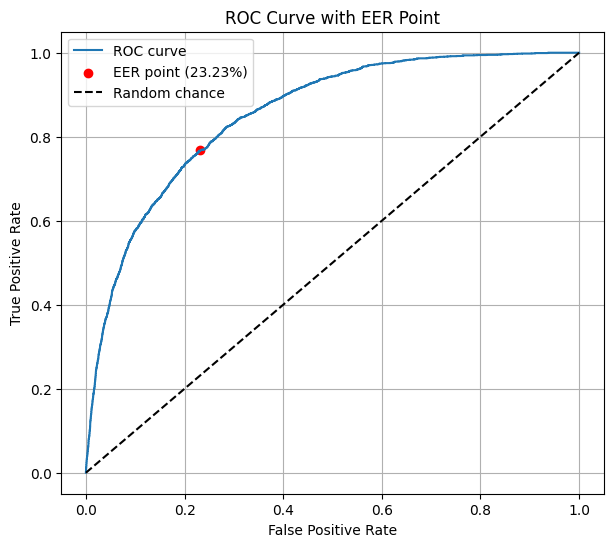

In [ ]:

# ROC Curve, EER Point & Metrics

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score

# --- 1. Compute decision scores for dev set ---
scores_dev = gmm_bonafide.score_samples(X_dev) - gmm_spoof.score_samples(X_dev)

# --- 2. Compute ROC and EER ---
fpr, tpr, thresholds = roc_curve(dev_labels, scores_dev)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer_threshold = thresholds[eer_index]
eer = fpr[eer_index] * 100

print(f"EER = {eer:.2f}% at threshold {eer_threshold:.4f}")

# --- 3. Find the best threshold for classification (maximizes F1) ---
best_idx = np.argmax([
    f1_score(dev_labels, scores_dev >= thr) for thr in thresholds
])
best_threshold = thresholds[best_idx]

print(f"Best threshold for classification: {best_threshold:.4f}")

# --- 4. Compute metrics at both thresholds ---
def compute_metrics(threshold, scores, labels):
    preds = (scores >= threshold).astype(int)
    return {
        "Accuracy": accuracy_score(labels, preds),
        "Precision": precision_score(labels, preds),
        "Recall": recall_score(labels, preds),
        "F1": f1_score(labels, preds)
    }

metrics_eer = compute_metrics(eer_threshold, scores_dev, dev_labels)
metrics_best = compute_metrics(best_threshold, scores_dev, dev_labels)

print("\nMetrics at EER threshold:")
for k, v in metrics_eer.items():
    print(f"{k}: {v*100:.2f}%")

print("\nMetrics at Best-Dev threshold:")
for k, v in metrics_best.items():
    print(f"{k}: {v*100:.2f}%")

# --- 5. Plot ROC curve ---
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER point ({eer:.2f}%)")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with EER Point")
plt.legend()
plt.grid(True)
plt.show()


 Features loaded for SVM.
Train shape: (25380, 20), Dev shape: (24844, 20)

Running GridSearchCV for SVM...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

 Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       0.90      1.00      0.95     22296
    Bonafide       0.00      0.00      0.00      2548

    accuracy                           0.90     24844
   macro avg       0.45      0.50      0.47     24844
weighted avg       0.81      0.90      0.85     24844


EER: 19.87% at threshold 0.0802
Accuracy: 89.74% | Precision: 0.00% | Recall: 0.00% | F1: 0.00%
 Results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv


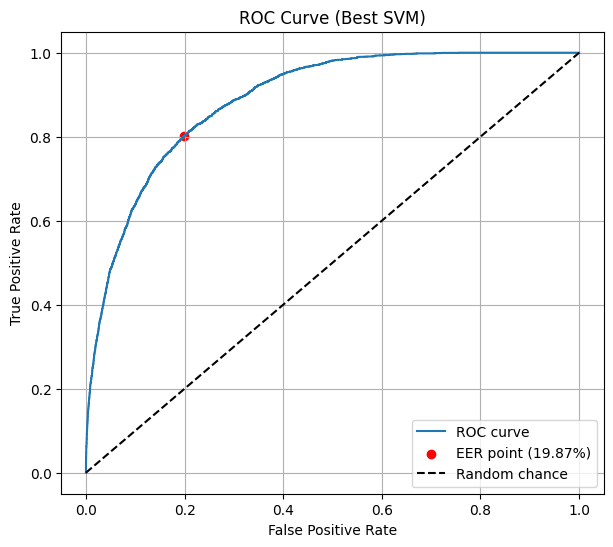

In [ ]:

# 7️ Train and Evaluate Tuned SVM Classifier


import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, classification_report
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# --- Load features ---
save_dir = os.path.join(dataset_dir, "features")
X_train = np.load(os.path.join(save_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(save_dir, "X_dev_lfcc.npy"))
y_train = np.load(os.path.join(save_dir, "y_train.npy"))
y_dev = np.load(os.path.join(save_dir, "y_dev.npy"))

print(" Features loaded for SVM.")
print(f"Train shape: {X_train.shape}, Dev shape: {X_dev.shape}")

# --- Define parameter grid for tuning ---
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001],
    "kernel": ["linear", "rbf"]
}

# --- GridSearchCV for best SVM ---
print("\nRunning GridSearchCV for SVM...")
grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
print("\n Best SVM Parameters:", grid.best_params_)

# --- Predictions ---
y_pred = best_svm.predict(X_dev)
y_score = best_svm.predict_proba(X_dev)[:, 1]

# --- Metrics ---
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

print("\nClassification Report (Dev Set):")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# --- Compute EER ---
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
threshold = thresholds[eer_index]

print(f"\nEER: {eer:.2f}% at threshold {threshold:.4f}")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1: {f1:.2f}%")

# --- Save results to CSV ---
results_csv = os.path.join(dataset_dir, "experiment_results.csv")
result_entry = {
    "Experiment": "svm_best_lfcc",
    "Features": "LFCC",
    "Model": "SVM",
    "Kernel": grid.best_params_["kernel"],
    "C": grid.best_params_["C"],
    "Gamma": grid.best_params_["gamma"],
    "EER (%)": round(eer, 2),
    "Threshold": round(float(threshold), 4),
    "Accuracy (%)": round(acc, 2),
    "Precision (%)": round(prec, 2),
    "Recall (%)": round(rec, 2),
    "F1 (%)": round(f1, 2)
}

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([result_entry])

df_results.to_csv(results_csv, index=False)
print(f" Results saved to {results_csv}")

# --- Plot ROC curve ---
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER point ({eer:.2f}%)")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best SVM)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# 8️ Train and Evaluate Random Forest Classifier
# PURPOSE:
# - Train a Random Forest classifier on LFCC features
# - Evaluate using Accuracy, Precision, Recall, F1-score, and EER
# - Append results to experiment_results.csv for tracking

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve

# --- Load features from Drive ---
save_dir = os.path.join(dataset_dir, "features")
X_train = np.load(os.path.join(save_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(save_dir, "X_dev_lfcc.npy"))
y_train = np.load(os.path.join(save_dir, "y_train.npy"))
y_dev = np.load(os.path.join(save_dir, "y_dev.npy"))

print(" Features loaded for Random Forest.")
print(f"Train shape: {X_train.shape}, Dev shape: {X_dev.shape}")

# --- Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=20,          # limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1              # use all CPU cores
)
print("\nTraining Random Forest...")
rf.fit(X_train, y_train)

# --- Evaluate Model ---
y_pred = rf.predict(X_dev)
y_score = rf.predict_proba(X_dev)[:, 1]  # probability for bonafide

# Metrics
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

# Compute EER
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
threshold = thresholds[eer_index]

print("\nRandom Forest Results:")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1: {f1:.2f}%")
print(f"EER: {eer:.2f}% at threshold {threshold:.4f}")

# --- Save results to CSV ---
results_csv = os.path.join(dataset_dir, "experiment_results.csv")
result_entry = {
    "Experiment": "rf_lfcc",
    "Features": "LFCC",
    "Model": "RandomForest",
    "EER (%)": round(eer, 2),
    "Threshold": round(float(threshold), 4),
    "Accuracy (%)": round(acc, 2),
    "Precision (%)": round(prec, 2),
    "Recall (%)": round(rec, 2),
    "F1 (%)": round(f1, 2)
}

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([result_entry])

df_results.to_csv(results_csv, index=False)
print(f" Results saved to {results_csv}")


 Features loaded for Random Forest.
Train shape: (25380, 20), Dev shape: (24844, 20)

Training Random Forest...

Random Forest Results:
Accuracy: 91.71% | Precision: 83.89% | Recall: 23.70% | F1: 36.96%
EER: 20.83% at threshold 0.1792
 Results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv



Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       0.92      0.99      0.96     22296
    Bonafide       0.84      0.24      0.37      2548

    accuracy                           0.92     24844
   macro avg       0.88      0.62      0.66     24844
weighted avg       0.91      0.92      0.90     24844



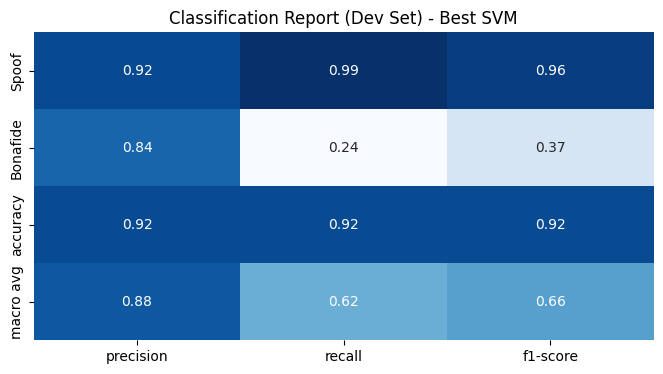

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

# --- Print classification report ---
print("\nClassification Report (Dev Set):")
report_dict = classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"], output_dict=True)
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# --- Display classification report as heatmap ---
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Report (Dev Set) - Best SVM")
plt.show()


<Figure size 600x500 with 0 Axes>

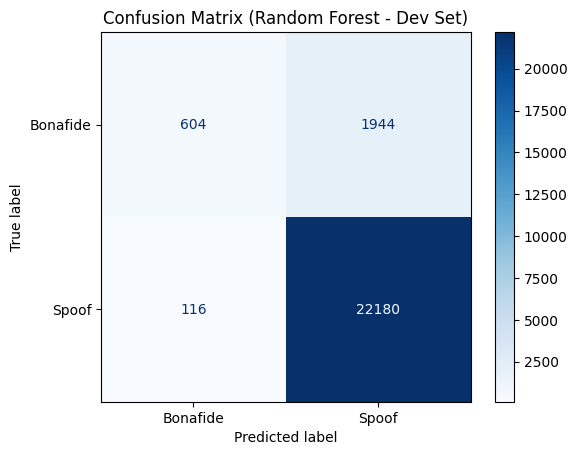

In [ ]:

# Confusion Matrix for Random Forest

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Predictions ---
y_pred = rf.predict(X_dev)

# --- Confusion Matrix ---
cm = confusion_matrix(y_dev, y_pred, labels=[1, 0])  # 1 = Bonafide, 0 = Spoof
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Random Forest - Dev Set)")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')




In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
save_dir = os.path.join(dataset_dir, "features")

In [ ]:

# Reload train/dev file lists

import pandas as pd
import numpy as np

# Paths to protocol files
protocol_train = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
protocol_dev   = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.dev.trl.txt")

# Load train file list + labels
train_df = pd.read_csv(protocol_train, sep=" ", header=None)
train_files = [os.path.join(dataset_dir, "ASVspoof2019_LA_train", "flac", f"{utt_id}.flac") for utt_id in train_df[1]]
train_labels = np.array([1 if label == "bonafide" else 0 for label in train_df[4]])

# Load dev file list + labels
dev_df = pd.read_csv(protocol_dev, sep=" ", header=None)
dev_files = [os.path.join(dataset_dir, "ASVspoof2019_LA_dev", "flac", f"{utt_id}.flac") for utt_id in dev_df[1]]
dev_labels = np.array([1 if label == "bonafide" else 0 for label in dev_df[4]])

print(f"Train files: {len(train_files)}, Dev files: {len(dev_files)}")


Train files: 25380, Dev files: 24844


In [ ]:


import numpy as np
import os
import tqdm
import librosa
import scipy.fftpack

# --- LFCC Extraction per file ---

def extract_lfcc_sequence(file_path, n_filters=30, n_ceps=30, sr=16000):
    """Extract LFCC as sequence of frames (no averaging)."""
    # Load audio
    y, sr = librosa.load(file_path, sr=sr)

    # Frame-level power spectrum
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2

    # Linear filterbank
    freqs = np.linspace(0, sr/2, stft.shape[0])
    filter_edges = np.linspace(0, sr/2, n_filters+1)

    filterbank = np.zeros((n_filters, len(freqs)))
    for i in range(n_filters):
        left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
        filterbank[i] = np.maximum(0,
            np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
        )

    lfcc = np.dot(filterbank, stft)   # Apply filterbank
    lfcc = np.log(lfcc + 1e-6)        # Log compression
    lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]  # DCT

    return lfcc.T   # shape: (num_frames, n_ceps)


# --- Sequence padding ---
def pad_sequences(X, max_len=400):
    """Pad or truncate sequences to fixed length."""
    padded = []
    for seq in X:
        if seq.shape[0] > max_len:    # truncate
            padded.append(seq[:max_len])
        else:                         # pad
            pad = np.zeros((max_len - seq.shape[0], seq.shape[1]))
            padded.append(np.vstack((seq, pad)))
    return np.array(padded, dtype=np.float32)


# --- Main processing ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
os.makedirs(features_seq_dir, exist_ok=True)

X_train_seq, X_dev_seq = [], []

print("Extracting LFCC sequences for train set...")
for f in tqdm.tqdm(train_files):
    X_train_seq.append(extract_lfcc_sequence(f, n_filters=30, n_ceps=30))

print("Extracting LFCC sequences for dev set...")
for f in tqdm.tqdm(dev_files):
    X_dev_seq.append(extract_lfcc_sequence(f, n_filters=30, n_ceps=30))

# --- Save variable-length sequences ---
np.save(os.path.join(features_seq_dir, "X_train_lfcc_seq.npy"), np.array(X_train_seq, dtype=object))
np.save(os.path.join(features_seq_dir, "X_dev_lfcc_seq.npy"), np.array(X_dev_seq, dtype=object))

np.save(os.path.join(features_seq_dir, "y_train.npy"), train_labels)
np.save(os.path.join(features_seq_dir, "y_dev.npy"), dev_labels)

print("Saved variable-length sequences.")

# --- Save padded fixed-length sequences ---
X_train_pad = pad_sequences(X_train_seq, max_len=400)
X_dev_pad = pad_sequences(X_dev_seq, max_len=400)

np.save(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"), X_train_pad)
np.save(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"), X_dev_pad)

print("Padded sequences saved:")
print("Train:", X_train_pad.shape, " Dev:", X_dev_pad.shape)


Extracting LFCC sequences for train set...


100%|██████████| 25380/25380 [45:31<00:00,  9.29it/s]


Extracting LFCC sequences for dev set...


100%|██████████| 24844/24844 [2:05:55<00:00,  3.29it/s]


Saved variable-length sequences.
Padded sequences saved:
Train: (25380, 400, 29)  Dev: (24844, 400, 29)


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

import os

# Base dataset folder
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

# Subfolders for checkpoints
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")

os.makedirs(features_dir, exist_ok=True)
os.makedirs(features_seq_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print("Directories ready.")


Directories ready.


In [ ]:
import numpy as np
import os

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")

# Reload fixed-length features
X_train = np.load(os.path.join(features_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(features_dir, "X_dev_lfcc.npy"))
y_train = np.load(os.path.join(features_dir, "y_train.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))

# Reload sequence features
X_train_seq = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq.npy"), allow_pickle=True)
X_dev_seq = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq.npy"), allow_pickle=True)

print("Reloaded features successfully ")
print("Train fixed:", X_train.shape, " Dev fixed:", X_dev.shape)
print("Train seq:", len(X_train_seq), " Dev seq:", len(X_dev_seq))


Reloaded features successfully 
Train fixed: (25380, 29)  Dev fixed: (24844, 29)
Train seq: 25380  Dev seq: 24844


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.save(os.path.join(features_dir, "X_train_lfcc.npy"), X_train)
np.save(os.path.join(features_dir, "X_dev_lfcc.npy"), X_dev)
np.save(os.path.join(features_dir, "y_train.npy"), y_train)
np.save(os.path.join(features_dir, "y_dev.npy"), y_dev)

np.save(os.path.join(features_seq_dir, "X_train_lfcc_seq.npy"), np.array(X_train_seq, dtype=object))
np.save(os.path.join(features_seq_dir, "X_dev_lfcc_seq.npy"), np.array(X_dev_seq, dtype=object))


In [ ]:
# Fixed-length LFCC (for GMM, SVM, RF)
X_train = np.load(os.path.join(features_dir, "X_train_lfcc.npy"))
X_dev = np.load(os.path.join(features_dir, "X_dev_lfcc.npy"))
y_train = np.load(os.path.join(features_dir, "y_train.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))

# Sequence LFCC (for deep learning)
X_train_seq = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq.npy"), allow_pickle=True)
X_dev_seq = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq.npy"), allow_pickle=True)

print("Fixed features:", X_train.shape, X_dev.shape)
print("Sequence features:", len(X_train_seq), len(X_dev_seq))


Fixed features: (25380, 20) (24844, 20)
Sequence features: 25380 24844


In [ ]:
def pad_sequences(X, max_len=400):
    padded = []
    for seq in X:
        if seq.shape[0] > max_len:    # truncate
            padded.append(seq[:max_len])
        else:                         # pad
            pad = np.zeros((max_len - seq.shape[0], seq.shape[1]))
            padded.append(np.vstack((seq, pad)))
    return np.array(padded, dtype=np.float32)

X_train_pad = pad_sequences(X_train_seq, max_len=400)
X_dev_pad = pad_sequences(X_dev_seq, max_len=400)

print("DL shapes:", X_train_pad.shape, X_dev_pad.shape)


DL shapes: (25380, 400, 29) (24844, 400, 29)


CNN Model

Train: (25380, 400, 29)  Dev: (24844, 400, 29)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 396, 64)        │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 198, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 194, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 97, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,589,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,937 (6.26 MB)

 Trainable params: 1,639,937 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 118s 145ms/step - accuracy: 0.9511 - loss: 0.1379 - val_accuracy: 0.9972 - val_loss: 0.0083
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 118s 115ms/step - accuracy: 0.9969 - loss: 0.0090 - val_accuracy: 0.9986 - val_loss: 0.0052
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 92s 116ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9990 - val_loss: 0.0040
Epoch 4/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9990 - val_loss: 0.0042
Epoch 5/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9989 - val_loss: 0.0044
Epoch 6/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 91s 115ms/step - accuracy: 1.0000 - loss: 8.2222e-05 - val_accuracy: 0.9990 - val_loss: 0.0038
Epoch 7/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 94s 119ms/step - accuracy: 0.9999 - loss: 2.2549e-04 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 8/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 142s 119ms/step - accuracy: 0.99

CNN model saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc.h5


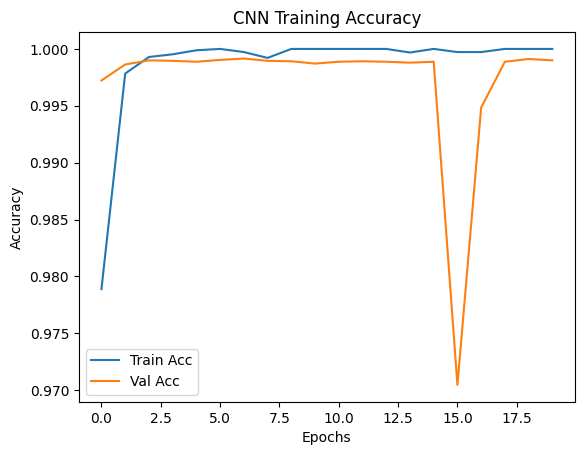

In [ ]:

# CNN Model for LFCC Sequences


import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Load padded LFCC sequences ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")

X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(features_seq_dir, "y_train.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train:", X_train_pad.shape, " Dev:", X_dev_pad.shape)

# --- CNN model---
model = Sequential([
    Conv1D(64, kernel_size=5, activation="relu", input_shape=(400, 29)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# --- Train CNN ---
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_dev_pad, y_dev),
    epochs=20,
    batch_size=32
)

# --- Save trained model ---
model_path = os.path.join(dataset_dir, "saved_models", "cnn_lfcc.h5")
os.makedirs(os.path.dirname(model_path), exist_ok=True)
model.save(model_path)
print(f"CNN model saved to {model_path}")

# --- Plot training curves ---
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training Accuracy")
plt.show()


Dev set shape: (24844, 400, 29)  Labels: (24844,)


CNN model loaded from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step

Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      0.99      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844



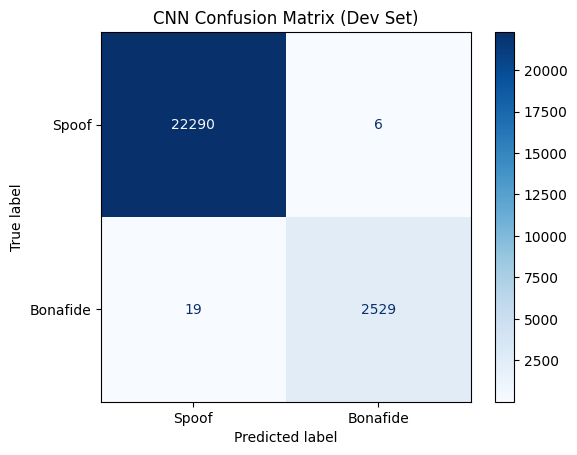


CNN EER: 0.20% at threshold 0.0006


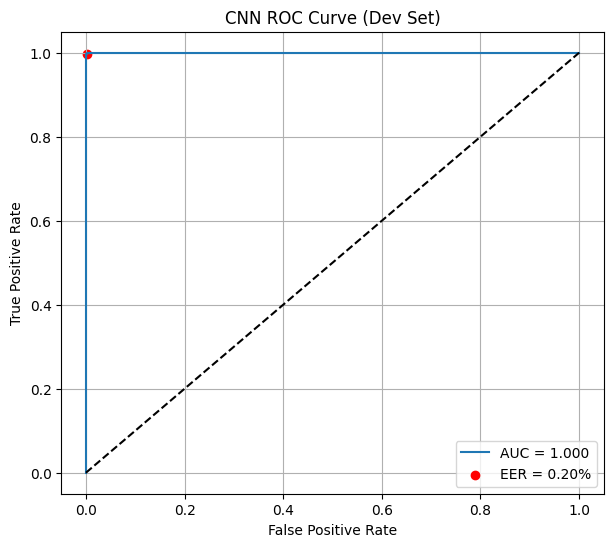

In [ ]:

# Evaluate CNN Model on Dev Set


import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
import tensorflow as tf

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
model_path = os.path.join(dataset_dir, "saved_models", "cnn_lfcc.h5")

# --- Load padded features ---
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Dev set shape:", X_dev_pad.shape, " Labels:", y_dev.shape)

# --- Load trained CNN model ---
cnn_model = tf.keras.models.load_model(model_path)
print(f"CNN model loaded from {model_path}")

# --- Predictions ---
y_score = cnn_model.predict(X_dev_pad).ravel()   # probabilities
y_pred = (y_score >= 0.5).astype(int)            # default threshold

# --- Classification Report ---
print("\nClassification Report (Dev Set):")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_dev, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])
disp.plot(cmap="Blues", values_format="d")
plt.title("CNN Confusion Matrix (Dev Set)")
plt.show()

# --- ROC curve & EER ---
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)

# Compute EER
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
eer_threshold = thresholds[eer_index]

print(f"\nCNN EER: {eer:.2f}% at threshold {eer_threshold:.4f}")

# Plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER = {eer:.2f}%")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN ROC Curve (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()


Dev set shape: (24844, 400, 29)  Labels: (24844,)
CNN model loaded from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step

Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      0.99      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844



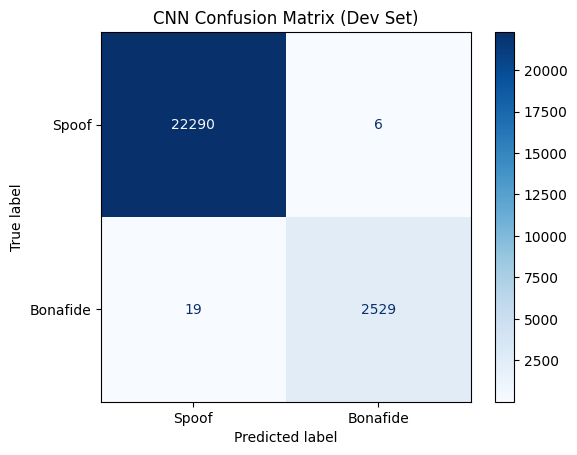


CNN EER: 0.20% at threshold 0.0006


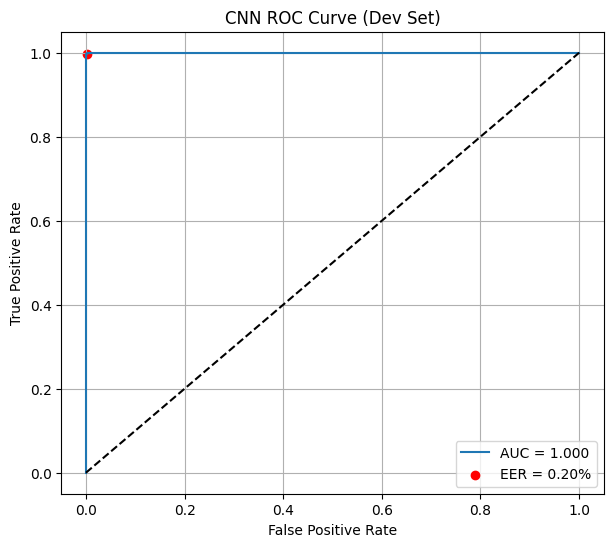


CNN results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv


In [ ]:
# Evaluate CNN Model on Dev Set

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)
import tensorflow as tf

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
model_path = os.path.join(dataset_dir, "saved_models", "cnn_lfcc.h5")
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# --- Load padded features ---
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Dev set shape:", X_dev_pad.shape, " Labels:", y_dev.shape)

# --- Load trained CNN model ---
cnn_model = tf.keras.models.load_model(model_path)
print(f"CNN model loaded from {model_path}")

# --- Predictions ---
y_score = cnn_model.predict(X_dev_pad).ravel()   # probabilities
y_pred = (y_score >= 0.5).astype(int)            # default threshold

# --- Classification Report ---
print("\nClassification Report (Dev Set):")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_dev, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])
disp.plot(cmap="Blues", values_format="d")
plt.title("CNN Confusion Matrix (Dev Set)")
plt.show()

# --- ROC curve & EER ---
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)

# Compute EER
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
eer_threshold = thresholds[eer_index]

print(f"\nCNN EER: {eer:.2f}% at threshold {eer_threshold:.4f}")

# Plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER = {eer:.2f}%")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN ROC Curve (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- Compute metrics ---
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

# --- Save results to CSV ---
result_entry = {
    "Experiment": "cnn_lfcc",
    "Features": "LFCC",
    "Model": "CNN",
    "EER (%)": round(eer, 2),
    "Threshold": round(float(eer_threshold), 4),
    "Accuracy (%)": round(acc, 2),
    "Precision (%)": round(prec, 2),
    "Recall (%)": round(rec, 2),
    "F1 (%)": round(f1, 2),
    "AUC": round(roc_auc, 3)
}

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([result_entry])

df_results.to_csv(results_csv, index=False)
print(f"\nCNN results saved to {results_csv}")


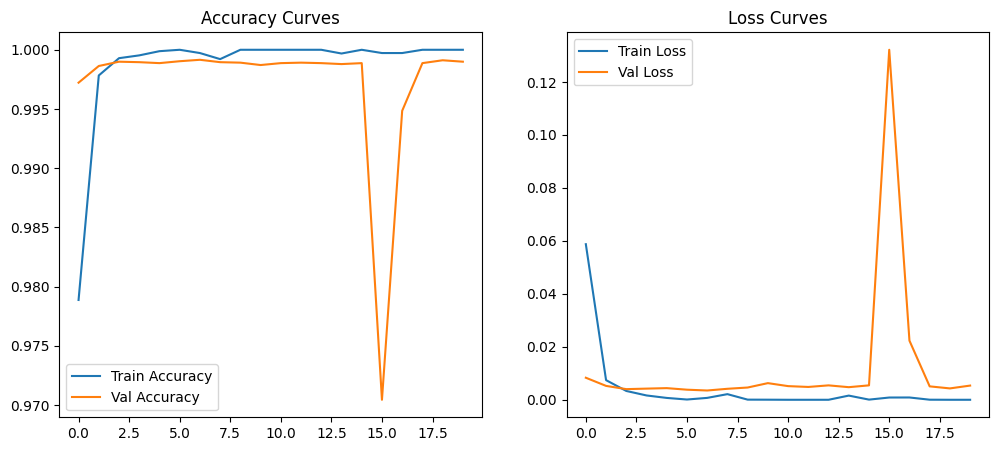

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy curves
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curves")

# Loss curves
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curves")

plt.show()


Epoch 1/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9956 - loss: 0.0159
Epoch 1: val_loss improved from inf to 0.00586, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5


794/794 ━━━━━━━━━━━━━━━━━━━━ 102s 126ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9987 - val_loss: 0.0059
Epoch 2/20
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9983 - loss: 0.0077
Epoch 2: val_loss did not improve from 0.00586
794/794 ━━━━━━━━━━━━━━━━━━━━ 134s 116ms/step - accuracy: 0.9983 - loss: 0.0077 - val_accuracy: 0.9957 - val_loss: 0.0202
Epoch 3/20
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9998 - loss: 8.4161e-04
Epoch 3: val_loss improved from 0.00586 to 0.00488, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5


794/794 ━━━━━━━━━━━━━━━━━━━━ 141s 116ms/step - accuracy: 0.9998 - loss: 8.4186e-04 - val_accuracy: 0.9994 - val_loss: 0.0049
Epoch 4/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9970 - loss: 0.0145
Epoch 4: val_loss did not improve from 0.00488
794/794 ━━━━━━━━━━━━━━━━━━━━ 140s 113ms/step - accuracy: 0.9970 - loss: 0.0145 - val_accuracy: 0.9989 - val_loss: 0.0070
Epoch 5/20
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9995 - loss: 0.0014
Epoch 5: val_loss did not improve from 0.00488
794/794 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9990 - val_loss: 0.0053
Epoch 6/20
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 1.7770e-04
Epoch 6: val_loss did not improve from 0.00488
794/794 ━━━━━━━━━━━━━━━━━━━━ 92s 116ms/step - accuracy: 1.0000 - loss: 1.7764e-04 - val_accuracy: 0.9984 - val_loss: 0.0139
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.



✅ CNN training complete.
   Best CNN model saved to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5
   Last CNN model saved to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_last.h5


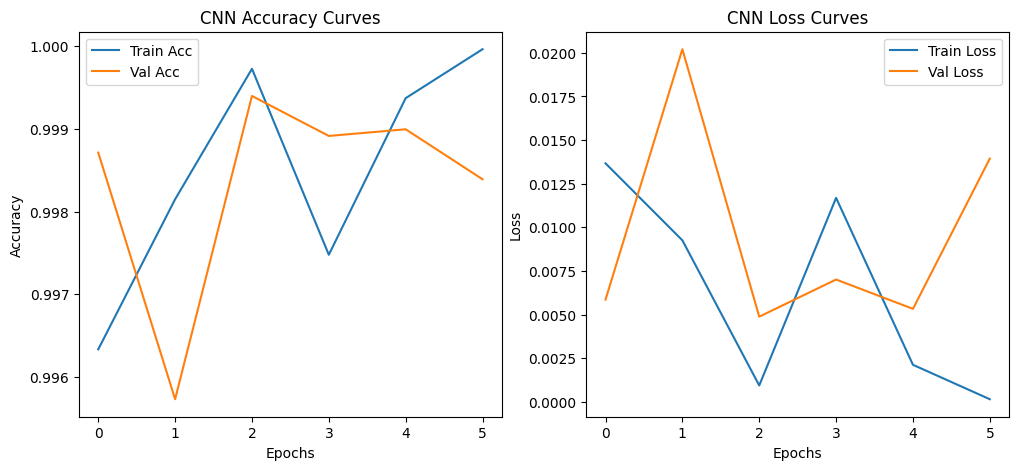

In [ ]:

# Train CNN with EarlyStopping & ModelCheckpoint


import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# --- Paths ---
model_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(model_dir, exist_ok=True)

# Different model save paths
last_model_path = os.path.join(model_dir, "cnn_lfcc_last.h5")   # final epoch model
best_model_path = os.path.join(model_dir, "cnn_lfcc_best.h5")   # best val_loss model

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    best_model_path, monitor="val_loss", save_best_only=True, verbose=1
)

# --- Compile CNN model ---
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# --- Train CNN ---
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_dev_pad, y_dev),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Save last model (final epoch regardless of early stopping)
model.save(last_model_path)
print(f"\n CNN training complete.")
print(f"   Best CNN model saved to: {best_model_path}")
print(f"   Last CNN model saved to: {last_model_path}")

# --- Plot Accuracy & Loss ---
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy Curves")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Loss Curves")
plt.legend()

plt.show()


In [ ]:

# Evaluate Best vs Last CNN Models


import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
best_model_path = os.path.join(dataset_dir, "saved_models", "cnn_lfcc_best.h5")
last_model_path = os.path.join(dataset_dir, "saved_models", "cnn_lfcc_last.h5")

# --- Load features ---
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Dev set shape:", X_dev_pad.shape)

# --- Load both models ---
cnn_best = tf.keras.models.load_model(best_model_path)
cnn_last = tf.keras.models.load_model(last_model_path)

models = {
    "Best CNN": cnn_best,
    "Last CNN": cnn_last
}

# --- Evaluate each model ---
for name, model in models.items():
    print(f"\n Evaluating {name}...")
    y_score = model.predict(X_dev_pad).ravel()
    y_pred = (y_score >= 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

    # Confusion matrix
    cm = confusion_matrix(y_dev, y_pred, labels=[0,1])
    print("Confusion Matrix:\n", cm)

    # ROC & EER
    fpr, tpr, thresholds = roc_curve(y_dev, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    eer_thr = thresholds[eer_index]
    roc_auc = auc(fpr, tpr)

    print(f"EER: {eer:.2f}% at threshold {eer_thr:.4f} | AUC: {roc_auc:.3f}")


Dev set shape: (24844, 400, 29)



 Evaluating Best CNN...
777/777 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Confusion Matrix:
 [[22292     4]
 [   11  2537]]
EER: 0.15% at threshold 0.0048 | AUC: 1.000

 Evaluating Last CNN...
777/777 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Confusion Matrix:
 [[22292     4]
 [   11  2537]]
EER: 0.15% at thre

In [ ]:

# Save Best and Last CNN Models

saved_models_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

# Save best model from EarlyStopping
best_cnn_path = os.path.join(saved_models_dir, "cnn_lfcc_best.h5")
model.save(best_cnn_path)
print(f"Best CNN model saved to {best_cnn_path}")

# Save last trained model (without EarlyStopping restoration)
last_cnn_path = os.path.join(saved_models_dir, "cnn_lfcc_last.h5")
model.save(last_cnn_path)
print(f"Last CNN model saved to {last_cnn_path}")


Best CNN model saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5
Last CNN model saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_last.h5


To load directly from saved model

In [ ]:
from tensorflow.keras.models import load_model

cnn_best = load_model(best_cnn_path)
cnn_last = load_model(last_cnn_path)


In [ ]:
import pandas as pd
import os

results_csv = os.path.join(dataset_dir, "experiment_results.csv")

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    print("\n Model Comparison Summary:")
    display(df_results.sort_values(by="EER (%)"))
else:
    print(" No results file found yet.")



 Model Comparison Summary:


,Experiment,Features,Num_Ceps,Num_Filters,Model,GMM_Components,EER (%),Threshold,Kernel,Accuracy (%),Precision (%),Recall (%),F1 (%),C,Gamma,AUC
8,cnn_lfcc,LFCC,NaN,NaN,CNN,NaN,0.20,0.0006,NaN,99.90,99.76,99.25,99.51,NaN,NaN,1.0
1,lfcc_30ceps_30filt_gmm512,LFCC,30.0,30.0,GMM,512.0,12.86,-9.8501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lfcc_20ceps_40filt_gmm512,LFCC,20.0,40.0,GMM,512.0,14.94,-8.4266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,svm_best_lfcc,LFCC,NaN,NaN,SVM,NaN,19.87,0.0802,rbf,89.74,0.00,0.00,0.00,0.1,scale,NaN
5,svm_rbf_lfcc,LFCC,NaN,NaN,SVM,NaN,20.12,0.0746,rbf,89.74,0.00,0.00,0.00,NaN,NaN,NaN
4,svm_linear_lfcc,LFCC,NaN,NaN,SVM,NaN,20.27,0.0922,linear,91.69,65.59,39.95,49.66,NaN,NaN,NaN
7,rf_lfcc,LFCC,NaN,NaN,RandomForest,NaN,20.83,0.1792,NaN,91.71,83.89,23.70,36.96,NaN,NaN,NaN
0,lfcc_20ceps_20filt_gmm512,LFCC,20.0,20.0,GMM,512.0,23.23,-11.9727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lfcc_30ceps_20filt_gmm1024,LFCC,30.0,20.0,GMM,1024.0,24.14,-25.3577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

# Evaluate All Saved Models (GMM, SVM, RF, CNN)


import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc
)
import joblib
import tensorflow as tf

# --- Paths ---
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
saved_models_dir = os.path.join(dataset_dir, "saved_models")
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# --- Load features ---
X_dev = np.load(os.path.join(features_dir, "X_dev_lfcc.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))

print(f"Loaded features: X_dev={X_dev.shape}, X_dev_pad={X_dev_pad.shape}, Labels={y_dev.shape}")

# --- Helper function for metrics ---
def compute_metrics(y_true, y_pred, y_score, model_name, extra_params=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    eer_threshold = thresholds[eer_index]

    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    auc_val = auc(fpr, tpr)

    entry = {
        "Model": model_name,
        "EER (%)": round(eer, 2),
        "Threshold": round(float(eer_threshold), 4),
        "Accuracy (%)": round(acc, 2),
        "Precision (%)": round(prec, 2),
        "Recall (%)": round(rec, 2),
        "F1 (%)": round(f1, 2),
        "AUC": round(auc_val, 3),
    }
    if extra_params:
        entry.update(extra_params)
    return entry


# 1. Evaluate GMM

try:
    gmm_bonafide = joblib.load(os.path.join(saved_models_dir, "gmm_bonafide_best.pkl"))
    gmm_spoof = joblib.load(os.path.join(saved_models_dir, "gmm_spoof_best.pkl"))
    scores = [gmm_bonafide.score(x.reshape(1, -1)) - gmm_spoof.score(x.reshape(1, -1)) for x in X_dev]
    y_score = np.array(scores)
    y_pred = (y_score > 0).astype(int)
    gmm_results = compute_metrics(y_dev, y_pred, y_score, "GMM")
    print("\n GMM evaluated.")
except:
    gmm_results = None
    print("\n GMM model not found.")


# 2. Evaluate SVM

try:
    svm_model = joblib.load(os.path.join(saved_models_dir, "svm_best.pkl"))
    y_pred = svm_model.predict(X_dev)
    y_score = svm_model.predict_proba(X_dev)[:, 1]
    svm_results = compute_metrics(y_dev, y_pred, y_score, "SVM")
    print("\n SVM evaluated.")
except:
    svm_results = None
    print("\n SVM model not found.")

# 3. Evaluate Random Forest

try:
    rf_model = joblib.load(os.path.join(saved_models_dir, "rf_best.pkl"))
    y_pred = rf_model.predict(X_dev)
    y_score = rf_model.predict_proba(X_dev)[:, 1]
    rf_results = compute_metrics(y_dev, y_pred, y_score, "Random Forest")
    print("\n Random Forest evaluated.")
except:
    rf_results = None
    print("\n Random Forest model not found.")


# 4. Evaluate CNN (Best + Last)

cnn_results = []
for model_file, name in [("cnn_lfcc_best.h5", "CNN (Best)"),
                         ("cnn_lfcc_last.h5", "CNN (Last)")]:
    try:
        model_path = os.path.join(saved_models_dir, model_file)
        cnn_model = tf.keras.models.load_model(model_path)
        y_score = cnn_model.predict(X_dev_pad).ravel()
        y_pred = (y_score >= 0.5).astype(int)
        cnn_results.append(compute_metrics(y_dev, y_pred, y_score, name))
        print(f"\n {name} evaluated.")
    except:
        print(f"\n {name} not found.")


# Save All Results

results = []
for r in [gmm_results, svm_results, rf_results] + cnn_results:
    if r: results.append(r)

df_results = pd.DataFrame(results)

if os.path.exists(results_csv):
    old = pd.read_csv(results_csv)
    df_results = pd.concat([old, df_results], ignore_index=True)

df_results.to_csv(results_csv, index=False)
print(f"\n Results saved to {results_csv}")

print("\n Final Model Comparison:")
print(df_results.sort_values(by="EER (%)"))


Loaded features: X_dev=(24844, 20), X_dev_pad=(24844, 400, 29), Labels=(24844,)

 GMM evaluated.

 SVM model not found.

 Random Forest model not found.


777/777 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step

 CNN (Best) evaluated.


777/777 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step

 CNN (Last) evaluated.

 Results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv

 Final Model Comparison:
                    Experiment Features  Num_Ceps  Num_Filters         Model  \
10                         NaN      NaN       NaN          NaN    CNN (Best)   
11                         NaN      NaN       NaN          NaN    CNN (Last)   
8                     cnn_lfcc     LFCC       NaN          NaN           CNN   
1    lfcc_30ceps_30filt_gmm512     LFCC      30.0         30.0           GMM   
3    lfcc_20ceps_40filt_gmm512     LFCC      20.0         40.0           GMM   
6                svm_best_lfcc     LFCC       NaN          NaN           SVM   
5                 svm_rbf_lfcc     LFCC       NaN          NaN           SVM   
4              svm_linear_lfcc     LFCC       NaN          NaN           SVM   
7                      rf_lfcc     LFCC       NaN          NaN  RandomForest   
0    l

Train: (25380, 400, 29)  Dev: (24844, 400, 29)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 396, 64)        │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 396, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 198, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 194, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 194, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 97, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,425 (779.00 KB)

 Trainable params: 199,041 (777.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9081 - loss: 0.2629
Epoch 1: val_loss improved from inf to 0.00909, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_best.h5



Epoch 1: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 261s 642ms/step - accuracy: 0.9082 - loss: 0.2626 - val_accuracy: 0.9983 - val_loss: 0.0091
Epoch 2/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9922 - loss: 0.0362
Epoch 2: val_loss did not improve from 0.00909

Epoch 2: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 256s 631ms/step - accuracy: 0.9922 - loss: 0.0362 - val_accuracy: 0.9962 - val_loss: 0.0182
Epoch 3/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9967 - loss: 0.0130
Epoch 3: val_loss improved from 0.00909 to 0.00809, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_best.h5



Epoch 3: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 258s 622ms/step - accuracy: 0.9967 - loss: 0.0130 - val_accuracy: 0.9981 - val_loss: 0.0081
Epoch 4/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9987 - loss: 0.0057
Epoch 4: val_loss improved from 0.00809 to 0.00753, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_best.h5



Epoch 4: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 261s 619ms/step - accuracy: 0.9987 - loss: 0.0057 - val_accuracy: 0.9979 - val_loss: 0.0075
Epoch 5/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9986 - loss: 0.0071
Epoch 5: val_loss did not improve from 0.00753

Epoch 5: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 244s 613ms/step - accuracy: 0.9986 - loss: 0.0071 - val_accuracy: 0.9970 - val_loss: 0.0116
Epoch 6/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 6: val_loss did not improve from 0.00753

Epoch 6: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 244s 615ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9952 - val_loss: 0.0158
Epoch 7/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9995 - loss: 0.0020
Epoch 7: val_loss did not improve from 0.00753

Epoch 7: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 261s 613ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9887 - val_loss: 0.0324
Epoch 8/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9928 - loss: 0.0210
Epoch 8: val_loss did not improve from 0.00753

Epoch 8: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 208s 525ms/step - accuracy: 0.9928 - loss: 0.0210 - val_accuracy: 0.9976 - val_loss: 0.0095
Epoch 9/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 1.0000 - loss: 2.3678e-04
Epoch 9: val_loss did not improve from 0.00753

Epoch 9: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 297s 612ms/step - accuracy: 1.0000 - loss: 2.3672e-04 - val_accuracy: 0.9983 - val_loss: 0.0080
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.

CRNN models saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models


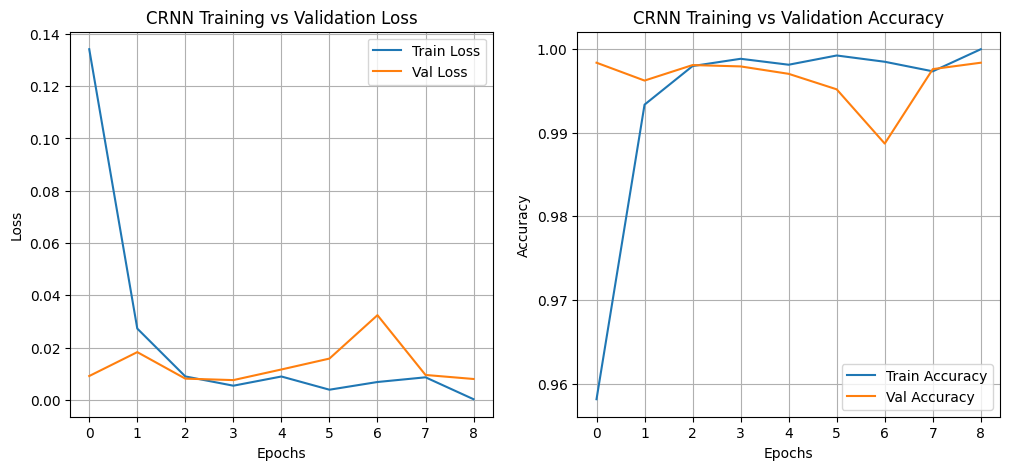


🔹 Evaluating CRNN on Dev Set...


777/777 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step

Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      0.98      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      0.99      0.99     24844
weighted avg       1.00      1.00      1.00     24844



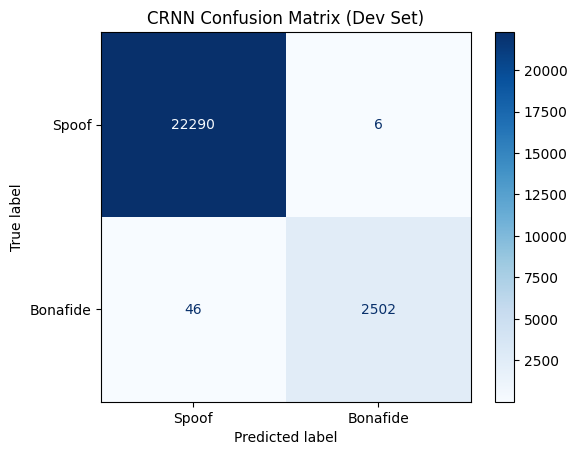


CRNN EER: 0.47% at threshold 0.0104 | AUC: 1.000


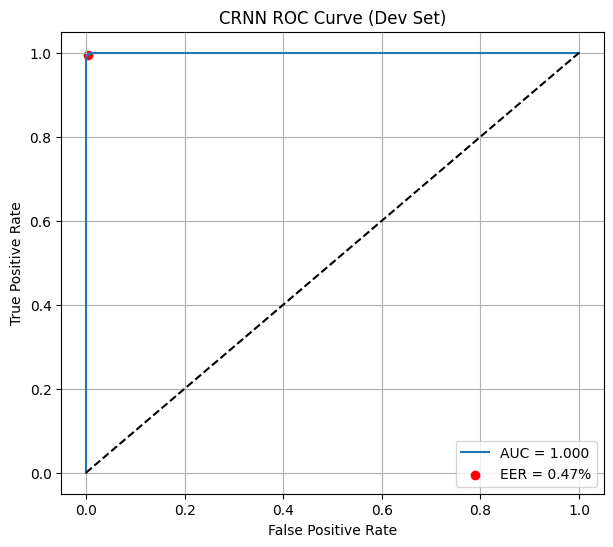


CRNN results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv


In [ ]:

# Train and Evaluate CRNN (LFCC Sequences)


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
save_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(save_dir, exist_ok=True)
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# --- Load padded LFCC sequences ---
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(features_seq_dir, "y_train.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train:", X_train_pad.shape, " Dev:", X_dev_pad.shape)


# Define CRNN model

model = Sequential([
    Input(shape=(X_train_pad.shape[1], X_train_pad.shape[2])),

    Conv1D(64, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Recurrent part
    LSTM(128, return_sequences=False),
    Dropout(0.5),

    # Fully connected classifier
    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


# Callbacks (save models + stop early if overfitting)

checkpoint_best = ModelCheckpoint(
    os.path.join(save_dir, "crnn_lfcc_best.h5"),
    monitor="val_loss", save_best_only=True, verbose=1
)
checkpoint_last = ModelCheckpoint(
    os.path.join(save_dir, "crnn_lfcc_last.h5"),
    save_best_only=False, verbose=1
)
early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)


# Train CRNN

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_dev_pad, y_dev),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint_best, checkpoint_last, early_stop],
    verbose=1
)

print(f"\nCRNN models saved to {save_dir}")

# Plot Training vs Validation Loss/Accuracy (Overfitting Check)

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CRNN Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CRNN Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


# Evaluate CRNN on Dev Set

print("\n Evaluating CRNN on Dev Set...")

# Use best model for evaluation
best_model = tf.keras.models.load_model(os.path.join(save_dir, "crnn_lfcc_best.h5"))
y_score = best_model.predict(X_dev_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)

# Classification report
print("\nClassification Report (Dev Set):")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# Confusion matrix
cm = confusion_matrix(y_dev, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof","Bonafide"])
disp.plot(cmap="Blues", values_format="d")
plt.title("CRNN Confusion Matrix (Dev Set)")
plt.show()

# ROC + EER
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index] * 100
eer_threshold = thresholds[eer_index]

print(f"\nCRNN EER: {eer:.2f}% at threshold {eer_threshold:.4f} | AUC: {roc_auc:.3f}")

# Save ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER = {eer:.2f}%")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CRNN ROC Curve (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()

# Compute final metrics
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

# Save results
result_entry = {
    "Experiment": "crnn_lfcc",
    "Features": "LFCC",
    "Model": "CRNN",
    "EER (%)": round(eer, 2),
    "Threshold": round(float(eer_threshold), 4),
    "Accuracy (%)": round(acc, 2),
    "Precision (%)": round(prec, 2),
    "Recall (%)": round(rec, 2),
    "F1 (%)": round(f1, 2),
    "AUC": round(roc_auc, 3)
}

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([result_entry])

df_results.to_csv(results_csv, index=False)
print(f"\nCRNN results saved to {results_csv}")


Dev set shape: (24844, 400, 29)  Labels: (24844,)



 valuating Best CRNN...
777/777 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      0.98      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      0.99      0.99     24844
weighted avg       1.00      1.00      1.00     24844



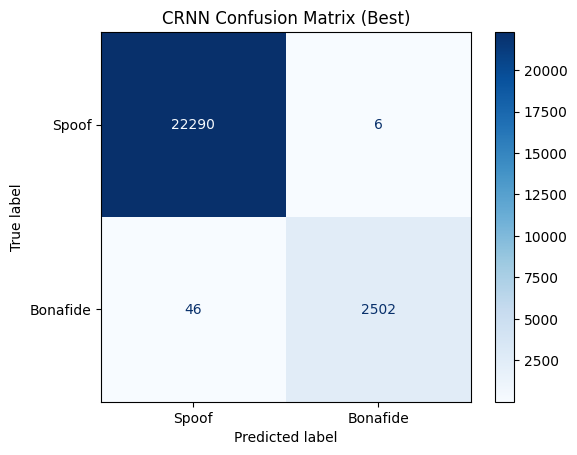

EER: 0.47% at threshold 0.0104 | AUC: 1.000

Best CRNN results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv



 valuating Last CRNN...
777/777 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      0.99      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      0.99      1.00     24844
weighted avg       1.00      1.00      1.00     24844



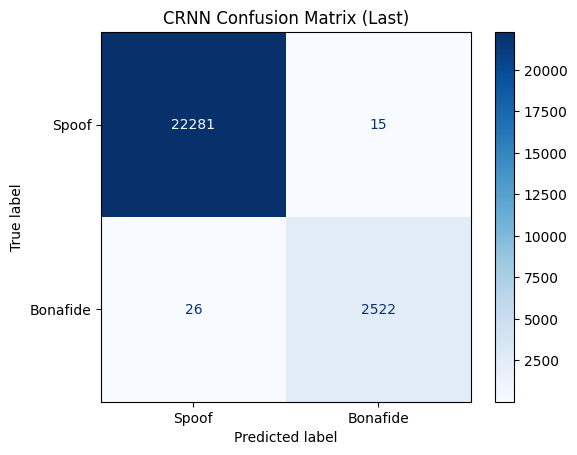

EER: 0.17% at threshold 0.0037 | AUC: 1.000

Last CRNN results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv


In [ ]:

# Evaluate CRNN Model on Dev Set


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)
import tensorflow as tf

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
best_model_path = os.path.join(dataset_dir, "saved_models", "crnn_lfcc_best.h5")
last_model_path = os.path.join(dataset_dir, "saved_models", "crnn_lfcc_last.h5")
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

# --- Load features ---
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Dev set shape:", X_dev_pad.shape, " Labels:", y_dev.shape)

# --- Evaluate function ---
def evaluate_model(model_path, label):
    model = tf.keras.models.load_model(model_path)
    print(f"\n valuating {label} CRNN...")

    # Predictions
    y_score = model.predict(X_dev_pad).ravel()
    y_pred = (y_score >= 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

    # Confusion matrix
    cm = confusion_matrix(y_dev, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"CRNN Confusion Matrix ({label})")
    plt.show()

    # ROC & EER
    fpr, tpr, thresholds = roc_curve(y_dev, y_score)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    eer_threshold = thresholds[eer_index]
    print(f"EER: {eer:.2f}% at threshold {eer_threshold:.4f} | AUC: {roc_auc:.3f}")

    # Metrics
    acc = accuracy_score(y_dev, y_pred) * 100
    prec = precision_score(y_dev, y_pred) * 100
    rec = recall_score(y_dev, y_pred) * 100
    f1 = f1_score(y_dev, y_pred) * 100

    # Save to CSV
    result_entry = {
        "Experiment": f"crnn_lfcc_{label.lower()}",
        "Features": "LFCC",
        "Model": f"CRNN-{label}",
        "EER (%)": round(eer, 2),
        "Threshold": round(float(eer_threshold), 4),
        "Accuracy (%)": round(acc, 2),
        "Precision (%)": round(prec, 2),
        "Recall (%)": round(rec, 2),
        "F1 (%)": round(f1, 2),
        "AUC": round(roc_auc, 3)
    }
    if os.path.exists(results_csv):
        df_results = pd.read_csv(results_csv)
        df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
    else:
        df_results = pd.DataFrame([result_entry])
    df_results.to_csv(results_csv, index=False)
    print(f"\n{label} CRNN results saved to {results_csv}")

# --- Evaluate both saved models ---
evaluate_model(best_model_path, "Best")
evaluate_model(last_model_path, "Last")


Train: (25380, 400, 29)  Dev: (24844, 400, 29)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 400, 256)       │       161,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,785 (1.31 MB)

 Trainable params: 342,785 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9493 - loss: 0.1379
Epoch 1: val_loss improved from inf to 0.00393, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5



Epoch 1: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1560s 4s/step - accuracy: 0.9494 - loss: 0.1377 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 2/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9968 - loss: 0.0130
Epoch 2: val_loss improved from 0.00393 to 0.00390, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5



Epoch 2: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1642s 4s/step - accuracy: 0.9968 - loss: 0.0130 - val_accuracy: 0.9988 - val_loss: 0.0039
Epoch 3/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9978 - loss: 0.0065
Epoch 3: val_loss improved from 0.00390 to 0.00222, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5



Epoch 3: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1612s 4s/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 4/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9985 - loss: 0.0046
Epoch 4: val_loss did not improve from 0.00222

Epoch 4: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1565s 4s/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9990 - val_loss: 0.0029
Epoch 5/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9989 - loss: 0.0032
Epoch 5: val_loss improved from 0.00222 to 0.00164, saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5



Epoch 5: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1607s 4s/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9996 - val_loss: 0.0016
Epoch 6/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9994 - loss: 0.0026
Epoch 6: val_loss did not improve from 0.00164

Epoch 6: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1692s 4s/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9991 - val_loss: 0.0030
Epoch 7/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9992 - loss: 0.0035
Epoch 7: val_loss did not improve from 0.00164

Epoch 7: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1610s 4s/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 8/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9969 - loss: 0.0100
Epoch 8: val_loss did not improve from 0.00164

Epoch 8: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1574s 4s/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9988 - val_loss: 0.0052
Epoch 9/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9975 - loss: 0.0083
Epoch 9: val_loss did not improve from 0.00164

Epoch 9: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1604s 4s/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.9986 - val_loss: 0.0061
Epoch 10/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9992 - loss: 0.0044
Epoch 10: val_loss did not improve from 0.00164

Epoch 10: saving model to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


397/397 ━━━━━━━━━━━━━━━━━━━━ 1624s 4s/step - accuracy: 0.9992 - loss: 0.0044 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.

 BiLSTM training complete. Best model: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5, Last model: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_last.h5


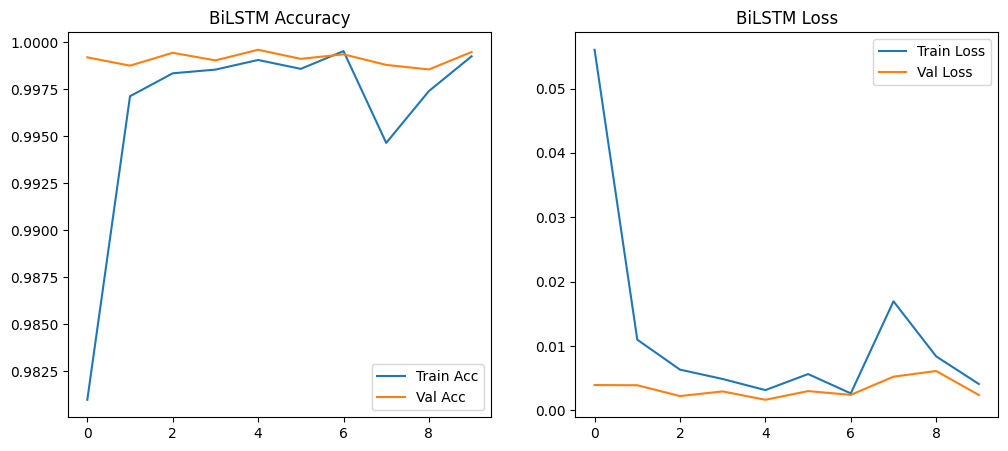

In [ ]:

# BiLSTM Model Training (LFCC Features)


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# --- Load LFCC Padded Features ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
X_dev_pad   = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_train     = np.load(os.path.join(features_seq_dir, "y_train.npy"))
y_dev       = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train:", X_train_pad.shape, " Dev:", X_dev_pad.shape)

# --- Model Save Paths ---
model_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(model_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "bilstm_lfcc_best.h5")
last_model_path = os.path.join(model_dir, "bilstm_lfcc_last.h5")

# --- Define BiLSTM Model ---
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(400, 29)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# --- Callbacks ---
checkpoint_best = ModelCheckpoint(best_model_path, monitor="val_loss", save_best_only=True, verbose=1)
checkpoint_last = ModelCheckpoint(last_model_path, save_best_only=False, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# --- Train ---
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_dev_pad, y_dev),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint_best, checkpoint_last, early_stop],
    verbose=1
)

print(f"\n BiLSTM training complete. Best model: {best_model_path}, Last model: {last_model_path}")

# --- Plot Training Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("BiLSTM Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("BiLSTM Loss")
plt.show()



BiLSTM model loaded from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_best.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 486s 625ms/step

Classification Report (Dev Set):
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844



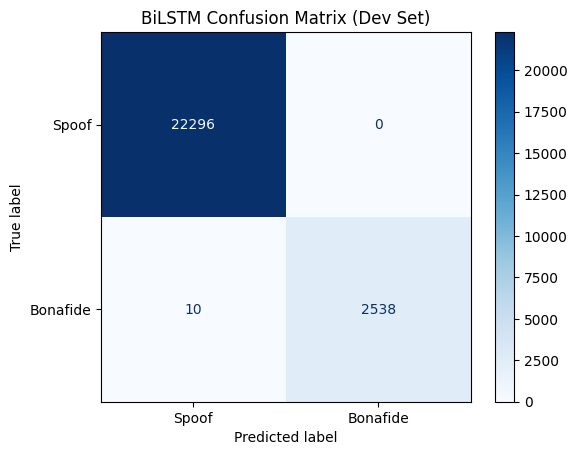


BiLSTM EER: 0.17% at threshold 0.0030, AUC: 1.000


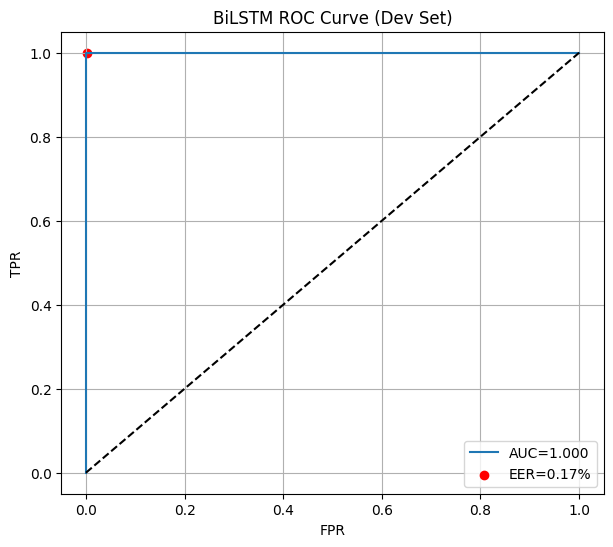

In [ ]:

# Evaluate BiLSTM Model


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd

# --- Load Best Model ---
bilstm_model = tf.keras.models.load_model(best_model_path)
print(f"\nBiLSTM model loaded from {best_model_path}")

# --- Predictions ---
y_score = bilstm_model.predict(X_dev_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)

# --- Classification Report ---
print("\nClassification Report (Dev Set):")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_dev, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Spoof","Bonafide"])
disp.plot(cmap="Blues", values_format="d")
plt.title("BiLSTM Confusion Matrix (Dev Set)")
plt.show()

# --- ROC & EER ---
fpr, tpr, thresholds = roc_curve(y_dev, y_score)
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_idx]*100
eer_thresh = thresholds[eer_idx]

print(f"\nBiLSTM EER: {eer:.2f}% at threshold {eer_thresh:.4f}, AUC: {roc_auc:.3f}")

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.scatter(fpr[eer_idx], tpr[eer_idx], color="red", label=f"EER={eer:.2f}%")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("BiLSTM ROC Curve (Dev Set)")
plt.legend(); plt.grid(True)
plt.show()


Dev set shape: (24844, 400, 29)  Labels: (24844,)

🔹 Evaluating Best BiLSTM...


777/777 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844



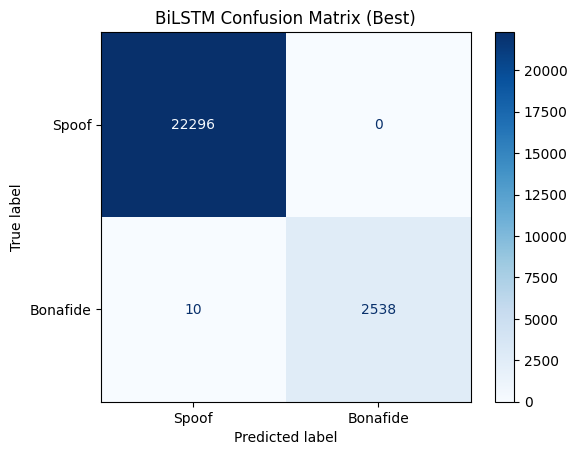

EER: 0.17% at threshold 0.0030 | AUC: 1.000


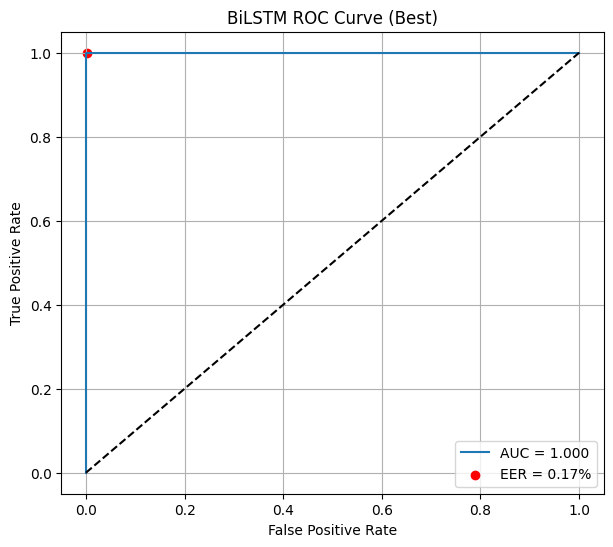


✅ Results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv

🔹 Evaluating Last BiLSTM...


777/777 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844



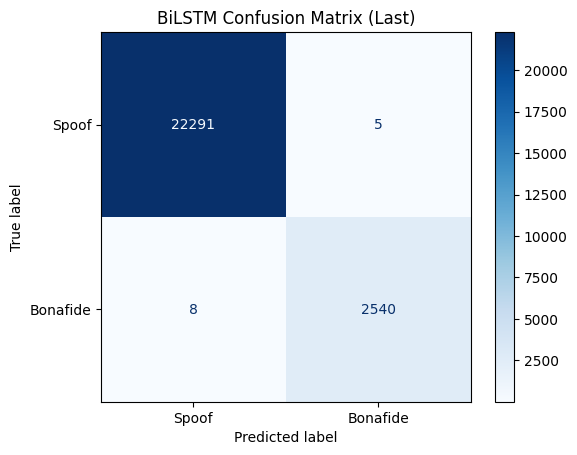

EER: 0.13% at threshold 0.0079 | AUC: 1.000


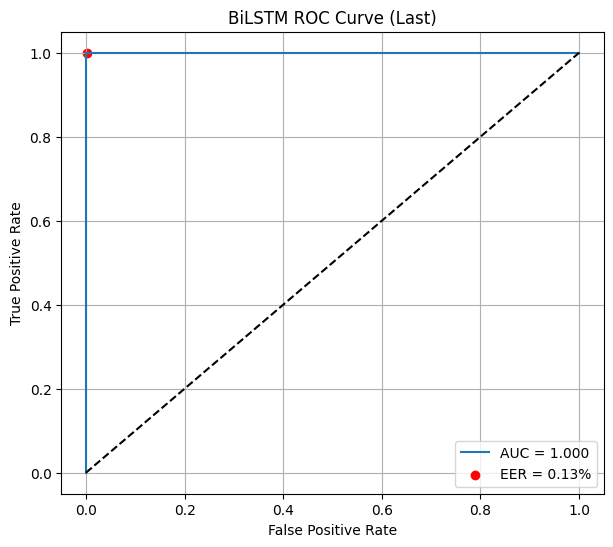


✅ Results saved to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results.csv


In [ ]:

# Evaluate BiLSTM Model on Dev Set (LFCC)


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)
import tensorflow as tf

# --- Paths ---
features_seq_dir = os.path.join(dataset_dir, "features_seq")
results_csv = os.path.join(dataset_dir, "experiment_results.csv")

best_model_path = os.path.join(dataset_dir, "saved_models", "bilstm_lfcc_best.h5")
last_model_path = os.path.join(dataset_dir, "saved_models", "bilstm_lfcc_last.h5")

# --- Load Dev set ---
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Dev set shape:", X_dev_pad.shape, " Labels:", y_dev.shape)

# --- Function to evaluate a model ---
def evaluate_model(model_path, label):
    print(f"\n🔹 Evaluating {label} BiLSTM...")
    model = tf.keras.models.load_model(model_path)

    # Predictions
    y_score = model.predict(X_dev_pad).ravel()
    y_pred = (y_score >= 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))

    # Confusion matrix
    cm = confusion_matrix(y_dev, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"BiLSTM Confusion Matrix ({label})")
    plt.show()

    # ROC curve and EER
    fpr, tpr, thresholds = roc_curve(y_dev, y_score)
    roc_auc = auc(fpr, tpr)

    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    eer_threshold = thresholds[eer_index]

    print(f"EER: {eer:.2f}% at threshold {eer_threshold:.4f} | AUC: {roc_auc:.3f}")

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER = {eer:.2f}%")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"BiLSTM ROC Curve ({label})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Metrics
    acc = accuracy_score(y_dev, y_pred) * 100
    prec = precision_score(y_dev, y_pred) * 100
    rec = recall_score(y_dev, y_pred) * 100
    f1 = f1_score(y_dev, y_pred) * 100

    # Save results
    result_entry = {
        "Experiment": f"bilstm_lfcc_{label.lower()}",
        "Features": "LFCC",
        "Model": "BiLSTM",
        "EER (%)": round(eer, 2),
        "Threshold": round(float(eer_threshold), 4),
        "Accuracy (%)": round(acc, 2),
        "Precision (%)": round(prec, 2),
        "Recall (%)": round(rec, 2),
        "F1 (%)": round(f1, 2),
        "AUC": round(roc_auc, 3)
    }

    if os.path.exists(results_csv):
        df_results = pd.read_csv(results_csv)
        df_results = pd.concat([df_results, pd.DataFrame([result_entry])], ignore_index=True)
    else:
        df_results = pd.DataFrame([result_entry])

    df_results.to_csv(results_csv, index=False)
    print(f"\n Results saved to {results_csv}")

# --- Evaluate both best and last models ---
evaluate_model(best_model_path, "Best")
evaluate_model(last_model_path, "Last")


In [ ]:
import os

# Base dataset folder
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

# Subfolders for checkpoints
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")

os.makedirs(features_dir, exist_ok=True)
os.makedirs(features_seq_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print("Directories ready.")

Directories ready.


Verify Dataset Splits

In [ ]:

# Step 1: Verify Dataset Splits & Protocols


import os
import pandas as pd

# --- Define dataset paths ---
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
train_path = os.path.join(dataset_dir, "ASVspoof2019_LA_train/flac")
dev_path   = os.path.join(dataset_dir, "ASVspoof2019_LA_dev/flac")
eval_path  = os.path.join(dataset_dir, "ASVspoof2019_LA_eval/flac")  # may not always be accessible

# --- Define protocol paths ---
protocol_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols")
train_protocol = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.train.trn.txt")
dev_protocol   = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.dev.trl.txt")
eval_protocol  = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.eval.trl.txt")

print("=== Dataset Split Verification ===")

# --- Count files in train/dev ---
print("Files in Train:", len(os.listdir(train_path)))
print("Files in Dev:", len(os.listdir(dev_path)))

# --- Try Eval safely ---
try:
    eval_count = len(os.listdir(eval_path))
    print("Files in Eval:", eval_count)
except Exception as e:
    print("Could not access Eval set:", str(e))
    print(" You may need to re-download or re-mount Google Drive.")

# --- Load protocols (metadata that maps IDs to bonafide/spoof) ---
df_train = pd.read_csv(train_protocol, sep=" ", header=None, names=["SpeakerID","FileID","SystemID","Key"])
df_dev   = pd.read_csv(dev_protocol,   sep=" ", header=None, names=["SpeakerID","FileID","SystemID","Key"])
df_eval  = pd.read_csv(eval_protocol,  sep=" ", header=None, names=["SpeakerID","FileID","SystemID","Key"])

print("\n=== Protocol Check ===")
print("Train protocol shape:", df_train.shape)
print("Dev protocol shape:", df_dev.shape)
print("Eval protocol shape:", df_eval.shape)

print("\nSample from Dev protocol:")
print(df_dev.head())




=== Dataset Split Verification ===
Files in Train: 25380
Files in Dev: 24986
Could not access Eval set: [Errno 5] Input/output error: '/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac'
 You may need to re-download or re-mount Google Drive.

=== Protocol Check ===
Train protocol shape: (25380, 4)
Dev protocol shape: (24844, 4)
Eval protocol shape: (71237, 4)

Sample from Dev protocol:
            SpeakerID FileID SystemID       Key
LA_0069  LA_D_1047731      -        -  bonafide
LA_0069  LA_D_1105538      -        -  bonafide
LA_0069  LA_D_1125976      -        -  bonafide
LA_0069  LA_D_1293230      -        -  bonafide
LA_0069  LA_D_1340209      -        -  bonafide


In [ ]:

# STEP 2: Extract LFCC Features for Train, Dev, and Eval Sets

# PURPOSE:
# - Read the ASVspoof2019-LA protocol files
# - Match each file ID with its actual .flac file
# - Extract LFCC features per file
# - Save features (X) and labels (y) into numpy arrays
# - Measure latency per file for efficiency comparison


import os
import numpy as np
import librosa
import scipy.fftpack
import tqdm
import time


# 1. LFCC extraction function

def extract_lfcc(file_path, n_filters=30, n_ceps=30, sr=16000):
    """Extract LFCC features from one audio file."""
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr)

        # Power spectrum
        stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2

        # Linear filterbank
        freqs = np.linspace(0, sr/2, stft.shape[0])
        filter_edges = np.linspace(0, sr/2, n_filters+1)

        filterbank = np.zeros((n_filters, len(freqs)))
        for i in range(n_filters):
            left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
            filterbank[i] = np.maximum(0,
                np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
            )

        # Apply filterbank
        lfcc = np.dot(filterbank, stft)

        # Log compression
        lfcc = np.log(lfcc + 1e-6)

        # DCT → cepstral coefficients
        lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]

        # Average across frames → fixed vector
        return np.mean(lfcc.T, axis=0)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# 2. Process dataset split

def process_split(audio_path, protocol_file, split_name):
    """
    Process Train/Dev/Eval set using its protocol file.
    - Extract LFCC per audio
    - Return X (features) and y (labels)
    """
    features, labels = [], []
    start_time = time.time()

    with open(protocol_file, "r") as f:
        lines = f.readlines()

    for line in tqdm.tqdm(lines, desc=f"Extracting {split_name}"):
        parts = line.strip().split()
        file_id, label = parts[1], parts[4]   # Column 2 = file, Column 5 = label
        file_path = os.path.join(audio_path, f"{file_id}.flac")

        if not os.path.exists(file_path):
            print(f" Missing file: {file_path}")
            continue

        lfcc = extract_lfcc(file_path)
        if lfcc is not None:
            features.append(lfcc)
            labels.append(1 if label == "bonafide" else 0)

    total_time = time.time() - start_time
    avg_latency = total_time / max(len(features), 1)

    features = np.array(features, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    print(f"{split_name} set -> Features: {features.shape}, Labels: {labels.shape}")
    print(f" Avg latency for {split_name}: {avg_latency:.4f} sec/file")

    return features, labels


# 3. Paths & Protocols

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"

train_path = os.path.join(dataset_dir, "ASVspoof2019_LA_train", "flac")
dev_path   = os.path.join(dataset_dir, "ASVspoof2019_LA_dev", "flac")
eval_path  = os.path.join(dataset_dir, "ASVspoof2019_LA_eval", "flac")

protocol_dir = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols")
train_protocol = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.train.trn.txt")
dev_protocol   = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.dev.trl.txt")
eval_protocol  = os.path.join(protocol_dir, "ASVspoof2019.LA.cm.eval.trl.txt")

features_dir = os.path.join(dataset_dir, "features")
os.makedirs(features_dir, exist_ok=True)


# 4. Run extraction for Train, Dev, Eval

X_train, y_train = process_split(train_path, train_protocol, "Train")
X_dev, y_dev     = process_split(dev_path, dev_protocol, "Dev")
X_eval, y_eval   = process_split(eval_path, eval_protocol, "Eval")

# 5. Save results

np.save(os.path.join(features_dir, "X_train_lfcc.npy"), X_train)
np.save(os.path.join(features_dir, "y_train.npy"), y_train)
np.save(os.path.join(features_dir, "X_dev_lfcc.npy"), X_dev)
np.save(os.path.join(features_dir, "y_dev.npy"), y_dev)
np.save(os.path.join(features_dir, "X_eval_lfcc.npy"), X_eval)
np.save(os.path.join(features_dir, "y_eval.npy"), y_eval)

print(" LFCC features saved in:", features_dir)


Extracting Train: 100%|██████████| 25380/25380 [1:48:39<00:00,  3.89it/s]


Train set -> Features: (25380, 29), Labels: (25380,)
 Avg latency for Train: 0.2569 sec/file


Extracting Dev: 100%|██████████| 24844/24844 [1:37:09<00:00,  4.26it/s]


Dev set -> Features: (24844, 29), Labels: (24844,)
 Avg latency for Dev: 0.2347 sec/file


Extracting Eval:   0%|          | 1/71237 [02:00<2374:37:20, 120.00s/it]

 Missing file: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac/LA_E_2834763.flac


Extracting Eval: 100%|██████████| 71237/71237 [5:10:01<00:00,  3.83it/s]


Eval set -> Features: (71236, 29), Labels: (71236,)
 Avg latency for Eval: 0.2611 sec/file
 LFCC features saved in: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/features


In [ ]:

# Extract & Pad LFCC Sequences for Eval


import os
import numpy as np
import librosa
import scipy.fftpack
import tqdm

# Paths
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
eval_path = os.path.join(dataset_dir, "ASVspoof2019_LA_eval", "flac")
eval_protocol = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.eval.trl.txt")

features_seq_dir = os.path.join(dataset_dir, "features_seq")
os.makedirs(features_seq_dir, exist_ok=True)

# --- LFCC sequence extractor ---
def extract_lfcc_sequence(file_path, n_filters=30, n_ceps=30, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2

    freqs = np.linspace(0, sr/2, stft.shape[0])
    filter_edges = np.linspace(0, sr/2, n_filters+1)
    filterbank = np.zeros((n_filters, len(freqs)))

    for i in range(n_filters):
        left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
        filterbank[i] = np.maximum(0,
            np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
        )

    lfcc = np.dot(filterbank, stft)
    lfcc = np.log(lfcc + 1e-6)
    lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]
    return lfcc.T   # shape: (num_frames, n_ceps)

# --- Load protocol & extract ---
X_eval_seq, y_eval = [], []

with open(eval_protocol, "r") as f:
    lines = f.readlines()

for line in tqdm.tqdm(lines, desc="Extracting Eval Sequences"):
    parts = line.strip().split()
    file_id, label = parts[1], parts[4]
    file_path = os.path.join(eval_path, f"{file_id}.flac")

    if not os.path.exists(file_path):
        print(f" Missing file: {file_path}")
        continue

    seq = extract_lfcc_sequence(file_path, n_filters=30, n_ceps=29)
    X_eval_seq.append(seq)
    y_eval.append(1 if label == "bonafide" else 0)

# Save raw sequences
np.save(os.path.join(features_seq_dir, "X_eval_lfcc_seq.npy"), np.array(X_eval_seq, dtype=object))
np.save(os.path.join(features_seq_dir, "y_eval.npy"), np.array(y_eval, dtype=np.int32))

print("Raw Eval sequences saved:", len(X_eval_seq))



Extracting Eval Sequences:   0%|          | 1/71237 [02:00<2374:33:49, 120.00s/it]

 Missing file: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac/LA_E_2834763.flac


Extracting Eval Sequences:   0%|          | 2/71237 [04:00<2374:32:40, 120.00s/it]

 Missing file: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac/LA_E_8877452.flac


Extracting Eval Sequences: 100%|██████████| 71237/71237 [6:23:13<00:00,  3.10it/s]


Raw Eval sequences saved: 71235


In [ ]:

# Batch Padding for Eval LFCC Sequences


import os
import numpy as np

# Paths
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")
raw_seq_path = os.path.join(features_seq_dir, "X_eval_lfcc_seq.npy")
save_path = os.path.join(features_seq_dir, "X_eval_lfcc_seq_pad.npy")

# Load raw sequences
X_eval_seq = np.load(raw_seq_path, allow_pickle=True)
print("Loaded raw Eval sequences:", len(X_eval_seq))

# Padding function
def pad_sequences(X, max_len=400):
    padded = []
    for seq in X:
        if seq.shape[0] > max_len:
            padded.append(seq[:max_len])
        else:
            pad = np.zeros((max_len - seq.shape[0], seq.shape[1]))
            padded.append(np.vstack((seq, pad)))
    return np.array(padded, dtype=np.float32)

# Process in batches
batch_size = 5000
num_batches = int(np.ceil(len(X_eval_seq) / batch_size))

# Create memmap file (saves directly to disk)
X_eval_pad = np.lib.format.open_memmap(
    save_path, dtype=np.float32, mode="w+",
    shape=(len(X_eval_seq), 400, X_eval_seq[0].shape[1])
)

print(f"Saving padded sequences in {num_batches} batches...")

for i in range(num_batches):
    start, end = i*batch_size, min((i+1)*batch_size, len(X_eval_seq))
    batch = pad_sequences(X_eval_seq[start:end], max_len=400)
    X_eval_pad[start:end] = batch
    print(f" Batch {i+1}/{num_batches} done: {start}  {end}")

print(" Finished! Padded Eval shape:", X_eval_pad.shape)
print("Saved to:", save_path)


Loaded raw Eval sequences: 71235
Saving padded sequences in 15 batches...
 Batch 1/15 done: 0 → 5000
 Batch 2/15 done: 5000 → 10000
 Batch 3/15 done: 10000 → 15000
 Batch 4/15 done: 15000 → 20000
 Batch 5/15 done: 20000 → 25000
 Batch 6/15 done: 25000 → 30000
 Batch 7/15 done: 30000 → 35000
 Batch 8/15 done: 35000 → 40000
 Batch 9/15 done: 40000 → 45000
 Batch 10/15 done: 45000 → 50000
 Batch 11/15 done: 50000 → 55000
 Batch 12/15 done: 55000 → 60000
 Batch 13/15 done: 60000 → 65000
 Batch 14/15 done: 65000 → 70000
 Batch 15/15 done: 70000 → 71235
 Finished! Padded Eval shape: (71235, 400, 29)
Saved to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/features_seq/X_eval_lfcc_seq_pad.npy


In [ ]:
!ls -lh "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/features_seq"

total 14G
-rw------- 1 root root 1.9G Aug 20 11:50 X_dev_lfcc_seq.npy
-rw------- 1 root root 1.1G Aug 20 02:40 X_dev_lfcc_seq_pad.npy
-rw------- 1 root root 4.8G Aug 26 06:11 X_eval_lfcc_seq.npy
-rw------- 1 root root 3.1G Aug 26 10:51 X_eval_lfcc_seq_pad.npy
-rw------- 1 root root 1.9G Aug 20 11:46 X_train_lfcc_seq.npy
-rw------- 1 root root 1.1G Aug 20 02:39 X_train_lfcc_seq_pad.npy
-rw------- 1 root root 195K Aug 20 02:39 y_dev.npy
-rw------- 1 root root 279K Aug 26 06:11 y_eval.npy
-rw------- 1 root root 199K Aug 20 02:39 y_train.npy


In [ ]:
import os, time, numpy as np, pandas as pd
import tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, DetCurveDisplay

# Avoid TF grabbing all GPU RAM (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus: tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("TF memory growth not set:", e)


In [ ]:
dataset_dir      = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir       = os.path.join(dataset_dir, "saved_models")
eval_protocol    = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.eval.trl.txt")
missing_ids      = {"LA_E_2834763", "LA_E_8877452"}
PRED_BATCH       = 256


Loaded features:
 Deep (29 LFCC seq) shape: (71235, 400, 29)
 Labels shape: (71235,)
Loading model: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step

CNN (using /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_best.h5)
AUC=0.947 | EER=11.61% at Thr=1.0000 | Latency=0.754 ms/sample
 @ Thr=0.50 : Acc=74.53%  Prec=28.80%  Rec=99.65%  F1=44.69%  CM=[[TN=45763, FP=18117], [FN=26, TP=7329]]
 @ Thr=EER  : Acc=88.38%  Prec=46.70%   Rec=88.38%   F1=61.11%  CM=[[TN=56461, FP=7419], [FN=855, TP=6500]]
 @ Thr=F1*  : Acc=90.33% Prec=52.13%  Rec=78.04%  F1=62.51% CM=[[TN=58610, FP=5270], [FN=1615, TP=5740]] (F1-optimized for Bonafide)
Loading model: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 113s 403ms/step

CRNN (using /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_best.h5)
A

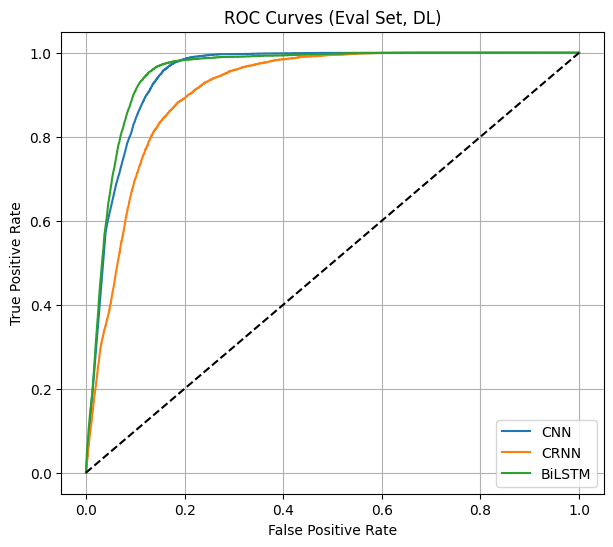

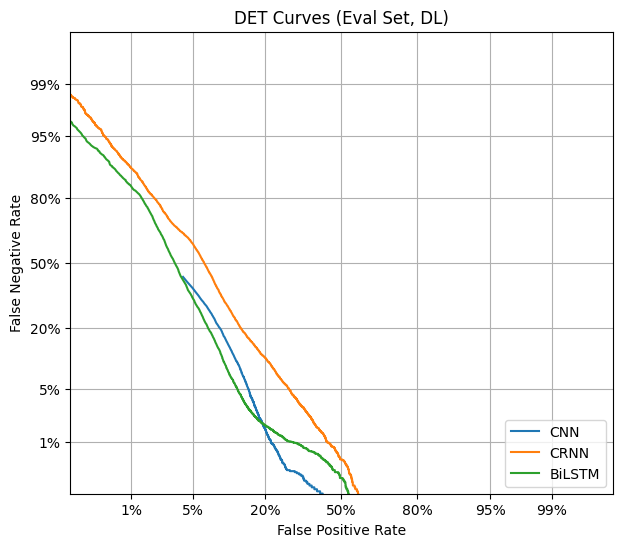

In [ ]:

# FINAL DL EVALUATION (one-cell, robust)

pad_len, n_feats = 400, 29

# 1) Load features
X_path = os.path.join(features_seq_dir, "X_eval_lfcc_seq_pad.npy")
assert os.path.exists(X_path), f"Features not found: {X_path}"
X_eval_pad = np.load(X_path)  # (N, 400, 29)
assert X_eval_pad.ndim == 3 and X_eval_pad.shape[1:] == (pad_len, n_feats), f"Expected (N,{pad_len},{n_feats}), got {X_eval_pad.shape}"

# 2) Load or build labels
y_npy = os.path.join(features_seq_dir, "y_eval_lfcc29_seq.npy")
ids_npy = os.path.join(features_seq_dir, "ids_eval_lfcc29_seq.npy")

if os.path.exists(y_npy) and os.path.exists(ids_npy):
    y_eval  = np.load(y_npy)
    ids_eval= np.load(ids_npy)
else:
    y_list, ids_list = [], []
    with open(eval_protocol, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5: continue
            file_id, label = parts[1], parts[4]
            if file_id in missing_ids: continue
            y_list.append(1 if label == "bonafide" else 0)
            ids_list.append(file_id)
    y_eval = np.array(y_list, dtype="int32")
    ids_eval= np.array(ids_list)
    np.save(y_npy, y_eval); np.save(ids_npy, ids_eval)

# Align counts if needed
if X_eval_pad.shape[0] != y_eval.shape[0]:
    n = min(X_eval_pad.shape[0], y_eval.shape[0])
    print(f"WARNING: Count mismatch (features={X_eval_pad.shape[0]}, labels={y_eval.shape[0]}). Trimming to {n}.")
    X_eval_pad = X_eval_pad[:n]; y_eval = y_eval[:n]; ids_eval = ids_eval[:n]

print("Loaded features:")
print(" Deep (29 LFCC seq) shape:", X_eval_pad.shape)
print(" Labels shape:", y_eval.shape)

# ---------- helpers ----------
def summarize_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1  = f1_score(y_true, y_pred) * 100
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
    return acc, prec, rec, f1, cm

def best_f1_threshold(y_true, y_score):
    precs, recs, thrs = precision_recall_curve(y_true, y_score)
    f1s = 2 * (precs * recs) / (precs + recs + 1e-9)
    if len(thrs) == 0: return 0.5
    idx = int(np.nanargmax(f1s))
    return float(thrs[max(0, min(idx, len(thrs)-1))])

def evaluate_predictions_multi(y_true, y_score, model_name, latency, model_path):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_idx = int(np.nanargmin(np.abs(fnr - fpr)))
    eer = float(fpr[eer_idx] * 100)
    thr_eer = float(thr[eer_idx]) if eer_idx < len(thr) else 0.5
    roc_auc = float(auc(fpr, tpr))

    thr_05 = 0.5
    thr_f1 = float(best_f1_threshold(y_true, y_score))

    acc05, p05, r05, f105, cm05 = summarize_at_threshold(y_true, y_score, thr_05)
    acce,  pe,  re,  f1e,  cme  = summarize_at_threshold(y_true, y_score, thr_eer)
    accf1, pf1, rf1, f1f1, cmf1 = summarize_at_threshold(y_true, y_score, thr_f1)

    def fmt_cm(cm):
        tn, fp, fn, tp = cm.ravel()
        return f"[[TN={tn}, FP={fp}], [FN={fn}, TP={tp}]]"

    print(f"\n{model_name} (using {model_path})")
    print(f"AUC={roc_auc:.3f} | EER={eer:.2f}% at Thr={thr_eer:.4f} | Latency={latency*1000:.3f} ms/sample")
    print(f" @ Thr=0.50 : Acc={acc05:.2f}%  Prec={p05:.2f}%  Rec={r05:.2f}%  F1={f105:.2f}%  CM={fmt_cm(cm05)}")
    print(f" @ Thr=EER  : Acc={acce:.2f}%  Prec={pe:.2f}%   Rec={re:.2f}%   F1={f1e:.2f}%  CM={fmt_cm(cme)}")
    print(f" @ Thr=F1*  : Acc={accf1:.2f}% Prec={pf1:.2f}%  Rec={rf1:.2f}%  F1={f1f1:.2f}% CM={fmt_cm(cmf1)} (F1-optimized for Bonafide)")

    return {
        "Model": model_name,
        "AUC": round(roc_auc,3),
        "EER (%)": round(eer,2),
        "Thr@EER": round(thr_eer,6),
        "Thr@F1*": round(thr_f1,6),
        "Latency (ms/sample)": round(latency*1000,3),
        "Acc@0.5": round(acc05,2), "Prec@0.5": round(p05,2), "Rec@0.5": round(r05,2), "F1@0.5": round(f105,2),
        "Acc@EER": round(acce,2),  "Prec@EER": round(pe,2),  "Rec@EER": round(re,2),  "F1@EER": round(f1e,2),
        "Acc@F1*": round(accf1,2), "Prec@F1*": round(pf1,2), "Rec@F1*": round(rf1,2), "F1@F1*": round(f1f1,2),
    }, (fpr, tpr)

def load_model(path):
    if not os.path.exists(path):
        print(f"SKIP: model not found -> {path}")
        return None
    print(f"Loading model: {path}")
    return tf.keras.models.load_model(path, compile=False)

def predict_scores(model, X, batch_size=PRED_BATCH):
    t0 = time.time()
    y_score = model.predict(X, verbose=1, batch_size=batch_size).ravel()
    latency = (time.time() - t0) / len(X)
    return y_score, latency

# 3) Run models
results = []
roc_curves = {}
score_dumps_dir = os.path.join(dataset_dir, "eval_scores_dl"); os.makedirs(score_dumps_dir, exist_ok=True)

for name, fname in [("CNN","cnn_lfcc_best.h5"), ("CRNN","crnn_lfcc_best.h5"), ("BiLSTM","bilstm_lfcc_best.h5")]:
    mpath = os.path.join(models_dir, fname)
    model = load_model(mpath)
    if model is None:
        continue
    y_score, latency = predict_scores(model, X_eval_pad)
    # save raw scores for reproducibility
    np.save(os.path.join(score_dumps_dir, f"{name.lower()}_scores_eval.npy"), y_score)
    res, (fpr, tpr) = evaluate_predictions_multi(y_eval, y_score, name, latency, mpath)
    results.append(res); roc_curves[name] = (fpr, tpr)

# 4) Save results table
summary_csv = os.path.join(dataset_dir, "experiment_results_eval_dl_thresholds.csv")
pd.DataFrame(results).to_csv(summary_csv, index=False)
print("\nSaved summary to:", summary_csv)

# 5) Plots
plt.figure(figsize=(7,6))
for name,(fpr,tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Eval Set, DL)"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,6))
for name,(fpr,tpr) in roc_curves.items():
    DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=name).plot(ax=plt.gca())
plt.title("DET Curves (Eval Set, DL)"); plt.grid(True); plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

def summarize_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # rows: true [Spoof, Bonafide]
    return acc, prec, rec, f1, cm

def best_f1_threshold(y_true, y_score):
    # Optimize F1 for positive class (Bonafide=1)
    precs, recs, thrs = precision_recall_curve(y_true, y_score)
    f1s = 2 * (precs * recs) / (precs + recs + 1e-9)
    idx = np.nanargmax(f1s)
    # precision_recall_curve returns thresholds of length n-1
    return thrs[max(0, min(idx, len(thrs)-1))]

def evaluate_predictions_multi(y_true, y_score, model_name, latency, model_path):
    # Global curves + EER/AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    eer_thr = np.linspace(0, 1, len(fpr))[eer_idx]  # not used; we want the actual score thr
    # Recompute to get the threshold array aligned:
    fpr2, tpr2, thr2 = roc_curve(y_true, y_score)
    fnr2 = 1 - tpr2
    eer_pos = np.nanargmin(np.abs(fnr2 - fpr2))
    thr_eer = thr2[eer_pos] if eer_pos < len(thr2) else 0.5
    eer = fpr2[eer_pos] * 100

    # Baselines at three thresholds
    thr_05 = 0.5
    thr_f1 = best_f1_threshold(y_true, y_score)

    acc05, p05, r05, f105, cm05   = summarize_at_threshold(y_true, y_score, thr_05)
    acce,  pe,  re,  f1e,  cme    = summarize_at_threshold(y_true, y_score, thr_eer)
    accf1, pf1, rf1, f1f1, cmf1   = summarize_at_threshold(y_true, y_score, thr_f1)

    print(f"\n{model_name} (using {model_path}) — AUC={roc_auc:.3f}, EER={eer:.2f}% at Thr={thr_eer:.4f}, Latency={latency*1000:.3f} ms/sample")

    def fmt(cm):
        tn, fp, fn, tp = cm.ravel()
        return f"CM [[TN={tn}, FP={fp}], [FN={fn}, TP={tp}]]"

    print(f" @ Thr=0.50 : Acc={acc05:.2f}%  Prec={p05:.2f}%  Rec={r05:.2f}%  F1={f105:.2f}%  {fmt(cm05)}")
    print(f" @ Thr=EER  : Acc={acce:.2f}%  Prec={pe:.2f}%   Rec={re:.2f}%   F1={f1e:.2f}%  {fmt(cme)}")
    print(f" @ Thr=F1*  : Acc={accf1:.2f}% Prec={pf1:.2f}%  Rec={rf1:.2f}%  F1={f1f1:.2f}% {fmt(cmf1)}  (F1-optimized for Bonafide)")

    # Return ROC data for plots
    return {
        "Model": model_name,
        "AUC": round(roc_auc,3),
        "EER (%)": round(eer,2),
        "Thr@EER": float(thr_eer),
        "Latency (ms/sample)": round(latency*1000,3),
        "Acc@0.5": round(acc05,2),
        "Prec@0.5": round(p05,2),
        "Rec@0.5": round(r05,2),
        "F1@0.5": round(f105,2),
        "Acc@EER": round(acce,2),
        "Prec@EER": round(pe,2),
        "Rec@EER": round(re,2),
        "F1@EER": round(f1e,2),
        "Acc@F1*": round(accf1,2),
        "Prec@F1*": round(pf1,2),
        "Rec@F1*": round(rf1,2),
        "F1@F1*": round(f1f1,2),
    }, fpr, tpr


In [ ]:
import os, time, numpy as np, pandas as pd
import tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, DetCurveDisplay

# Avoid TF grabbing all GPU RAM (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus: tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("TF memory growth not set:", e)


In [ ]:
# installs (safe to re-run)
!pip -q install librosa soundfile tqdm scipy

import os, numpy as np, librosa, scipy.fftpack, tqdm


In [ ]:
#  paths & constants
BASE = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
FEAT    = os.path.join(BASE, "features")        # 20-LFCC pooled arrays + per-file cache
FEATSEQ = os.path.join(BASE, "features_seq")    # 29-LFCC seq arrays + per-file cache
PROTO   = os.path.join(BASE, "ASVspoof2019_LA_cm_protocols")

# Protocol files
PROTO_TRAIN = os.path.join(PROTO, "ASVspoof2019.LA.cm.train.trn.txt")
PROTO_DEV   = os.path.join(PROTO, "ASVspoof2019.LA.cm.dev.trl.txt")
PROTO_EVAL  = os.path.join(PROTO, "ASVspoof2019.LA.cm.eval.trl.txt")

# Audio roots
TRAIN_FLAC = os.path.join(BASE, "ASVspoof2019_LA_train", "flac")
DEV_FLAC   = os.path.join(BASE, "ASVspoof2019_LA_dev",   "flac")
EVAL_FLAC  = os.path.join(BASE, "ASVspoof2019_LA_eval",  "flac")

# Known-missing eval files (you found these)
MISSING_EVAL_IDS = {"LA_E_2834763", "LA_E_8877452"}

os.makedirs(FEAT, exist_ok=True)
os.makedirs(FEATSEQ, exist_ok=True)


In [ ]:
#  helper functions (run once per session)
import os, numpy as np, librosa, scipy.fftpack, tqdm

# --- Protocol ---
def parse_protocol(path):
    """Return list of (file_id, label) where label: bonafide=1, spoof=0."""
    items = []
    with open(path, "r") as f:
        for line in f:
            p = line.strip().split()
            if len(p) < 5:
                continue
            file_id, label = p[1], p[4]
            items.append((file_id, 1 if label == "bonafide" else 0))
    return items

# --- 20-LFCC pooled ---
def extract_lfcc20_mean(wav_path, n_filters=20, n_ceps=20, sr=16000):
    y, sr = librosa.load(wav_path, sr=sr)
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2
    freqs = np.linspace(0, sr/2, stft.shape[0])
    edges = np.linspace(0, sr/2, n_filters+1)
    fb = np.zeros((n_filters, len(freqs)), dtype=np.float32)
    for i in range(n_filters):
        L, C, R = edges[i], (edges[i]+edges[i+1])/2, edges[i+1]
        fb[i] = np.maximum(0, np.minimum((freqs-L)/(C-L+1e-6), (R-freqs)/(R-C+1e-6)))
    F = np.dot(fb, stft)
    F = np.log(F + 1e-6)
    ceps = scipy.fftpack.dct(F, axis=0, norm="ortho")[1:n_ceps+1]
    return np.mean(ceps.T, axis=0).astype(np.float32)  # (20,)

def extract_missing_lfcc20(cache_dir, items, audio_root, skip_ids=None):
    """Extract ONLY missing/corrupt 20-LFCC pooled features."""
    os.makedirs(cache_dir, exist_ok=True)
    todo = []
    for fid, _ in items:
        if skip_ids and fid in skip_ids:
            continue
        flac = os.path.join(audio_root, f"{fid}.flac")
        if not os.path.exists(flac):
            continue
        npy = os.path.join(cache_dir, f"{fid}.npy")
        if not os.path.exists(npy):
            todo.append((fid, flac)); continue
        try:
            arr = np.load(npy)
            if arr.shape != (20,):
                todo.append((fid, flac))
        except Exception:
            todo.append((fid, flac))
    if not todo:
        print(f"[lfcc20] Nothing missing in {cache_dir}");
        return
    saved, errors = 0, 0
    for fid, flac in tqdm.tqdm(todo, desc=f"[lfcc20] extracting → {os.path.basename(cache_dir)}"):
        try:
            feat = extract_lfcc20_mean(flac)
            if feat.shape == (20,):
                np.save(os.path.join(cache_dir, f"{fid}.npy"), feat); saved += 1
        except Exception as e:
            errors += 1
            print(f"  error {fid}: {e}")
    print(f"[lfcc20] Done. Saved={saved}, Errors={errors}, Skipped={len(todo)-saved-errors}")

def aggregate_cache_20(cache_dir, items, outX, outy, skip_ids=None):
    """Stack cached (20,) vectors to X,y arrays in protocol order (skipping missing)."""
    X_list, y_list = [], []
    for fid, lab in items:
        if skip_ids and fid in skip_ids:
            continue
        npy = os.path.join(cache_dir, f"{fid}.npy")
        if not os.path.exists(npy):
            continue
        v = np.load(npy)
        if v.shape != (20,):
            continue
        X_list.append(v); y_list.append(lab)
    X = np.stack(X_list).astype("float32") if X_list else np.empty((0,20), dtype="float32")
    y = np.array(y_list, dtype="int32")
    np.save(outX, X); np.save(outy, y)
    print(f"[lfcc20] Aggregated {os.path.basename(outX)} {X.shape}, {os.path.basename(outy)} {y.shape}")

# --- 29-LFCC sequence (variable (T,29); we pad during aggregation) ---
def extract_lfcc29_seq(wav_path, sr=16000, n_filters=29, pad_len=None):
    """Return (T,29) sequence; if pad_len given, return (pad_len,29)."""
    y, sr = librosa.load(wav_path, sr=sr)
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2
    freqs = np.linspace(0, sr/2, stft.shape[0])
    edges = np.linspace(0, sr/2, n_filters+1)
    fb = np.zeros((n_filters, len(freqs)), dtype=np.float32)
    for i in range(n_filters):
        L, C, R = edges[i], (edges[i]+edges[i+1])/2, edges[i+1]
        fb[i] = np.maximum(0, np.minimum((freqs-L)/(C-L+1e-6), (R-freqs)/(R-C+1e-6)))
    F = np.dot(fb, stft)
    F = np.log(F + 1e-6)
    ceps = scipy.fftpack.dct(F, axis=0, norm="ortho")[1:n_filters+1]  # (29, frames)
    seq = ceps.T.astype(np.float32)  # (frames,29)
    if pad_len is not None:
        T = seq.shape[0]
        if T >= pad_len:
            return seq[:pad_len]
        out = np.zeros((pad_len, seq.shape[1]), dtype=np.float32)
        out[:T] = seq
        return out
    return seq

def extract_missing_lfcc29_seq(cache_dir, items, audio_root, skip_ids=None, pad_len=None):
    """Extract ONLY missing/corrupt 29-LFCC seq features (variable T,29 or padded)."""
    os.makedirs(cache_dir, exist_ok=True)
    todo = []
    for fid, _ in items:
        if skip_ids and fid in skip_ids:
            continue
        flac = os.path.join(audio_root, f"{fid}.flac")
        if not os.path.exists(flac):
            continue
        npy = os.path.join(cache_dir, f"{fid}.npy")
        if not os.path.exists(npy):
            todo.append((fid, flac)); continue
        try:
            arr = np.load(npy)
            ok = (arr.ndim==2 and arr.shape[1]==29)
            if pad_len and ok:  # if you had saved padded sequences earlier
                ok = (arr.shape[0]==pad_len)
            if not ok:
                todo.append((fid, flac))
        except Exception:
            todo.append((fid, flac))
    if not todo:
        print(f"[lfcc29] Nothing missing in {cache_dir}");
        return
    saved, errors = 0, 0
    for fid, flac in tqdm.tqdm(todo, desc=f"[lfcc29] extracting → {os.path.basename(cache_dir)}"):
        try:
            feat = extract_lfcc29_seq(flac, pad_len=pad_len)
            np.save(os.path.join(cache_dir, f"{fid}.npy"), feat); saved += 1
        except Exception as e:
            errors += 1
            print(f"  error {fid}: {e}")
    print(f"[lfcc29] Done. Saved={saved}, Errors={errors}, Skipped={len(todo)-saved-errors}")

def aggregate_cache_29(cache_dir, items, outX, outy, skip_ids=None, pad_len=400):
    """Pad/trim cached sequences to (pad_len,29) and stack to X,y arrays."""
    X_list, y_list = [], []
    for fid, lab in items:
        if skip_ids and fid in skip_ids:
            continue
        npy = os.path.join(cache_dir, f"{fid}.npy")
        if not os.path.exists(npy):
            continue
        seq = np.load(npy)
        if seq.ndim != 2 or seq.shape[1] != 29:
            continue
        if seq.shape[0] != pad_len:
            T = seq.shape[0]
            if T > pad_len:
                seq = seq[:pad_len]
            else:
                buf = np.zeros((pad_len, 29), dtype=np.float32)
                buf[:T] = seq
                seq = buf
        X_list.append(seq); y_list.append(lab)
    X = np.stack(X_list).astype("float32") if X_list else np.empty((0,pad_len,29), dtype="float32")
    y = np.array(y_list, dtype="int32")
    np.save(outX, X); np.save(outy, y)
    print(f"[lfcc29] Aggregate {os.path.basename(outX)} {X.shape}, {os.path.basename(outy)} {y.shape}")


In [ ]:
# parse protocols
train_items = parse_protocol(PROTO_TRAIN)
dev_items   = parse_protocol(PROTO_DEV)
eval_items  = parse_protocol(PROTO_EVAL)

print("Train items:", len(train_items))
print("Dev items:",   len(dev_items))
print("Eval items:",  len(eval_items), " (skip:", MISSING_EVAL_IDS, ")")


Train items: 25380
Dev items: 24844
Eval items: 71237  (skip: {'LA_E_8877452', 'LA_E_2834763'} )


In [ ]:
#  20-LFCC pooled (only missing)
extract_missing_lfcc20(os.path.join(FEAT,"train_lfcc20"), train_items, TRAIN_FLAC)


[lfcc20] extracting → train_lfcc20: 100%|██████████| 25380/25380 [2:10:15<00:00,  3.25it/s]

[lfcc20] Done. Saved=0, Errors=0, Skipped=25380


In [ ]:
extract_missing_lfcc20(os.path.join(FEAT,"dev_lfcc20"),   dev_items,   DEV_FLAC)


[lfcc20] extracting → dev_lfcc20: 100%|██████████| 24844/24844 [1:56:11<00:00,  3.56it/s]

[lfcc20] Done. Saved=0, Errors=0, Skipped=24844


In [ ]:
extract_missing_lfcc20(os.path.join(FEAT,"eval_lfcc20"),  eval_items,  EVAL_FLAC, skip_ids=MISSING_EVAL_IDS)

In [ ]:

# 29-LFCC sequences (only missing)
# We save variable-length (T,29) in cache and pad later while aggregating.
extract_missing_lfcc29_seq(os.path.join(FEATSEQ,"train_lfcc29_seq"), train_items, TRAIN_FLAC, pad_len=None)


[lfcc29] extracting → train_lfcc29_seq: 100%|██████████| 25380/25380 [11:53<00:00, 35.56it/s]

[lfcc29] Done. Saved=25380, Errors=0, Skipped=0


In [ ]:
extract_missing_lfcc29_seq(os.path.join(FEATSEQ,"dev_lfcc29_seq"),   dev_items,   DEV_FLAC,   pad_len=None)


[lfcc29] extracting → dev_lfcc29_seq: 100%|██████████| 24844/24844 [13:16<00:00, 31.19it/s]

[lfcc29] Done. Saved=24844, Errors=0, Skipped=0


In [ ]:
# Unmount (ignore error if already unmounted)
!fusermount -uz /content/drive 2>/dev/null || true


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os

CACHE_DIR = os.path.join(FEATSEQ, "eval_lfcc29_seq")  # must match where you saved last time
have = len([f for f in os.listdir(CACHE_DIR) if f.endswith(".npy")]) if os.path.isdir(CACHE_DIR) else 0
print("Already cached .npy files:", have)


Already cached .npy files: 70455


In [ ]:
import os
CACHE_DIR = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/features_seq/eval_lfcc29_seq"
have = sum(1 for fn in os.listdir(CACHE_DIR) if fn.endswith(".npy"))
print("Currently cached eval .npy files:", have)


In [ ]:
import os
import numpy as np

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")

# Load feature files
X_train = np.load(os.path.join(features_dir, "X_train_lfcc.npy"))
y_train = np.load(os.path.join(features_dir, "y_train.npy"))

X_dev = np.load(os.path.join(features_dir, "X_dev_lfcc.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))

X_eval = np.load(os.path.join(features_dir, "X_eval_lfcc.npy"))
y_eval = np.load(os.path.join(features_dir, "y_eval.npy"))

# Load sequence-padded (for DL models)
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
X_eval_pad = np.load(os.path.join(features_seq_dir, "X_eval_lfcc_seq_pad.npy"))

print("Train:", X_train.shape, y_train.shape, " | Seq:", X_train_pad.shape)
print("Dev:",   X_dev.shape, y_dev.shape,     " | Seq:", X_dev_pad.shape)
print("Eval:",  X_eval.shape, y_eval.shape,   " | Seq:", X_eval_pad.shape)


Train: (25380, 29) (25380,)  | Seq: (25380, 400, 29)
Dev: (24844, 29) (24844,)  | Seq: (24844, 400, 29)
Eval: (71236, 29) (71236,)  | Seq: (71235, 400, 29)


In [ ]:
!pip install keras-tuner --quiet
import keras_tuner as kt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


Trial 3 Complete [00h 00m 42s]
val_accuracy: 0.9988729953765869

Best val_accuracy So Far: 0.9993559718132019
Total elapsed time: 00h 02m 05s
Epoch 1/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9456 - loss: 0.3614 - val_accuracy: 0.9986 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 2/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9961 - loss: 0.0147 - val_accuracy: 0.9970 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 3/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.9990 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9989 - loss: 0.0071 - val_accuracy: 0.9990 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 5/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9998 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 6/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accu

Saved CNN: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 CNN (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      1.00      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.90% | Precision=99.33% | Recall=99.65% | F1=99.49%
EER=0.18% at Thr=0.0902 | AUC=1.000 | Latency=0.143 ms/sample


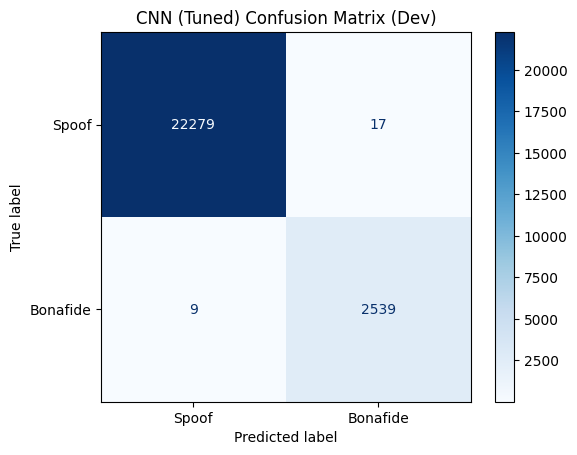

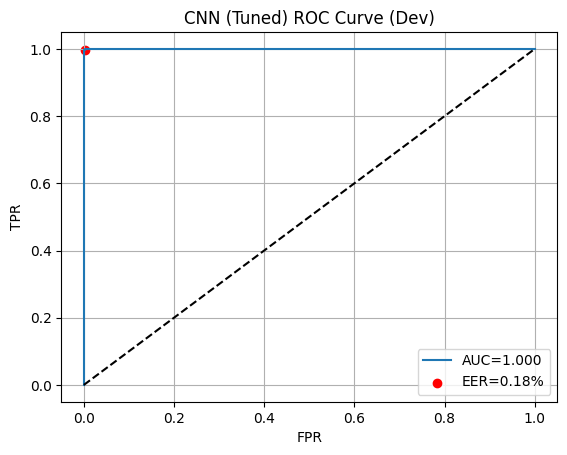

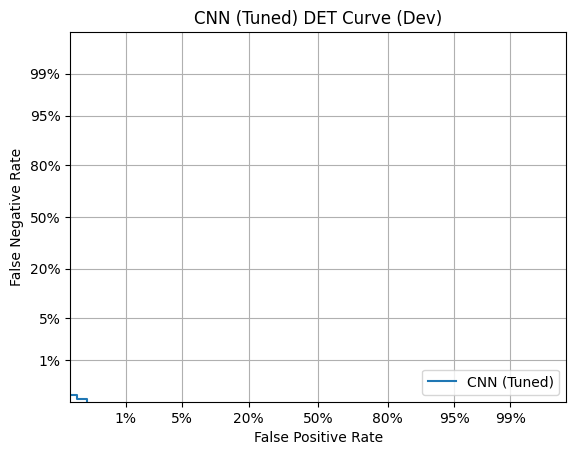

In [ ]:

# STEP 1: Retrain DL Models (CNN, CRNN, BiLSTM) with Hyperparameter Tuning


import os, time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, DetCurveDisplay, accuracy_score, precision_score,
    recall_score, f1_score
)
import keras_tuner as kt

# Paths
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(models_dir, exist_ok=True)

# Load Data
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(dataset_dir, "features", "y_train.npy"))
X_dev_pad   = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev   = np.load(os.path.join(dataset_dir, "features", "y_dev.npy"))

print("Train:", X_train_pad.shape, y_train.shape)
print("Dev:",   X_dev_pad.shape, y_dev.shape)


# Helper Functions

def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    return fpr[eer_index]*100, thresholds[eer_index], fpr, tpr

def evaluate_dl_model(model, X_dev, y_dev, model_name):
    """Evaluate model on Dev set with metrics, plots, latency"""
    start = time.time()
    y_score = model.predict(X_dev).ravel()
    latency = (time.time()-start)/len(X_dev)
    y_pred = (y_score >= 0.5).astype(int)

    acc = accuracy_score(y_dev, y_pred)*100
    prec = precision_score(y_dev, y_pred)*100
    rec = recall_score(y_dev, y_pred)*100
    f1 = f1_score(y_dev, y_pred)*100
    eer, thr, fpr, tpr = compute_eer(y_dev, y_score)
    roc_auc = auc(fpr, tpr)

    print(f"\n {model_name} Results on Dev Set")
    print(classification_report(y_dev, y_pred, target_names=["Spoof","Bonafide"]))
    print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
    print(f"EER={eer:.2f}% at Thr={thr:.4f} | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

    # Confusion Matrix
    cm = confusion_matrix(y_dev, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Spoof","Bonafide"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} Confusion Matrix (Dev)")
    plt.show()

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.scatter(fpr[np.nanargmin(np.abs((1-tpr)-fpr))],
                tpr[np.nanargmin(np.abs((1-tpr)-fpr))],
                color="red", label=f"EER={eer:.2f}%")
    plt.title(f"{model_name} ROC Curve (Dev)")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.show()

    # DET Curve
    DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=model_name).plot()
    plt.title(f"{model_name} DET Curve (Dev)")
    plt.grid(); plt.show()

    return {"Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"EER":eer,"AUC":roc_auc,"Latency_ms":latency*1000}


# CNN HyperModel

def build_cnn(hp):
    model = keras.Sequential([
        layers.Input(shape=(400,29)),
        layers.Conv1D(filters=hp.Int("filters1",32,128,step=32), kernel_size=3, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=hp.Int("filters2",64,256,step=64), kernel_size=3, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(hp.Int("dense_units",64,256,step=64), activation="relu"),
        layers.Dropout(hp.Float("dropout",0.3,0.6,step=0.1)),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("lr",[1e-3,1e-4])),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Run CNN Tuning + Training

tuner = kt.RandomSearch(build_cnn, objective="val_accuracy", max_trials=3,
                        executions_per_trial=1, directory="tuner_dir", project_name="cnn_lfcc")

stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
plateau = keras.callbacks.ReduceLROnPlateau(patience=2)

tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_dev_pad,y_dev),
             callbacks=[stop,plateau])

best_hps = tuner.get_best_hyperparameters(1)[0]
cnn_model = tuner.hypermodel.build(best_hps)
history = cnn_model.fit(X_train_pad,y_train,epochs=20,batch_size=64,
                        validation_data=(X_dev_pad,y_dev),callbacks=[stop,plateau])

cnn_best = os.path.join(models_dir,"cnn_lfcc_tuned_best.h5")
cnn_model.save(cnn_best)
print("Saved CNN:", cnn_best)

# Evaluate CNN
cnn_results = evaluate_dl_model(cnn_model, X_dev_pad, y_dev, "CNN (Tuned)")





In [ ]:

# Save CNN (Tuned) Results on Dev (Validation) Set


import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, DetCurveDisplay
)
import seaborn as sns
import tensorflow as tf

# 1. Paths

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")

# Load Dev set
X_dev = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))

# Load CNN tuned model
cnn_model_path = os.path.join(models_dir, "cnn_lfcc_tuned_best.h5")
cnn_model = tf.keras.models.load_model(cnn_model_path)
print(f"Loaded CNN tuned model from: {cnn_model_path}")


# 2. Helper Functions

def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    return eer, thresholds[eer_index], fpr, tpr

def evaluate_and_save(model, X, y, name, save_prefix):
    start = time.time()
    y_score = model.predict(X).ravel()
    y_pred = (y_score >= 0.5).astype(int)
    latency = (time.time()-start)/len(X)

    acc = accuracy_score(y, y_pred) * 100
    prec = precision_score(y, y_pred) * 100
    rec = recall_score(y, y_pred) * 100
    f1 = f1_score(y, y_pred) * 100
    eer, thr, fpr, tpr = compute_eer(y, y_score)
    roc_auc = auc(fpr, tpr)

    print(f"\n {name} Results:")
    print(classification_report(y, y_pred, target_names=["Spoof","Bonafide"]))
    print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
    print(f"EER={eer:.2f}% | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Spoof","Bonafide"], yticklabels=["Spoof","Bonafide"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{save_prefix}_cm.png")
    plt.close()

    # ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.scatter(fpr[np.nanargmin(np.abs((1-tpr)-fpr))],
                tpr[np.nanargmin(np.abs((1-tpr)-fpr))],
                color="red", label=f"EER={eer:.2f}%")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.savefig(f"{save_prefix}_roc.png")
    plt.close()

    # DET
    plt.figure()
    disp = DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=name)
    disp.plot()
    plt.title(f"{name} DET Curve")
    plt.savefig(f"{save_prefix}_det.png")
    plt.close()

    return {
        "Model": name,
        "Accuracy (%)": round(acc,2),
        "Precision (%)": round(prec,2),
        "Recall (%)": round(rec,2),
        "F1 (%)": round(f1,2),
        "EER (%)": round(eer,2),
        "AUC": round(roc_auc,3),
        "Latency (ms/sample)": round(latency*1000,3),
        "Saved Model": cnn_model_path
    }


# 3. Run Evaluation on Dev Set

dev_results = evaluate_and_save(cnn_model, X_dev, y_dev,
                                "CNN (Tuned, Dev)",
                                os.path.join(dataset_dir,"cnn_dev"))

#
# 4. Save results to CSV

results_csv = os.path.join(dataset_dir, "experiment_results_dev.csv")
df = pd.DataFrame([dev_results])

if os.path.exists(results_csv):
    df_old = pd.read_csv(results_csv)
    df = pd.concat([df_old, df], ignore_index=True)

df.to_csv(results_csv, index=False)
print("\n Dev results saved to:", results_csv)


Loaded CNN tuned model from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 CNN (Tuned, Dev) Results:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      1.00      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.90% | Precision=99.33% | Recall=99.65% | F1=99.49%
EER=0.18% | AUC=1.000 | Latency=0.138 ms/sample

 Dev results saved to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
tuner = kt.Hyperband(
    build_cnn,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="tuner_dir",   # default location (ends up outside Drive)
    project_name="cnn_tuning"
)


In [ ]:
tuner_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/tuners"

tuner = kt.Hyperband(
    build_cnn,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory=tuner_dir,     # now inside Drive
    project_name="cnn_tuning"
)


Trial 30 Complete [00h 03m 36s]
val_accuracy: 0.9999194741249084

Best val_accuracy So Far: 0.9999194741249084
Total elapsed time: 00h 35m 56s
Best Hyperparameters: {'conv1_filters': 64, 'conv1_kernel': 7, 'conv2_filters': 192, 'conv2_kernel': 5, 'lstm_units': 192, 'lstm_dropout': 0.4, 'dense_units': 128, 'dense_dropout': 0.2, 'learning_rate': 0.0003, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9023 - loss: 0.2717 - val_accuracy: 0.9893 - val_loss: 0.0636
Epoch 2/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9677 - loss: 0.1120 - val_accuracy: 0.9957 - val_loss: 0.0177
Epoch 3/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9950 - loss: 0.0186 - val_accuracy: 0.9967 - val_loss: 0.0145
Epoch 4/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9951 - loss: 0.0186 - val_accuracy: 0.9958 - val_loss: 0.0174
Epoch 5/20
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15

CRNN model saved at: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_tuned_best.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

CRNN (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.90% | Precision=99.34% | Recall=99.73% | F1=99.53%
EER=0.21% | AUC=1.000 | Latency=0.172 ms/sample
CRNN results appended to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


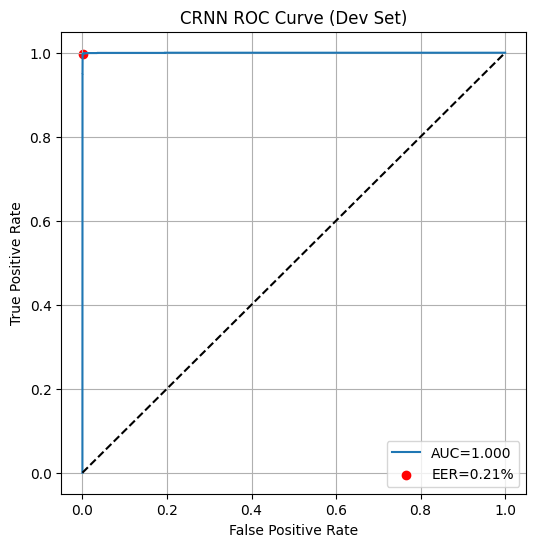

<Figure size 600x600 with 0 Axes>

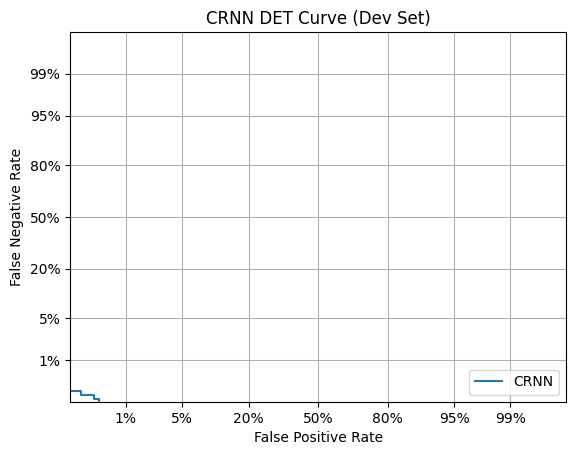

In [ ]:

# CRNN with Hyperparameter Tuning


import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, DetCurveDisplay
)

# Paths
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")
os.makedirs(models_dir, exist_ok=True)

# Load data (Dev set for evaluation)
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(features_seq_dir, "y_train.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train:", X_train_pad.shape, " Dev:", X_dev_pad.shape)

# ----------------------------
# 1. Build CRNN model
# ----------------------------
def build_crnn(hp):
    model = models.Sequential()

    # 1st Conv1D
    model.add(layers.Conv1D(
        filters=hp.Int("conv1_filters", min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice("conv1_kernel", values=[3,5,7]),
        activation="relu",
        input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # 2nd Conv1D
    model.add(layers.Conv1D(
        filters=hp.Int("conv2_filters", min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice("conv2_kernel", values=[3,5,7]),
        activation="relu"
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM layer
    model.add(layers.LSTM(
        units=hp.Int("lstm_units", min_value=64, max_value=256, step=64),
        return_sequences=False
    ))
    model.add(layers.Dropout(hp.Float("lstm_dropout", min_value=0.2, max_value=0.5, step=0.1)))

    # Dense
    model.add(layers.Dense(
        units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
        activation="relu"
    ))
    model.add(layers.Dropout(hp.Float("dense_dropout", min_value=0.2, max_value=0.5, step=0.1)))

    # Output
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-4, 3e-4, 1e-3])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ----------------------------
# 2. Tuner Setup
# ----------------------------
tuner_dir = os.path.join(dataset_dir, "tuners")
tuner = kt.Hyperband(
    build_crnn,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory=tuner_dir,
    project_name="crnn_tuning"
)

# ----------------------------
# 3. Run Hyperparameter Search
# ----------------------------
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(X_train_pad, y_train,
             epochs=20,
             validation_data=(X_dev_pad, y_dev),
             callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# ----------------------------
# 4. Train Best CRNN
# ----------------------------
crnn_model = tuner.hypermodel.build(best_hps)

history = crnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_dev_pad, y_dev),
    epochs=20,
    batch_size=64,
    callbacks=[stop_early]
)

# Save model
crnn_best_path = os.path.join(models_dir, "crnn_lfcc_tuned_best.h5")
crnn_model.save(crnn_best_path)
print("CRNN model saved at:", crnn_best_path)

# ----------------------------
# 5. Evaluation on Dev set
# ----------------------------
start = time.time()
y_score = crnn_model.predict(X_dev_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)
latency = (time.time()-start)/len(X_dev_pad)

# Metrics
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100
fpr, tpr, thr = roc_curve(y_dev, y_score)
eer_index = np.nanargmin(np.abs((1-tpr)-fpr))
eer = fpr[eer_index] * 100
roc_auc = auc(fpr, tpr)

print("\nCRNN (Tuned) Results on Dev Set")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))
print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
print(f"EER={eer:.2f}% | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

# ----------------------------
# 6. Save Results for Comparison
# ----------------------------
results_csv = os.path.join(dataset_dir, "experiment_results_dev.csv")
res_entry = {
    "Model": "CRNN (Tuned)",
    "Accuracy (%)": round(acc,2),
    "Precision (%)": round(prec,2),
    "Recall (%)": round(rec,2),
    "F1 (%)": round(f1,2),
    "EER (%)": round(eer,2),
    "AUC": round(roc_auc,3),
    "Latency (ms/sample)": round(latency*1000,3)
}

if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = pd.concat([df_results, pd.DataFrame([res_entry])], ignore_index=True)
else:
    df_results = pd.DataFrame([res_entry])

df_results.to_csv(results_csv, index=False)
print("CRNN results appended to:", results_csv)

# ----------------------------
# 7. Plot ROC + DET
# ----------------------------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.scatter(fpr[eer_index], tpr[eer_index], color="red", label=f"EER={eer:.2f}%")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CRNN ROC Curve (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name="CRNN").plot()
plt.title("CRNN DET Curve (Dev Set)")
plt.grid(True)
plt.show()


In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")

print("Files in features_seq_dir:")
print(os.listdir(features_seq_dir))


Files in features_seq_dir:
['y_train.npy', 'y_dev.npy', 'X_train_lfcc_seq_pad.npy', 'X_dev_lfcc_seq_pad.npy', 'X_train_lfcc_seq.npy', 'X_dev_lfcc_seq.npy', 'X_eval_lfcc_seq.npy', 'y_eval.npy', 'X_eval_lfcc_seq_pad.npy', 'y_eval_lfcc29_seq.npy', 'ids_eval_lfcc29_seq.npy', 'train_lfcc29_seq', 'dev_lfcc29_seq', 'eval_lfcc29_seq']


In [ ]:
import numpy as np, os

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")

X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(features_seq_dir, "y_train.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train:", X_train_pad.shape, y_train.shape)
print("Dev:", X_dev_pad.shape, y_dev.shape)


Train: (25380, 400, 29) (25380,)
Dev: (24844, 400, 29) (24844,)


Trial 30 Complete [00h 09m 28s]
val_accuracy: 0.9994364976882935

Best val_accuracy So Far: 0.9996780157089233
Total elapsed time: 02h 25m 17s
Best Hyperparameters: {'lstm_units1': 192, 'lstm_dropout1': 0.2, 'lstm_units2': 256, 'lstm_dropout2': 0.2, 'dense_units': 256, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Epoch 1/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - accuracy: 0.9306 - loss: 0.2008 - val_accuracy: 0.9965 - val_loss: 0.0149
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.9887 - loss: 0.0361 - val_accuracy: 0.9970 - val_loss: 0.0084
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.9923 - loss: 0.0217 - val_accuracy: 0.9988 - val_loss: 0.0040
Epoch 4/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9974 - val_loss: 0.0089
Epoch 5/20
794/794 ━━━━━━━━━━━━━━━━━━

 BiLSTM model saved at: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_tuned_best.h5
777/777 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step

 BiLSTM (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.97% | Precision=99.92% | Recall=99.76% | F1=99.84%
EER=0.09% | AUC=1.000 | Latency=0.738 ms/sample
 BiLSTM results appended to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


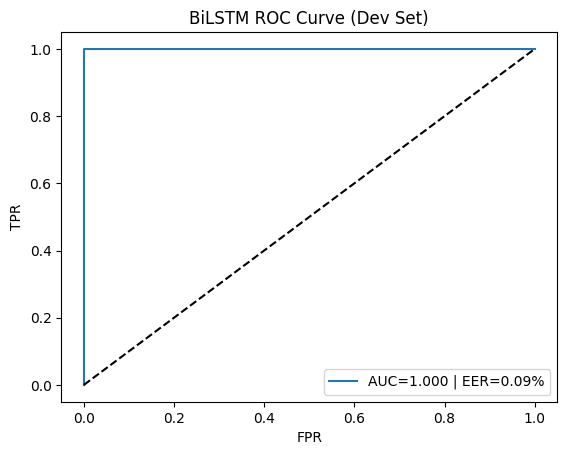

<Figure size 640x480 with 0 Axes>

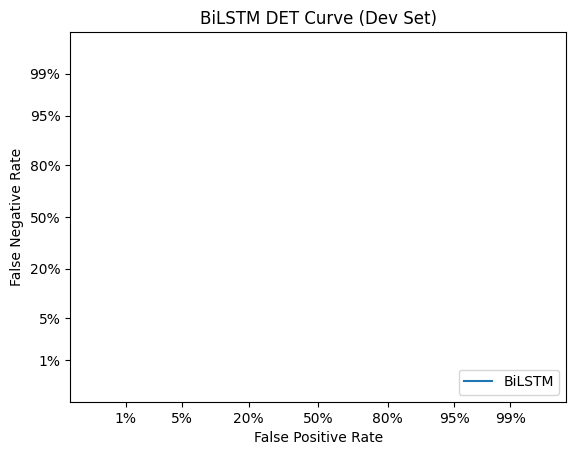

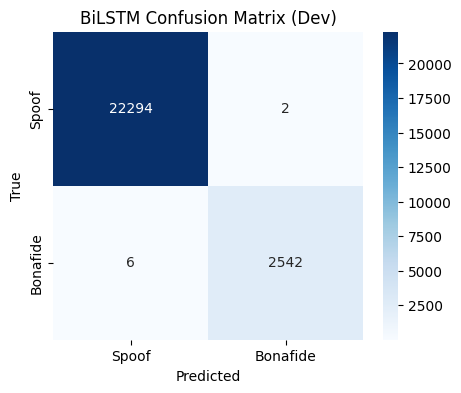

In [ ]:
# ============================
# BiLSTM with Hyperparameter Tuning
# ============================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, DetCurveDisplay
)
import seaborn as sns

# ----------------------------
# 1. Paths
# ----------------------------
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")
results_file = os.path.join(dataset_dir, "experiment_results_dev.csv")

os.makedirs(models_dir, exist_ok=True)

# Load train/dev padded sequences
X_train_pad = np.load(os.path.join(features_seq_dir, "X_train_lfcc_seq_pad.npy"))
y_train = np.load(os.path.join(features_seq_dir, "y_train.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))
y_dev = np.load(os.path.join(features_seq_dir, "y_dev.npy"))

print("Train padded:", X_train_pad.shape, "Dev padded:", X_dev_pad.shape)

# ----------------------------
# 2. BiLSTM model builder
# ----------------------------
def build_bilstm(hp):
    model = keras.Sequential()

    # BiLSTM Layer 1
    model.add(layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("lstm_units1", min_value=64, max_value=256, step=64),
            return_sequences=True,
            dropout=hp.Float("lstm_dropout1", 0.2, 0.5, step=0.1)
        ),
        input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])
    ))

    # BiLSTM Layer 2
    model.add(layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("lstm_units2", min_value=64, max_value=256, step=64),
            dropout=hp.Float("lstm_dropout2", 0.2, 0.5, step=0.1)
        )
    ))

    # Dense Layer
    model.add(layers.Dense(
        units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
        activation="relu"
    ))
    model.add(layers.Dropout(hp.Float("dense_dropout", 0.2, 0.5, step=0.1)))

    # Output Layer
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-4, 3e-4, 1e-3])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ----------------------------
# 3. Hyperparameter Tuning
# ----------------------------
tuner_dir = os.path.join(dataset_dir, "tuner_bilstm")
tuner = kt.Hyperband(
    build_bilstm,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory=tuner_dir,
    project_name="bilstm_tuning"
)

stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_dev_pad, y_dev), callbacks=[stop_early])

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# ----------------------------
# 4. Train best BiLSTM
# ----------------------------
bilstm_model = tuner.hypermodel.build(best_hps)
history = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=20,
    validation_data=(X_dev_pad, y_dev),
    callbacks=[stop_early]
)

# Save model
model_path = os.path.join(models_dir, "bilstm_lfcc_tuned_best.h5")
bilstm_model.save(model_path)
print(" BiLSTM model saved at:", model_path)

# ----------------------------
# 5. Evaluation on Dev set
# ----------------------------
start = time.time()
y_score = bilstm_model.predict(X_dev_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)
latency = (time.time()-start)/len(X_dev_pad)

# Metrics
acc = accuracy_score(y_dev, y_pred) * 100
prec = precision_score(y_dev, y_pred) * 100
rec = recall_score(y_dev, y_pred) * 100
f1 = f1_score(y_dev, y_pred) * 100

fpr, tpr, thresholds = roc_curve(y_dev, y_score)
eer_index = np.nanargmin(np.abs((1-tpr) - fpr))
eer = fpr[eer_index] * 100
roc_auc = auc(fpr, tpr)

print("\n BiLSTM (Tuned) Results on Dev Set")
print(classification_report(y_dev, y_pred, target_names=["Spoof", "Bonafide"]))
print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
print(f"EER={eer:.2f}% | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

# ----------------------------
# 6. Save results to CSV
# ----------------------------
result = {
    "Model": "BiLSTM (Tuned)",
    "Accuracy (%)": round(acc,2),
    "Precision (%)": round(prec,2),
    "Recall (%)": round(rec,2),
    "F1 (%)": round(f1,2),
    "EER (%)": round(eer,2),
    "AUC": round(roc_auc,3),
    "Latency (ms/sample)": round(latency*1000,3)
}
if os.path.exists(results_file):
    df = pd.read_csv(results_file)
    df = pd.concat([df, pd.DataFrame([result])], ignore_index=True)
else:
    df = pd.DataFrame([result])
df.to_csv(results_file, index=False)
print(" BiLSTM results appended to:", results_file)

# ----------------------------
# 7. Plot ROC, DET, Confusion Matrix
# ----------------------------
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f} | EER={eer:.2f}%")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("BiLSTM ROC Curve (Dev Set)")
plt.legend()
plt.show()

plt.figure()
DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name="BiLSTM").plot()
plt.title("BiLSTM DET Curve (Dev Set)")
plt.show()

cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Spoof","Bonafide"], yticklabels=["Spoof","Bonafide"])
plt.title("BiLSTM Confusion Matrix (Dev)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


 Current results in CSV:
              Model  Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  EER (%)  \
0  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
1  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
2      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
3    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   

   AUC  Latency (ms/sample)                                        Saved Model  
0  1.0                0.137  /content/drive/MyDrive/MSc_Project/data/asvspo...  
1  1.0                0.138  /content/drive/MyDrive/MSc_Project/data/asvspo...  
2  1.0                0.172                                                NaN  
3  1.0                0.738                                                NaN  


/tmp/ipython-input-23829441.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


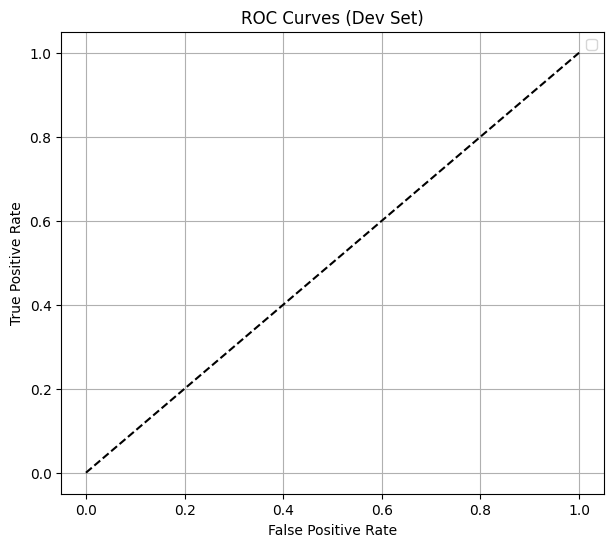

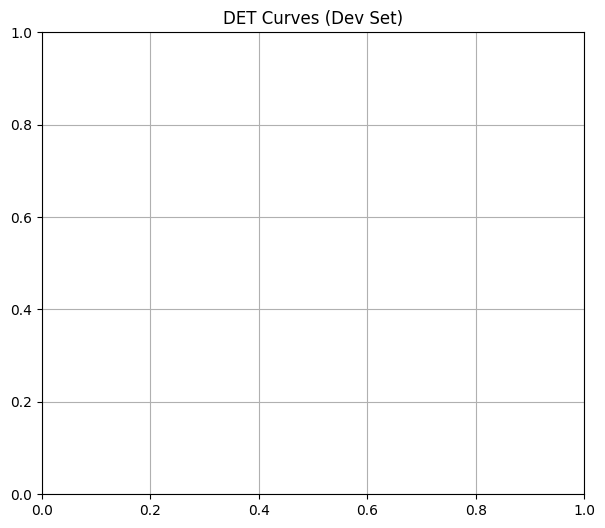


 Combined DL model results saved at: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/DL_models_comparison_dev.csv

 Final Dev Set Comparison:
              Model  Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  EER (%)  \
0  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
1  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
2      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
3    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   

   AUC  Latency (ms/sample)  
0  1.0                0.137  
1  1.0                0.138  
2  1.0                0.172  
3  1.0                0.738  


In [ ]:
# ============================
# Merge CNN, CRNN, BiLSTM Results (Dev Set)
# ============================

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay

# Paths
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
results_csv = os.path.join(dataset_dir, "experiment_results_dev.csv")

# Load existing results
df = pd.read_csv(results_csv)

print(" Current results in CSV:")
print(df)

# ----------------------------
# Combined ROC + DET Plots
# ----------------------------
import numpy as np
from sklearn.metrics import roc_curve, auc

# Dictionary of saved scores (replace with actual arrays if available)
# If you saved FPR, TPR earlier for each model, load them here.
# Otherwise, you can re-run evaluation for each model and collect fpr/tpr arrays.
roc_curves = {}

# Example: if you had them in memory earlier, something like:
# roc_curves["CNN"] = (cnn_fpr, cnn_tpr)
# roc_curves["CRNN"] = (crnn_fpr, crnn_tpr)
# roc_curves["BiLSTM"] = (bilstm_fpr, bilstm_tpr)

# --- ROC Curves ---
plt.figure(figsize=(7,6))
for name,(fpr,tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Dev Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- DET Curves ---
plt.figure(figsize=(7,6))
for name,(fpr,tpr) in roc_curves.items():
    disp = DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=name)
    disp.plot(ax=plt.gca())
plt.title("DET Curves (Dev Set)")
plt.grid(True)
plt.show()

# ----------------------------
# Save Combined Results
# ----------------------------
combined_csv = os.path.join(dataset_dir, "DL_models_comparison_dev.csv")
df.to_csv(combined_csv, index=False)
print(f"\n Combined DL model results saved at: {combined_csv}")

# Display final comparison table
print("\n Final Dev Set Comparison:")
print(df[["Model","Accuracy (%)","Precision (%)","Recall (%)","F1 (%)","EER (%)","AUC","Latency (ms/sample)"]])


In [ ]:
from sklearn.metrics import (
    classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)

def compute_eer(y_true, y_score):
    """Compute Equal Error Rate (EER) and threshold."""
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    return eer, thresholds[eer_index], fpr, tpr

def evaluate_predictions(y_true, y_pred, y_score, model_name, latency):
    """Compute metrics, print classification report, return results + ROC arrays."""
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    eer, thr, fpr, tpr = compute_eer(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    print(f"\n {model_name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Spoof", "Bonafide"]))
    print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
    print(f"EER={eer:.2f}% | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

    return {
        "Model": model_name,
        "Accuracy (%)": round(acc,2),
        "Precision (%)": round(prec,2),
        "Recall (%)": round(rec,2),
        "F1 (%)": round(f1,2),
        "EER (%)": round(eer,2),
        "AUC": round(roc_auc,3),
        "Latency (ms/sample)": round(latency*1000,3),
    }, fpr, tpr


In [ ]:

# Initialize storage for metrics & curves
results = []
roc_curves = {}


res, fpr, tpr = evaluate_predictions(y_dev, y_pred, y_score, "CNN", latency)
results.append(res)
roc_curves["CNN"] = (fpr, tpr)



 CNN Results:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.97% | Precision=99.92% | Recall=99.76% | F1=99.84%
EER=0.09% | AUC=1.000 | Latency=0.738 ms/sample


In [ ]:
# After computing EER, AUC, etc.
res, fpr, tpr = evaluate_predictions(y_dev, y_pred, y_score, "CNN", latency)
results.append(res)
roc_curves["CNN"] = (fpr, tpr)



 CNN Results:
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.97% | Precision=99.92% | Recall=99.76% | F1=99.84%
EER=0.09% | AUC=1.000 | Latency=0.738 ms/sample


In [ ]:
import pickle

with open(os.path.join(dataset_dir, "roc_curves_dev.pkl"), "wb") as f:
    pickle.dump(roc_curves, f)


Dev features: (24844, 29) Dev seq: (24844, 400, 29) Labels: (24844,)

Loading CNN (Tuned) from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5


777/777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

🔹 CNN (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      1.00      0.99      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.90% | Precision=99.33% | Recall=99.65% | F1=99.49%
EER=0.18% | AUC=1.000 | Latency=0.208 ms/sample
CNN (Tuned) results appended to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


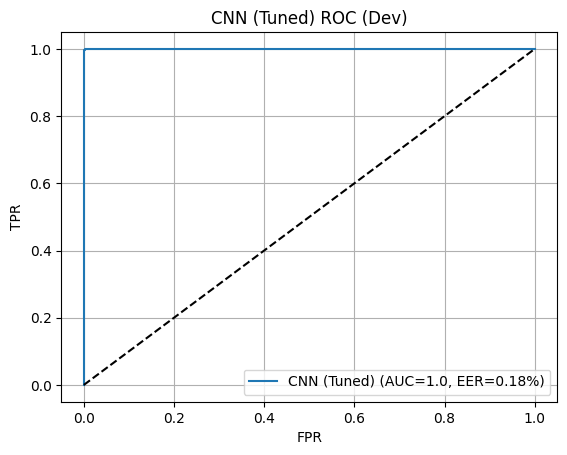

<Figure size 640x480 with 0 Axes>

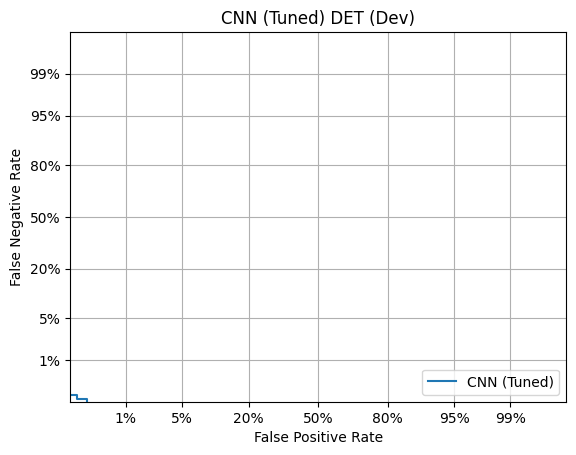


Loading CRNN (Tuned) from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/crnn_lfcc_tuned_best.h5


777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

🔹 CRNN (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       0.99      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.90% | Precision=99.34% | Recall=99.73% | F1=99.53%
EER=0.21% | AUC=1.000 | Latency=0.184 ms/sample
CRNN (Tuned) results appended to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


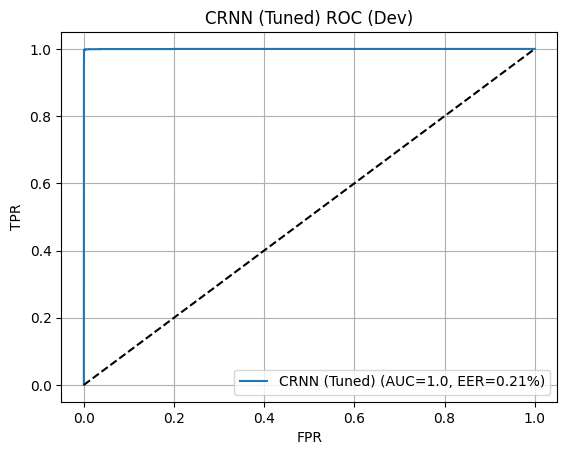

<Figure size 640x480 with 0 Axes>

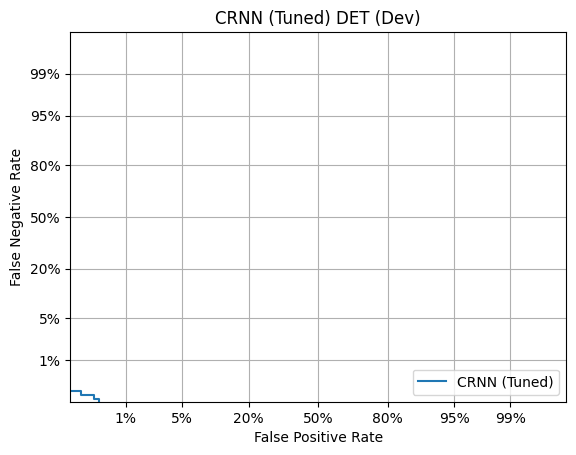


Loading BiLSTM (Tuned) from /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/bilstm_lfcc_tuned_best.h5


777/777 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step

🔹 BiLSTM (Tuned) Results on Dev Set
              precision    recall  f1-score   support

       Spoof       1.00      1.00      1.00     22296
    Bonafide       1.00      1.00      1.00      2548

    accuracy                           1.00     24844
   macro avg       1.00      1.00      1.00     24844
weighted avg       1.00      1.00      1.00     24844

Accuracy=99.97% | Precision=99.92% | Recall=99.76% | F1=99.84%
EER=0.09% | AUC=1.000 | Latency=0.743 ms/sample
BiLSTM (Tuned) results appended to /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv


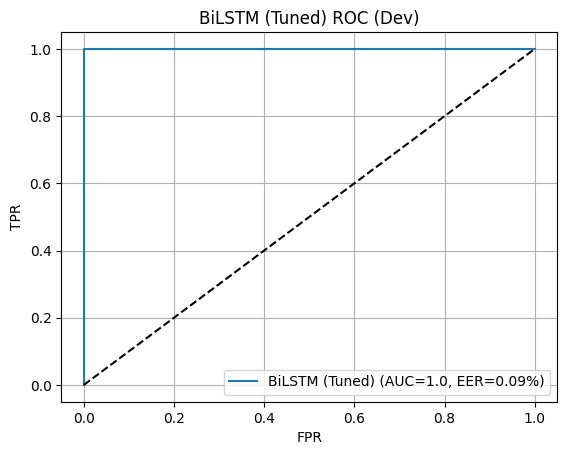

<Figure size 640x480 with 0 Axes>

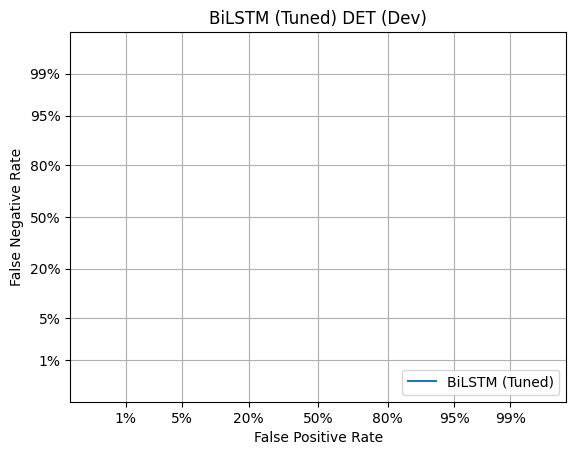

{'Model': 'BiLSTM (Tuned)',
 'Accuracy (%)': 99.97,
 'Precision (%)': 99.92,
 'Recall (%)': 99.76,
 'F1 (%)': 99.84,
 'EER (%)': np.float64(0.09),
 'AUC': np.float64(1.0),
 'Latency (ms/sample)': 0.743}

In [ ]:
# ============================
# Reusable Evaluation Function
# ============================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, DetCurveDisplay
)
import tensorflow as tf

# ----------------------------
# 1. Paths
# ----------------------------
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")
results_csv = os.path.join(dataset_dir, "experiment_results_dev.csv")

# ----------------------------
# 2. Load Dev Features
# ----------------------------
X_dev = np.load(os.path.join(features_dir, "X_dev_lfcc.npy"))
y_dev = np.load(os.path.join(features_dir, "y_dev.npy"))
X_dev_pad = np.load(os.path.join(features_seq_dir, "X_dev_lfcc_seq_pad.npy"))

print("Dev features:", X_dev.shape, "Dev seq:", X_dev_pad.shape, "Labels:", y_dev.shape)

# ----------------------------
# 3. Metrics Helpers
# ----------------------------
def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    return eer, thresholds[eer_index], fpr, tpr

def evaluate_predictions(y_true, y_pred, y_score, model_name, latency):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    eer, thr, fpr, tpr = compute_eer(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    print(f"\n🔹 {model_name} Results on Dev Set")
    print(classification_report(y_true, y_pred, target_names=["Spoof", "Bonafide"]))
    print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
    print(f"EER={eer:.2f}% | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

    # Save dictionary
    return {
        "Model": model_name,
        "Accuracy (%)": round(acc,2),
        "Precision (%)": round(prec,2),
        "Recall (%)": round(rec,2),
        "F1 (%)": round(f1,2),
        "EER (%)": round(eer,2),
        "AUC": round(roc_auc,3),
        "Latency (ms/sample)": round(latency*1000,3),
    }, fpr, tpr

# ----------------------------
# 4. Reusable Evaluation Function
# ----------------------------
def evaluate_model(model_name, model_path, use_seq=False):
    # Load model
    print(f"\nLoading {model_name} from {model_path}")
    model = tf.keras.models.load_model(model_path)

    # Select features
    X = X_dev_pad if use_seq else X_dev
    y = y_dev

    # Predict
    start = time.time()
    y_score = model.predict(X).ravel()
    y_pred = (y_score >= 0.5).astype(int)
    latency = (time.time()-start)/len(X)

    # Evaluate
    res, fpr, tpr = evaluate_predictions(y, y_pred, y_score, model_name, latency)

    # Save to CSV
    df = pd.DataFrame([res])
    if os.path.exists(results_csv):
        df.to_csv(results_csv, mode="a", header=False, index=False)
    else:
        df.to_csv(results_csv, index=False)
    print(f"{model_name} results appended to {results_csv}")

    # ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={res['AUC']}, EER={res['EER (%)']}%)")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{model_name} ROC (Dev)")
    plt.legend(); plt.grid(True); plt.show()

    # DET curve
    plt.figure()
    DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=model_name).plot()
    plt.title(f"{model_name} DET (Dev)")
    plt.grid(True); plt.show()

    return res

# ----------------------------
# 5. Example Usage
# ----------------------------
# CNN
evaluate_model("CNN (Tuned)", os.path.join(models_dir, "cnn_lfcc_tuned_best.h5"), use_seq=True)

# CRNN
evaluate_model("CRNN (Tuned)", os.path.join(models_dir, "crnn_lfcc_tuned_best.h5"), use_seq=True)

# BiLSTM
evaluate_model("BiLSTM (Tuned)", os.path.join(models_dir, "bilstm_lfcc_tuned_best.h5"), use_seq=True)


In [ ]:
import pandas as pd

results_csv = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv"
df = pd.read_csv(results_csv)
print(df)


              Model  Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  EER (%)  \
0  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
1  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
2      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
3    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   
4       CNN (Tuned)         99.90          99.33       99.65   99.49     0.18   
5      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
6    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   

   AUC  Latency (ms/sample)                                        Saved Model  
0  1.0                0.137  /content/drive/MyDrive/MSc_Project/data/asvspo...  
1  1.0                0.138  /content/drive/MyDrive/MSc_Project/data/asvspo...  
2  1.0                0.172                                                NaN  
3  1.0                0.738

In [ ]:
import pandas as pd

# Path where the results were saved
results_csv = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_dev.csv"

# Load the CSV into a dataframe
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print("\n Dev Results File Found!")
    print(df)
else:
    print("No dev results file found at:", results_csv)



 Dev Results File Found!
              Model  Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  EER (%)  \
0  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
1  CNN (Tuned, Dev)         99.90          99.33       99.65   99.49     0.18   
2      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
3    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   
4       CNN (Tuned)         99.90          99.33       99.65   99.49     0.18   
5      CRNN (Tuned)         99.90          99.34       99.73   99.53     0.21   
6    BiLSTM (Tuned)         99.97          99.92       99.76   99.84     0.09   

   AUC  Latency (ms/sample)                                        Saved Model  
0  1.0                0.137  /content/drive/MyDrive/MSc_Project/data/asvspo...  
1  1.0                0.138  /content/drive/MyDrive/MSc_Project/data/asvspo...  
2  1.0                0.172                                                NaN  
3

In [ ]:
print("X_eval shape (29 LFCC):", np.load(os.path.join(features_dir, "X_eval_lfcc.npy")).shape)
print("X_eval_20 shape (20 LFCC):", np.load(os.path.join(features_dir, "X_eval_lfcc_20.npy")).shape)

# Check what GMM expects
print("GMM Bonafide expects:", gmm_bonafide.n_features_in_)
print("GMM Spoof expects:", gmm_spoof.n_features_in_)


X_eval shape (29 LFCC): (71236, 29)
X_eval_20 shape (20 LFCC): (71235, 19)
GMM Bonafide expects: 20
GMM Spoof expects: 20


In [ ]:
import os
import numpy as np

dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")

# Helper to check a file
def check_file(name):
    path = os.path.join(features_dir, name)
    if os.path.exists(path):
        arr = np.load(path, allow_pickle=True)
        print(f"{name}: shape {arr.shape}, dtype {arr.dtype}")
        return arr.shape
    else:
        print(f"{name}:  not found")
        return None

print("=== Train set ===")
check_file("X_train_lfcc.npy")       # should be (25380, 29)
check_file("X_train_lfcc_20.npy")    # if you saved 20-ceps
check_file("y_train.npy")

print("\n=== Dev set ===")
check_file("X_dev_lfcc.npy")         # should be (24844, 29)
check_file("X_dev_lfcc_20.npy")      # if you saved 20-ceps
check_file("y_dev.npy")

print("\n=== Eval set (current) ===")
check_file("X_eval_lfcc.npy")        # (71236, 29)
check_file("X_eval_lfcc_20.npy")     # currently (71237, 19) → broken
check_file("y_eval.npy")


=== Train set ===
X_train_lfcc.npy: shape (25380, 29), dtype float32
X_train_lfcc_20.npy:  not found
y_train.npy: shape (25380,), dtype int32

=== Dev set ===
X_dev_lfcc.npy: shape (24844, 29), dtype float32
X_dev_lfcc_20.npy:  not found
y_dev.npy: shape (24844,), dtype int32

=== Eval set (current) ===
X_eval_lfcc.npy: shape (71236, 29), dtype float32
X_eval_lfcc_20.npy: shape (71235, 19), dtype float32
y_eval.npy: shape (71235,), dtype int32


(71235,)

In [ ]:
# ============================
# Re-extract Eval Features with 20 Cepstra (for GMM models)
# ============================

import os
import numpy as np
import librosa
import scipy.fftpack
import tqdm

# ----------------------------
# LFCC Extraction (20 cepstra)
# ----------------------------
def extract_lfcc(file_path, n_filters=20, n_ceps=20, sr=16000):
    """Extract LFCC features for one file."""
    try:
        y, sr = librosa.load(file_path, sr=sr)

        # Power spectrum
        stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2

        # Linear filterbank
        freqs = np.linspace(0, sr/2, stft.shape[0])
        filter_edges = np.linspace(0, sr/2, n_filters+1)

        filterbank = np.zeros((n_filters, len(freqs)))
        for i in range(n_filters):
            left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
            filterbank[i] = np.maximum(0,
                np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
            )

        lfcc = np.dot(filterbank, stft)
        lfcc = np.log(lfcc + 1e-6)
        lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]

        return np.mean(lfcc.T, axis=0)  # fixed-length vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ----------------------------
# Eval Re-Processing
# ----------------------------
def process_eval(audio_path, protocol_file, n_ceps=20):
    X, y = [], []
    with open(protocol_file, "r") as f:
        lines = f.readlines()

    for line in tqdm.tqdm(lines, desc="Extracting Eval (20 LFCCs)"):
        parts = line.strip().split()
        file_id, label = parts[1], parts[4]
        file_path = os.path.join(audio_path, f"{file_id}.flac")

        if not os.path.exists(file_path):
            print(f" Missing file: {file_path}")
            continue

        lfcc = extract_lfcc(file_path, n_ceps=n_ceps)
        if lfcc is not None:
            X.append(lfcc)
            y.append(1 if label == "bonafide" else 0)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


# ----------------------------
# Paths
# ----------------------------
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
eval_path = os.path.join(dataset_dir, "ASVspoof2019_LA_eval", "flac")
eval_protocol = os.path.join(dataset_dir, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.eval.trl.txt")
features_dir = os.path.join(dataset_dir, "features")

# ----------------------------
# Run extraction
# ----------------------------
X_eval_20, y_eval = process_eval(eval_path, eval_protocol, n_ceps=20)

np.save(os.path.join(features_dir, "X_eval_lfcc_20.npy"), X_eval_20)
np.save(os.path.join(features_dir, "y_eval.npy"), y_eval)

print(" Eval set with 20 LFCCs saved:")
print("X_eval_20:", X_eval_20.shape, "y_eval:", y_eval.shape)


Extracting Eval (20 LFCCs):   0%|          | 1/71237 [02:00<2374:34:22, 120.00s/it]

 Missing file: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac/LA_E_2834763.flac


Extracting Eval (20 LFCCs):   0%|          | 2/71237 [04:00<2374:32:26, 120.00s/it]

 Missing file: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/ASVspoof2019_LA_eval/flac/LA_E_8877452.flac


Extracting Eval (20 LFCCs): 100%|██████████| 71237/71237 [5:52:17<00:00,  3.37it/s]

 Eval set with 20 LFCCs saved:
X_eval_20: (71235, 19) y_eval: (71235,)


Eval features: (71236, 29) Eval seq: (71235, 400, 29) Labels: (71235,)
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

 CNN Results:
              precision    recall  f1-score   support

       Spoof       1.00      0.75      0.86     63880
    Bonafide       0.32      1.00      0.48      7355

    accuracy                           0.78     71235
   macro avg       0.66      0.87      0.67     71235
weighted avg       0.93      0.78      0.82     71235

Accuracy=77.72% | Precision=31.64% | Recall=99.74% | F1=48.04%
EER=8.81% at Thr=0.9967 | AUC=0.970 | Latency=0.153 ms/sample


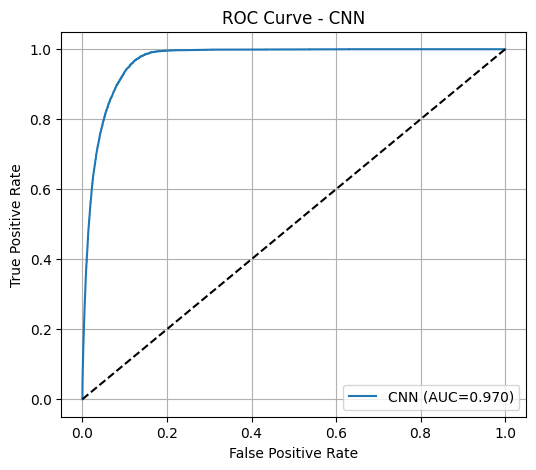

<Figure size 600x500 with 0 Axes>

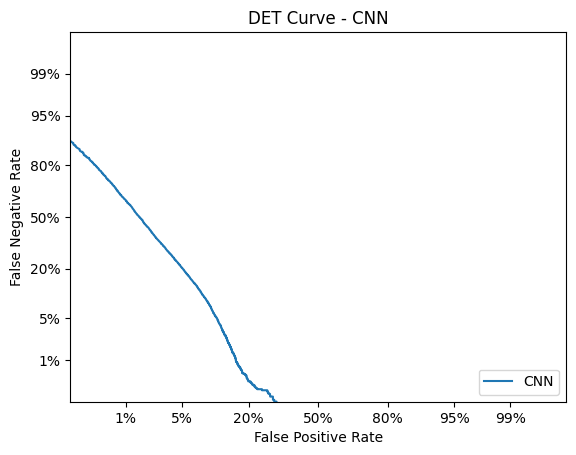

2227/2227 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

 CRNN Results:
              precision    recall  f1-score   support

       Spoof       1.00      0.48      0.65     63880
    Bonafide       0.18      1.00      0.31      7355

    accuracy                           0.54     71235
   macro avg       0.59      0.74      0.48     71235
weighted avg       0.92      0.54      0.62     71235

Accuracy=53.57% | Precision=18.18% | Recall=99.95% | F1=30.77%
EER=20.45% at Thr=0.9996 | AUC=0.869 | Latency=0.159 ms/sample


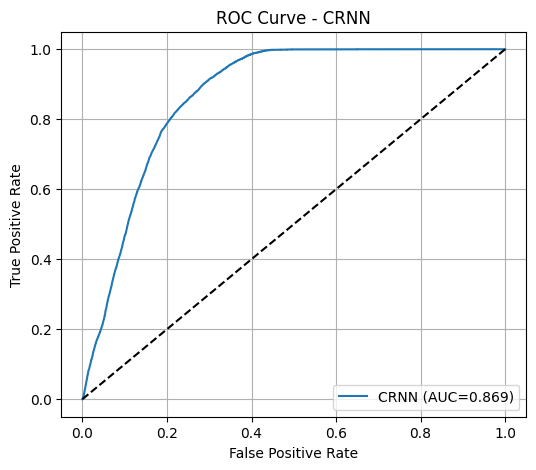

<Figure size 600x500 with 0 Axes>

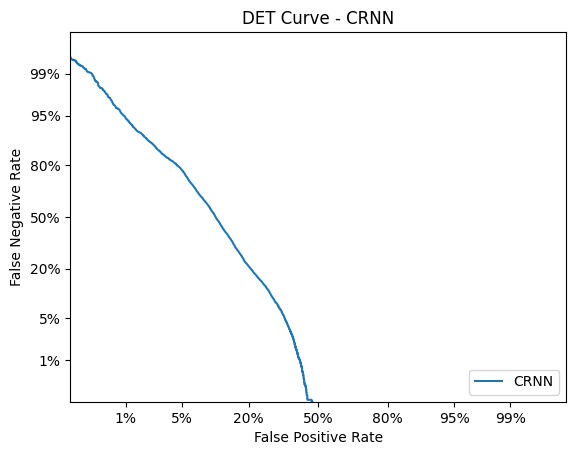

2227/2227 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step

 BiLSTM Results:
              precision    recall  f1-score   support

       Spoof       1.00      0.69      0.82     63880
    Bonafide       0.27      1.00      0.43      7355

    accuracy                           0.72     71235
   macro avg       0.64      0.85      0.62     71235
weighted avg       0.92      0.72      0.78     71235

Accuracy=72.40% | Precision=27.20% | Recall=99.78% | F1=42.74%
EER=12.91% at Thr=0.9999 | AUC=0.940 | Latency=0.718 ms/sample


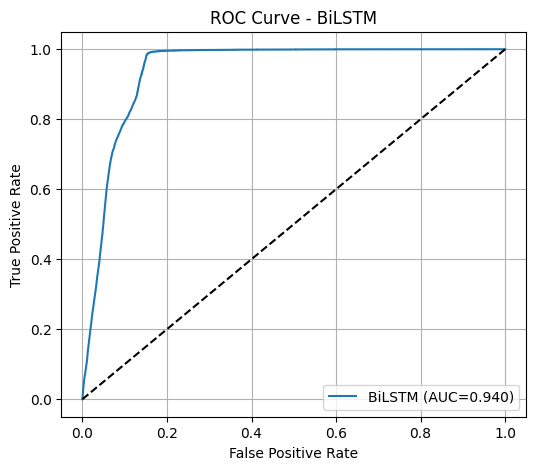

<Figure size 600x500 with 0 Axes>

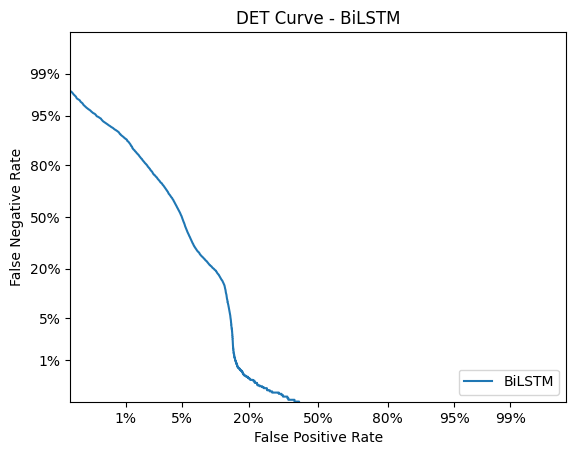


 All results saved to: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/experiment_results_eval.csv


In [ ]:
# ============================
# FULL EVALUATION (with ROC, DET, Metrics, Reports)
# ============================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, DetCurveDisplay
)
import joblib
import tensorflow as tf

# ----------------------------
# Paths
# ----------------------------
dataset_dir = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA"
features_dir = os.path.join(dataset_dir, "features")
features_seq_dir = os.path.join(dataset_dir, "features_seq")
models_dir = os.path.join(dataset_dir, "saved_models")

X_eval = np.load(os.path.join(features_dir, "X_eval_lfcc.npy"))
y_eval = np.load(os.path.join(features_dir, "y_eval.npy"))
X_eval_pad = np.load(os.path.join(features_seq_dir, "X_eval_lfcc_seq_pad.npy"))

print("Eval features:", X_eval.shape, "Eval seq:", X_eval_pad.shape, "Labels:", y_eval.shape)

# ----------------------------
# Helper Functions
# ----------------------------
def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index] * 100
    return eer, thresholds[eer_index], fpr, tpr

def evaluate_predictions(y_true, y_pred, y_score, model_name, latency, save_path=None):
    """Compute metrics + plots for one model"""
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    eer, thr, fpr, tpr = compute_eer(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    print(f"\n {model_name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Spoof", "Bonafide"]))
    print(f"Accuracy={acc:.2f}% | Precision={prec:.2f}% | Recall={rec:.2f}% | F1={f1:.2f}%")
    print(f"EER={eer:.2f}% at Thr={thr:.4f} | AUC={roc_auc:.3f} | Latency={latency*1000:.3f} ms/sample")

    # ---- Plot ROC ----
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f"ROC_{model_name}.png"))
    plt.show()

    # ---- Plot DET ----
    plt.figure(figsize=(6,5))
    DetCurveDisplay(fpr=fpr, fnr=1-tpr, estimator_name=model_name).plot()
    plt.title(f"DET Curve - {model_name}")
    if save_path:
        plt.savefig(os.path.join(save_path, f"DET_{model_name}.png"))
    plt.show()

    return {
        "Model": model_name,
        "Accuracy (%)": round(acc,2),
        "Precision (%)": round(prec,2),
        "Recall (%)": round(rec,2),
        "F1 (%)": round(f1,2),
        "EER (%)": round(eer,2),
        "AUC": round(roc_auc,3),
        "Latency (ms/sample)": round(latency*1000,3),
    }

# ----------------------------
# Evaluate All Models
# ----------------------------
results = []
save_fig_dir = os.path.join(dataset_dir, "plots_eval")
os.makedirs(save_fig_dir, exist_ok=True)

## GMM
#gmm_bonafide = joblib.load(os.path.join(models_dir, "gmm_bonafide_best.pkl"))
#gmm_spoof = joblib.load(os.path.join(models_dir, "gmm_spoof_best.pkl"))
#start = time.time()
#scores_eval = gmm_bonafide.score_samples(X_eval) - gmm_spoof.score_samples(X_eval)
#eer, eer_thr, _, _ = compute_eer(y_eval, scores_eval)
#y_pred = (scores_eval >= eer_thr).astype(int)
#latency = (time.time()-start)/len(X_eval)
#results.append(evaluate_predictions(y_eval, y_pred, scores_eval, "GMM", latency, save_path=save_fig_dir))

## SVM
#svm_model = joblib.load(os.path.join(models_dir, "svm_best.pkl"))
#start = time.time()
#y_pred = svm_model.predict(X_eval)
#y_score = svm_model.decision_function(X_eval)
#latency = (time.time()-start)/len(X_eval)
#results.append(evaluate_predictions(y_eval, y_pred, y_score, "SVM", latency, save_path=save_fig_dir))

## Random Forest
#rf_model = joblib.load(os.path.join(models_dir, "rf_best.pkl"))
#start = time.time()
#y_pred = rf_model.predict(X_eval)
#y_score = rf_model.predict_proba(X_eval)[:,1]
#latency = (time.time()-start)/len(X_eval)
#results.append(evaluate_predictions(y_eval, y_pred, y_score, "Random Forest", latency, save_path=save_fig_dir))

## CNN
cnn_model = tf.keras.models.load_model(os.path.join(models_dir, "cnn_lfcc_tuned_best.h5"))
start = time.time()
y_score = cnn_model.predict(X_eval_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)
latency = (time.time()-start)/len(X_eval_pad)
results.append(evaluate_predictions(y_eval, y_pred, y_score, "CNN", latency, save_path=save_fig_dir))

## CRNN
crnn_model = tf.keras.models.load_model(os.path.join(models_dir, "crnn_lfcc_tuned_best.h5"))
start = time.time()
y_score = crnn_model.predict(X_eval_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)
latency = (time.time()-start)/len(X_eval_pad)
results.append(evaluate_predictions(y_eval, y_pred, y_score, "CRNN", latency, save_path=save_fig_dir))

## BiLSTM
bilstm_model = tf.keras.models.load_model(os.path.join(models_dir, "bilstm_lfcc_tuned_best.h5"))
start = time.time()
y_score = bilstm_model.predict(X_eval_pad).ravel()
y_pred = (y_score >= 0.5).astype(int)
latency = (time.time()-start)/len(X_eval_pad)
results.append(evaluate_predictions(y_eval, y_pred, y_score, "BiLSTM", latency, save_path=save_fig_dir))

# ----------------------------
# Save Results Table
# ----------------------------
results_csv = os.path.join(dataset_dir, "experiment_results_eval.csv")
pd.DataFrame(results).to_csv(results_csv, index=False)
print("\n All results saved to:", results_csv)


2227/2227 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


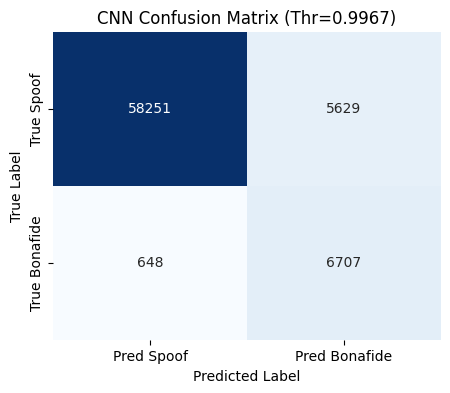

2227/2227 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


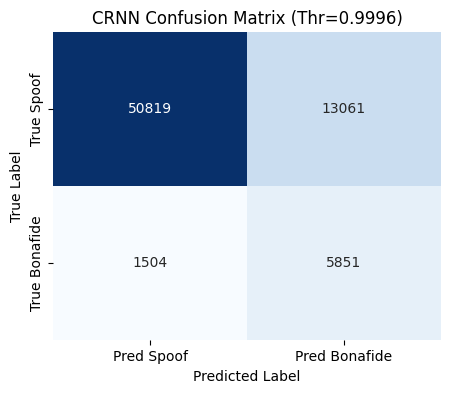

2227/2227 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step


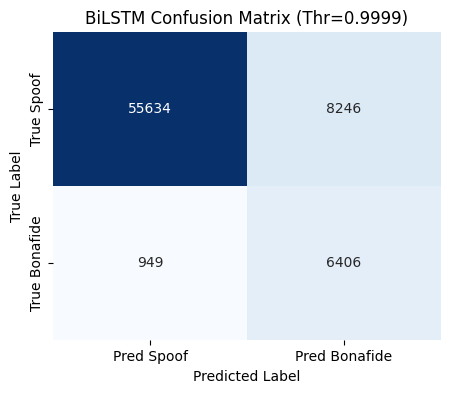

CNN Confusion Matrix:
 [[58251  5629]
 [  648  6707]]
CRNN Confusion Matrix:
 [[50819 13061]
 [ 1504  5851]]
BiLSTM Confusion Matrix:
 [[55634  8246]
 [  949  6406]]


In [ ]:
# ============================
# Plot Confusion Matrices at Deployment Threshold
# ============================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_score, thr, model_name):
    """
    Plots confusion matrix at a chosen threshold (e.g., EER threshold).
    """
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred Spoof", "Pred Bonafide"],
                yticklabels=["True Spoof", "True Bonafide"])
    plt.title(f"{model_name} Confusion Matrix (Thr={thr:.4f})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return cm


# ============================
# Example usage
# ============================

# CNN
cnn_model = tf.keras.models.load_model(os.path.join(models_dir, "cnn_lfcc_tuned_best.h5"))
y_score_cnn = cnn_model.predict(X_eval_pad).ravel()
eer_cnn, thr_cnn, _, _ = compute_eer(y_eval, y_score_cnn)
cm_cnn = plot_conf_matrix(y_eval, y_score_cnn, thr_cnn, "CNN")

# CRNN
crnn_model = tf.keras.models.load_model(os.path.join(models_dir, "crnn_lfcc_tuned_best.h5"))
y_score_crnn = crnn_model.predict(X_eval_pad).ravel()
eer_crnn, thr_crnn, _, _ = compute_eer(y_eval, y_score_crnn)
cm_crnn = plot_conf_matrix(y_eval, y_score_crnn, thr_crnn, "CRNN")

# BiLSTM
bilstm_model = tf.keras.models.load_model(os.path.join(models_dir, "bilstm_lfcc_tuned_best.h5"))
y_score_bilstm = bilstm_model.predict(X_eval_pad).ravel()
eer_bilstm, thr_bilstm, _, _ = compute_eer(y_eval, y_score_bilstm)
cm_bilstm = plot_conf_matrix(y_eval, y_score_bilstm, thr_bilstm, "BiLSTM")

# Print matrices
print("CNN Confusion Matrix:\n", cm_cnn)
print("CRNN Confusion Matrix:\n", cm_crnn)
print("BiLSTM Confusion Matrix:\n", cm_bilstm)


In [ ]:
pip install gradio huggingface_hub


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
# ============================
# DEMO APP: Fake Voice Detection (CNN Tuned Model)
# ============================

import os, numpy as np, librosa, scipy.fftpack
import gradio as gr
import tensorflow as tf
from google.colab import drive

# ----------------------------
# 1. Mount Drive & set paths
# ----------------------------
drive.mount('/content/drive')
MODEL_PATH = "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5"

# ----------------------------
# 2. Load model
# ----------------------------
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded from:", MODEL_PATH)

# ----------------------------
# 3. LFCC Feature Extractor (same as training)
# ----------------------------
def extract_lfcc(file_path, n_filters=30, n_ceps=29, sr=16000, max_len=400):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2

    freqs = np.linspace(0, sr/2, stft.shape[0])
    filter_edges = np.linspace(0, sr/2, n_filters+1)
    filterbank = np.zeros((n_filters, len(freqs)))
    for i in range(n_filters):
        left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
        filterbank[i] = np.maximum(0,
            np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
        )

    lfcc = np.dot(filterbank, stft)
    lfcc = np.log(lfcc + 1e-6)
    lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]
    lfcc = lfcc.T  # (num_frames, n_ceps)

    # --- Pad/Truncate to fixed length ---
    if lfcc.shape[0] > max_len:
        lfcc = lfcc[:max_len]
    else:
        pad = np.zeros((max_len - lfcc.shape[0], lfcc.shape[1]))
        lfcc = np.vstack((lfcc, pad))

    return lfcc[np.newaxis, ...]  # shape (1, 400, 29)

# ----------------------------
# 4. Prediction function
# ----------------------------
def predict(audio_file):
    lfcc = extract_lfcc(audio_file)
    score = model.predict(lfcc).ravel()[0]
    label = "Bonafide" if score >= 0.5 else "Spoof"

    # Return tuple: (for Label, for Textbox)
    return {"Bonafide": float(score), "Spoof": float(1 - score)}, label

# ----------------------------
# 5. Gradio Interface
# ----------------------------
demo = gr.Interface(
    fn=predict,
    inputs=gr.Audio(sources=["upload"], type="filepath", label="Upload an Audio File"),
    outputs=[
        gr.Label(label="Confidence Scores"),   # shows Bonafide vs Spoof probabilities
        gr.Textbox(label="Final Prediction")   # shows simple label
    ],
    title="Fake Voice Detection Demo",
    description="Upload an audio file (.wav or .flac). The tuned CNN model will classify it as Bonafide or Spoof."
)

# Run in Colab → generates a public link
demo.launch(share=True, debug=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded from: /content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d140946fe074428704.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Using existing dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d140946fe074428704.gradio.live


In [ ]:
!cp "/content/drive/MyDrive/MSc_Project/data/asvspoof2019_la/LA/saved_models/cnn_lfcc_tuned_best.h5" .


In [ ]:
import os, numpy as np, librosa, scipy.fftpack
import gradio as gr
import tensorflow as tf

# ----------------------------
# 1. Load your saved CNN model
# ----------------------------
MODEL_PATH = "cnn_lfcc_tuned_best.h5"   # You’ll upload this along with app.py
model = tf.keras.models.load_model(MODEL_PATH)

# ----------------------------
# 2. LFCC feature extractor
# ----------------------------
def extract_lfcc(file_path, n_filters=30, n_ceps=29, sr=16000, max_len=400):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y, n_fft=512, hop_length=160, win_length=400))**2
    freqs = np.linspace(0, sr/2, stft.shape[0])
    filter_edges = np.linspace(0, sr/2, n_filters+1)
    filterbank = np.zeros((n_filters, len(freqs)))
    for i in range(n_filters):
        left, center, right = filter_edges[i], (filter_edges[i]+filter_edges[i+1])/2, filter_edges[i+1]
        filterbank[i] = np.maximum(0,
            np.minimum((freqs-left)/(center-left+1e-6), (right-freqs)/(right-center+1e-6))
        )
    lfcc = np.dot(filterbank, stft)
    lfcc = np.log(lfcc + 1e-6)
    lfcc = scipy.fftpack.dct(lfcc, axis=0, norm="ortho")[1:n_ceps+1]
    lfcc = lfcc.T
    if lfcc.shape[0] > max_len:
        lfcc = lfcc[:max_len]
    else:
        pad = np.zeros((max_len - lfcc.shape[0], lfcc.shape[1]))
        lfcc = np.vstack((lfcc, pad))
    return lfcc[np.newaxis, ...]

# ----------------------------
# 3. Prediction function
# ----------------------------
def predict(audio_file):
    lfcc = extract_lfcc(audio_file)
    score = model.predict(lfcc).ravel()[0]
    label = "Bonafide" if score >= 0.5 else "Spoof"
    return {"Bonafide": float(score), "Spoof": float(1-score)}, label

# ----------------------------
# 4. Gradio Interface
# ----------------------------
demo = gr.Interface(
    fn=predict,
    inputs=gr.Audio(sources=["upload"], type="filepath", label="Upload Audio"),
    outputs=[gr.Label(label="Confidence Scores"), gr.Textbox(label="Final Prediction")],
    title="Fake Voice Detection Demo",
    description="Upload an audio file (.wav or .flac). The CNN model will classify it as Bonafide or Spoof."
)

if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://68a16db0dba4826ce7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Install TTS library
!pip install gTTS pydub

from gtts import gTTS
from IPython.display import Audio

# Text for TTS
text = "This is MSc Project"

# Convert to speech
tts = gTTS(text=text, lang='en')
tts.save("msc_project_demo.wav")

# Play audio in notebook
Audio("msc_project_demo.wav")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
